## Common Utilities (Run it first)

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import warnings
import re
from gensim.models import TfidfModel
from scipy import stats
from gensim.corpora import Dictionary
from textblob import TextBlob
from autocorrect import Speller
from spellchecker import SpellChecker
from collections import Counter, defaultdict
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from empath import Empath
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models.doc2vec import Doc2Vec
import gensim.downloader as api
from transformers import AutoTokenizer, AutoModel
import torch
from tqdm import tqdm
import contractions
from nltk.stem import WordNetLemmatizer
import html

nltk.download('wordnet', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
warnings.filterwarnings('ignore')

# CONFIGURATION & CONSTANTS

# Category definitions
CATEGORIES = ['hate_speech', 'offensive_language', 'neither']

# Mapping: class number → category name
CLASS_TO_CATEGORY = {
    0: 'hate_speech',
    1: 'offensive_language',
    2: 'neither'
}

# Mapping: category name → class number  
CATEGORY_TO_CLASS = {
    'hate_speech': 0,
    'offensive_language': 1,
    'neither': 2
}

# Analysis parameters (eliminates magic numbers)
TOP_N_FREQUENT_WORDS = 30
TOP_N_TFIDF_WORDS = 30
TOP_N_EMPATH_CATEGORIES = 15
N_ERROR_EXAMPLES = 20
N_SENTIMENT_BINS = 10
CONFIDENCE_LEVEL = 0.90
HEAPS_LAW_STEP_SIZE = 50

# Pronoun POS tags (Penn Treebank)
PRONOUN_TAGS = ['PRP', 'PRP$']

### Helper Functions

In [17]:
# UTILITY FUNCTIONS (Defined once, used throughout)

# Download necessary NLTK data only once. TODO: Uncomment if running for the first time.
# def download_nltk_data():
#     """Download necessary NLTK resources."""
#     nltk.download('punkt', quiet=True)
#     nltk.download('stopwords', quiet=True)
#     nltk.download('averaged_perceptron_tagger', quiet=True)
#     nltk.download('wordnet', quiet=True)
# download_nltk_data()

def clean_text(text):
    """
    Clean and normalize text for analysis.
    
    Removes HTML entities, URLs, mentions, hashtags, RT indicators,
    and normalizes whitespace.

    Expands contractions and removes unwanted characters.
    """
    if pd.isna(text):
        return ""
    
    text = str(text).lower()

    # # Expand contractions. For tweets: spell correction may need to be handled before it.
    # text = contractions.fix(text)

    # Remove HTML tags & decode HTML entities
    text = re.sub(r'<.*?>', '', text)
    text = html.unescape(text)

    # Remove URLs, mentions
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'@\w+', '', text)

    # Remove hashtags but keep the text
    text = re.sub(r'#(\w+)', r'\1', text)

    # Remove RT (retweet) indicator
    text = re.sub(r'\brt\b', '', text, flags=re.IGNORECASE)
        # VADER treats 'RT' as a neutral token → it doesn't affect sentiment.
        # Jaccard calculates vocabulary overlap → 'rt' appears evenly in all 3 categories → it doesn't affect similarity.

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def tokenize_text(text):
    """
    Tokenize text into alphabetic words.
    
    Returns list of lowercase alphabetic tokens with length > 1.
    """
    tokens = word_tokenize(text)
    # Keep only alphabetic tokens (remove punctuation, numbers, emoji)
    tokens = [token for token in tokens if token.isalpha() and len(token) > 1]

    return tokens

def remove_stopwords(tokens, stopword_set):
    """Remove stopwords from token list."""
    return [token for token in tokens if token not in stopword_set]

def count_pronouns(tokens):
    """
    Count pronouns using POS tagging.
    
    Counts personal pronouns (PRP) and possessive pronouns (PRP$).
    """
    if not tokens:
        return 0
    pos_tags = nltk.pos_tag(tokens)
    pronoun_count = sum(1 for word, tag in pos_tags if tag in PRONOUN_TAGS)
    return pronoun_count

def is_valid_word(word):
    """
    Check if word exists in WordNet lexicon.
    
    Returns True if word is valid (in WordNet or is a number).
    """
    if not word or word.isdigit():
        return True
    word_lower = word.lower()
    return len(wordnet.synsets(word_lower)) > 0

def get_category_dataframe(df, category_name):
    """
    Filter dataframe by category name.
    
    Returns dataframe filtered to specified category.
    """
    class_num = CATEGORY_TO_CLASS[category_name]
    return df[df['class'] == class_num]

def load_and_explore_data(filepath):
    """Load data and print exploration statistics."""
    print("--- Data Loading and Exploration ---")
    df = pd.read_csv(filepath)
    print(f"Dataset shape: {df.shape}")
    print(f"\nColumns: {df.columns.tolist()}")
    print(f"\nData types:\n{df.dtypes}")
    print(f"\nMissing values:\n{df.isnull().sum()}")
    print(f"\nClass distribution:\n{df['class'].value_counts()}")
    return df

def get_wordnet_pos(tag):
    """Convert Penn Treebank POS tag to WordNet POS tag."""
    if tag.startswith('N'):
        return wordnet.NOUN
    if tag.startswith('V'):
        return wordnet.VERB
    if tag.startswith('J'):
        return wordnet.ADJ
    if tag.startswith('R'):
        return wordnet.ADV
    return wordnet.NOUN  # Default fallback

def preprocess_data(df, stopword_set, is_lemmatize=False):
    """
    Apply all preprocessing steps to the dataframe.
    
    Creates columns:
    - category: category name
    - cleaned_tweet: cleaned text
    - tokens: all tokens
    - tokens_without_stopwords: tokens with stopwords removed
    - pronoun_count: number of pronouns
    """
    print("\n--- Data Preprocessing ---")
    
    # CREATE COPY to avoid modifying original
    df = df.copy()

    # Add category name column
    df['category'] = df['class'].map(CLASS_TO_CATEGORY)
    print("✓ Added 'category' column.")

    # Clean text
    print("Cleaning text...")
    df['cleaned_tweet'] = df['tweet'].apply(clean_text)
    print("✓ Cleaned tweets.")

    # Tokenize
    print("Tokenizing text...")
    df['tokens'] = df['cleaned_tweet'].apply(tokenize_text)
    df['tokens_without_stopwords'] = df['tokens'].apply(
        lambda tokens: remove_stopwords(tokens, stopword_set)
    )
    print("✓ Tokenized tweets and removed stopwords.")

    # Lemmatization (POS-aware) - optional
    if is_lemmatize:
        lemmatizer = WordNetLemmatizer()
        print("Lemmatizing tokens (POS-aware)...")
        def lemmatize_with_pos(tokens):
            # Get POS tags
            tokens_pos_tags = nltk.pos_tag(tokens)
            
            # Lemmatize with correct POS
            lemmatized = [
                lemmatizer.lemmatize(token, pos=get_wordnet_pos(pos_tag))
                for token, pos_tag in tokens_pos_tags
            ]
            return lemmatized

        df['tokens'] = df['tokens'].apply(lemmatize_with_pos)
        print("✓ Lemmatized tokens (POS-aware).")

    # Count pronouns
    print("Counting pronouns...")
    df['pronoun_count'] = df['tokens'].apply(count_pronouns)
    print("✓ Counted pronouns.")
    
    return df

stop_words = set(stopwords.words('english'))

## Load data

In [18]:
df = load_and_explore_data('reddit_hate_speech.csv')
df = preprocess_data(df, stop_words)
df_lemmatized = preprocess_data(df, stop_words, is_lemmatize=True)

--- Data Loading and Exploration ---
Dataset shape: (24783, 7)

Columns: ['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither', 'class', 'tweet']

Data types:
Unnamed: 0             int64
count                  int64
hate_speech            int64
offensive_language     int64
neither                int64
class                  int64
tweet                 object
dtype: object

Missing values:
Unnamed: 0            0
count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
dtype: int64

Class distribution:
class
1    19190
2     4163
0     1430
Name: count, dtype: int64

--- Data Preprocessing ---
✓ Added 'category' column.
Cleaning text...
✓ Cleaned tweets.
Tokenizing text...
✓ Tokenized tweets and removed stopwords.
Counting pronouns...
✓ Counted pronouns.

--- Data Preprocessing ---
✓ Added 'category' column.
Cleaning text...
✓ Cleaned tweets.
Tokenizing text...
✓ Tokenized tweets and

## Task 1: Hate Speech Statistics and Word Cloud 

### Task 1.1: Hate Speech Statistics and Top Frequent Terms

In [19]:
def calculate_vocabulary_stats(df):
    """Calculate vocabulary and token statistics for each category."""
    print("\n--- Vocabulary and Statistical Analysis ---")
    results = {}
    
    for category in CATEGORIES:
        print(f"Processing: {category.replace('_', ' ').title()}")

        # Filter tweets for this category
        category_df = get_category_dataframe(df, category)
        print(f"Number of tweets: {len(category_df)}")

        # Get all tokens (with and without stopwords)
        all_tokens = [token for token_list in category_df['tokens'] for token in token_list]
        token_counts = category_df['tokens'].apply(len)
        pronoun_counts = category_df['pronoun_count']
        annotator_counts = category_df['count']
            
        vocabulary = set(all_tokens)
        vocabulary_size = len(vocabulary)
        total_tokens = len(all_tokens)

        avg_tokens = np.mean(token_counts)
        std_tokens = np.std(token_counts)

        avg_pronouns = np.mean(pronoun_counts)
        std_pronouns = np.std(pronoun_counts)
        
        avg_annotators = np.mean(annotator_counts)
        std_annotators = np.std(annotator_counts)

        # Get tokens without stopwords for frequency analysis
        tokens_without_stopwords = [
            token for token_list in category_df['tokens_without_stopwords'] 
            for token in token_list
        ]

        word_freq = Counter(tokens_without_stopwords)
        most_common_words = word_freq.most_common(TOP_N_FREQUENT_WORDS)

        results[category] = {
            'vocabulary_size': vocabulary_size,
            'total_tokens': total_tokens,
            'avg_tokens_per_post': avg_tokens,
            'std_tokens_per_post': std_tokens,
            'avg_pronouns_per_post': avg_pronouns,
            'std_pronouns_per_post': std_pronouns,
            'avg_annotators': avg_annotators,
            'std_annotators': std_annotators,
            'top_30_words': most_common_words,
            'num_posts': len(category_df)
        }
    return results

def print_stats_summary_table(results):
    """Prints a formatted summary table of the vocabulary statistics."""
    print("\n" + "="*80)
    print("Vocabulary and Statistical Analysis Summary")
    print("="*80)
    summary_data = []
    for category in CATEGORIES:
        stats = results[category]
        summary_data.append({
            'Category': category.replace("_", " ").title(),
            'Num Tweets': stats['num_posts'],
            'Vocabulary Size': stats['vocabulary_size'],
            'Total Tokens': stats['total_tokens'],
            'Avg Tokens/Post': stats['avg_tokens_per_post'],
            'Std Tokens/Post': stats['std_tokens_per_post'],
            'Avg Pronouns/Post': stats['avg_pronouns_per_post'],
            'Std Pronouns/Post': stats['std_pronouns_per_post'],
            'Avg Annotators': stats['avg_annotators'],
            'Std Annotators': stats['std_annotators']
        })
    
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))

def analyze_category_balance(results):
    """Analyzes and prints the balance of tweet categories in the dataset."""
    print("\n" + "=" * 80)
    print("Category Balance Analysis")
    print("="*80)

    category_counts = {}
    for category in CATEGORIES: 
        category_counts[category] = results[category]['num_posts']
    
    total_tweets = sum(category_counts.values())

    print(f"\nTotal tweets in dataset: {total_tweets:,}")
    for category in CATEGORIES:
        count = category_counts[category]
        percentage = (count / total_tweets) * 100
        cat_display = category.replace('_', ' ').title()

        # Visual bar
        bar_length = int(percentage / 2)
        bar = '█' * bar_length
        print(f"{cat_display:<20s}: {count:6,} tweets ({percentage:5.2f}%) {bar}")

    counts = list(category_counts.values())
    max_count = max(counts)
    min_count = min(counts)
    imbalance_ratio = max_count / min_count

    print("\n" + "-" * 60)
    print(f"Balance Metrics: ")
    print(f"  Largest category: {max(category_counts, key=category_counts.get).replace('_', ' ').title()}")
    print(f"                     {max_count:,} tweets ({max_count/total_tweets*100:.1f}%)")
    print(f"  Smallest category: {min(category_counts, key=category_counts.get).replace('_', ' ').title()}")
    print(f"                     {min_count:,} tweets ({min_count/total_tweets*100:.1f}%)")
    print(f"  Imbalance ratio:   {imbalance_ratio:.2f}:1")

    # Calculate std
    count_std = np.std(counts)
    count_mean = np.mean(counts)
    count_cv = (count_std / count_mean) * 100

    print(f"\nStatistical Balance Metrics:")
    print(f"  Mean tweets/category:      {count_mean:.0f}")
    print(f"  Standard deviation:        {count_std:.0f}")
    print(f"  Coefficient of variation:  {count_cv:.2f}%")

    print(f"\n📊 Balance Interpretation:")
    if imbalance_ratio < 1.5:
        print("  ✓ WELL-BALANCED dataset")
        print("    → All categories have similar sample sizes")
        print("    → No special handling needed for classification")
    elif imbalance_ratio < 3.0:
        print("  ️  MODERATELY IMBALANCED dataset")
        print("    → Some categories are underrepresented")
        print("    → Recommend: Use stratified splitting and class weights")
    elif imbalance_ratio < 10.0:
        print("  ️  HIGHLY IMBALANCED dataset")
        print("    → Significant class imbalance detected")
        print("    → Recommend: SMOTE, class weights, or balanced sampling")
    else:
        print("   SEVERELY IMBALANCED dataset")
        print("    → Extreme class imbalance")
        print("    → Critical: Advanced balancing techniques required")

def get_top_frequent_words(df, n=TOP_N_FREQUENT_WORDS):
    """Extract top N frequent words for each category (excluding stopwords)."""
    top_words_dict = {}
    print(f"\nExtracting top {n} frequent words per category...")

    for category in CATEGORIES:
        # Use preprocessed data (no need to re-tokenize)
        category_df = get_category_dataframe(df, category)
        
        # Get all tokens without stopwords
        tokens_without_stopwords = [
            token for token_list in category_df['tokens_without_stopwords']
            for token in token_list
        ]
        
        # Get top N words
        word_freq = Counter(tokens_without_stopwords)
        top_n = word_freq.most_common(n)
        
        top_words_dict[category] = {
            'words_list': [word for word, count in top_n],
            'words_set': set([word for word, count in top_n]),
            'words_freq': dict(top_n)
        }
        
        cat_display = category.replace('_', ' ').title()
        print(f"  ✓ {cat_display}: {len(top_n)} words extracted")
    
    return top_words_dict

def display_top_words(top_30_words):
    """Displays the top 30 most frequent words for each category."""
    print("\n" + "="*60)
    print("Top 30 Most Frequent Tokens for Each Category")
    print("="*60) 

    for category in CATEGORIES:
        cat_display = category.replace("_", ' ').title()
        print(f"\n{cat_display}:")
        print("-"*60)

        words_list = top_30_words[category]['words_list']
        for i in range(0, 30, 3):
            row = []
            for j in range(3):
                if i + j < len(words_list):
                    word = words_list[i + j]
                    count = top_30_words[category]['words_freq'][word]
                    row.append(f"{i+j+1:2d}. {word:15s} ({count:5,})")
            print(" ".join(row))

def analyze_vocabulary_overlap(top_30_words):
    """Calculates and interprets the Jaccard similarity of top words between categories."""
    overlap_matrix = {}
    for category in CATEGORIES:
        overlap_matrix[category] = {}

    print("\nJaccard Similarity (Intersection / Union)")
    print("-"*70)
    for i, cat1 in enumerate(CATEGORIES):
        for cat2 in CATEGORIES[i+1:]:
            set1 = top_30_words[cat1]['words_set']
            set2 = top_30_words[cat2]['words_set']

            # Calculate overlap
            intersection = set1 & set2
            union = set1 | set2

            jaccard = len(intersection) / len(union) if len(union) > 0 else 0

            overlap_count = len(intersection)
            overlap_pct = (overlap_count / 30) * 100

            overlap_matrix[cat1][cat2] = overlap_count
            overlap_matrix[cat2][cat1] = overlap_count

            cat1_display = cat1.replace("_"," ").title()
            cat2_display = cat2.replace("_", " ").title()

            print(f"\n{cat1_display} ↔ {cat2_display}:")
            print(f"  Common words: {overlap_count}/30 ({overlap_pct:.1f}%)")
            print(f"  Jaccard similarity: {jaccard:.3f}")

            if intersection:
                common_sorted = sorted(intersection)
                print(f"  Shared words: {', '.join(common_sorted)}")
            else: 
                print("Shared common word: None")
    
    all_overlap = []
    for i, cat1 in enumerate(CATEGORIES):
        for cat2 in CATEGORIES[i+1:]:
            overlap_count = overlap_matrix[cat1][cat2]
            all_overlap.append(overlap_count)

    avg_overlap = np.mean(all_overlap)
    std_overlap = np.std(all_overlap)
    max_overlap = max(all_overlap)
    min_overlap = min(all_overlap)

    print("\n" + "="*70)
    print("Overall Overlap Statistics:")
    print(f"  Average overlap:        {avg_overlap:.1f} words ({avg_overlap/30*100:.1f}%)")
    print(f"  Standard deviation:     {std_overlap:.1f} words")
    print(f"  Maximum overlap:        {max_overlap} words ({max_overlap/30*100:.1f}%)")
    print(f"  Minimum overlap:        {min_overlap} words ({min_overlap/30*100:.1f}%)")

    print(f"\nOverlap Interpretation:")
    if avg_overlap < 5:
        print("  ✓ LOW overlap - Categories have DISTINCT vocabularies")
        print("    → Words are highly specific to each category")
        print("    → Excellent for vocabulary-based classification")
    elif avg_overlap < 10:
        print("    MODERATE overlap - Some shared vocabulary")
        print("    → Categories share some common words")
        print("    → Good separation but with some overlap")
    elif avg_overlap < 15:
        print("    HIGH overlap - Significant vocabulary sharing")
        print("    → Many words appear across categories")
        print("    → May need context-based features, not just word frequency")
    else:
        print("  VERY HIGH overlap - Categories use similar vocabulary")
        print("    → Extensive word sharing across categories")
        print("    → Word frequency alone may not distinguish categories well")

# Calculate and display the stats
vocabulary_stats = calculate_vocabulary_stats(df_lemmatized)
print_stats_summary_table(vocabulary_stats)

# Analyze vocabulary balance and vocabulary
analyze_category_balance(vocabulary_stats)
top_30_words = get_top_frequent_words(df_lemmatized)
display_top_words(top_30_words)
analyze_vocabulary_overlap(top_30_words)


--- Vocabulary and Statistical Analysis ---
Processing: Hate Speech
Number of tweets: 1430
Processing: Offensive Language
Number of tweets: 19190
Processing: Neither
Number of tweets: 4163

Vocabulary and Statistical Analysis Summary
          Category  Num Tweets  Vocabulary Size  Total Tokens  Avg Tokens/Post  Std Tokens/Post  Avg Pronouns/Post  Std Pronouns/Post  Avg Annotators  Std Annotators
       Hate Speech        1430             3040         16483        11.526573         6.419512           1.074126           1.207246        3.108392        0.647858
Offensive Language       19190            12678        219447        11.435487         6.087300           1.093955           1.201996        3.268890        0.923000
           Neither        4163             7891         50978        12.245496         6.120794           0.814797           1.081165        3.172712        0.746007

Category Balance Analysis

Total tweets in dataset: 24,783
Hate Speech         :  1,430 tweets ( 5.7

### Task 1.2: Generate Word Cloud for Top 30 Frequent Words for Each Category

Generating wordcloud for category: Hate Speech
Generating wordcloud for category: Offensive Language
Generating wordcloud for category: Neither


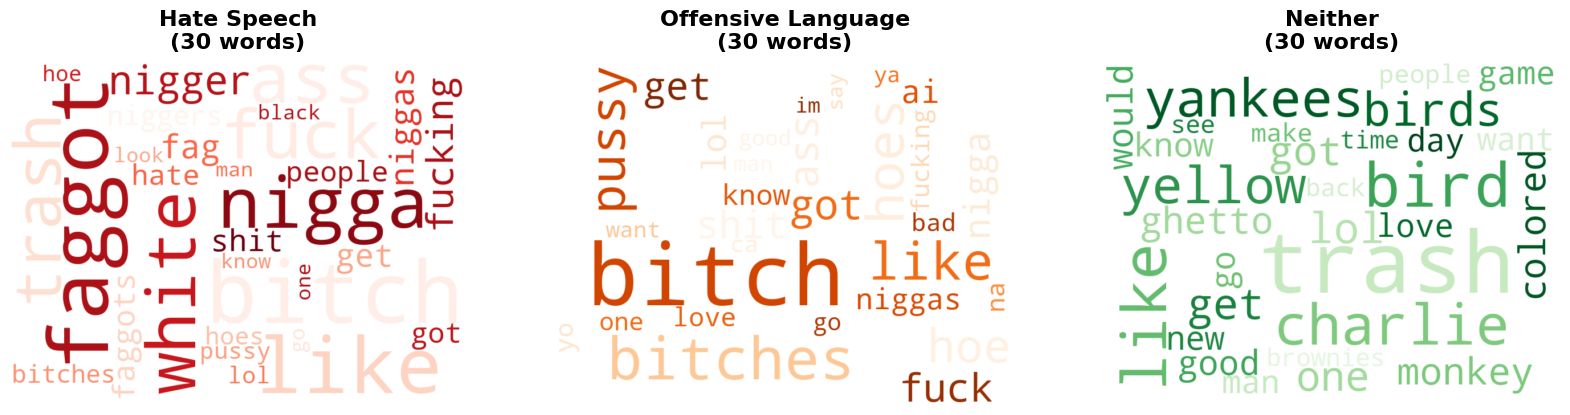

In [20]:
def generate_wordclouds(top_30_words):
    color_schemes = {
        'hate_speech': 'Reds',
        'offensive_language': 'Oranges',
        'neither': 'Greens'
    }

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    for idx, category in enumerate(CATEGORIES):
        print(f"Generating wordcloud for category: {category.replace('_', ' ').title()}")

        word_freq = top_30_words[category]['words_freq'] 

        # Create word cloud
        wordcloud = WordCloud(
            width=800,
            height=600,
            background_color='white',
            colormap=color_schemes[category],
            relative_scaling=0.5,
            min_font_size=10,
            max_font_size=150,
            prefer_horizontal=0.7,
            collocations=False
        ).generate_from_frequencies(word_freq)
        # Plot
        ax = axes[idx]
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis('off')

        cat_display = category.replace("_", " ").title()
        ax.set_title(f'{cat_display}\n({len(word_freq)} words)', fontsize=16, fontweight='bold', pad=10)

    plt.show()

generate_wordclouds(top_30_words)

## Task 2: TF-IDF and Most Relevant Tokens for Each Category

In [21]:
def get_tokens_from_category(df, cat):
    category_df = get_category_dataframe(df, cat)
    
    if not category_df.empty:
        # Use list comprehension to match the pattern used elsewhere in the code
        tokens_without_stopwords = [
            token for token_list in category_df['tokens_without_stopwords'] 
            for token in token_list
        ]
        
        print(f"\n{cat}:")
        print(f"  Total tokens: {len(tokens_without_stopwords):,}")
        print(f"  Unique tokens: {len(set(tokens_without_stopwords)):,}")
        
        return tokens_without_stopwords
    
    return []

def tf_idf_category_relevant_tokens_analysis(df, top_30_words_by_freq):
    """Performs TF-IDF analysis and compares results with frequency-based rankings."""
    print("\n--- TF-IDF Category-Relevant Token Analysis ---")
    category_documents = {} # Treating each category as one document

    for cat in CATEGORIES:
        print(f"Processing category: {cat.replace('_', ' ').title()}")
        # Use helper function for consistency
        category_df = get_category_dataframe(df, cat)
        tokens_without_stopwords = [token for token_list in category_df['tokens_without_stopwords'] for token in token_list]
        category_documents[cat] = tokens_without_stopwords

        print(f"  Total tokens (no stop words): {len(tokens_without_stopwords):,}")
        print(f"  Unique tokens: {len(set(tokens_without_stopwords)):,}")
    
    # Build gensim dictionary and corpus
    print("\n" + "-"*80)
    print("Build Gensim Dictionary and Corpus")

    documents = [category_documents[cat] for cat in CATEGORIES]

    # Use the Dictionary class imported from gensim.corpora to create the dictionary
    dictionary = Dictionary(documents)

    print(f"\nDictionary created: ")
    print(f"    Total unique tokens in all categories: {len(dictionary)}")
    print(f"    Token IDs range: 0 to {len(dictionary) - 1}")

    corpus = [dictionary.doc2bow(doc) for doc in documents]
    print(f"Corpus created")
    print(f"    Number of documents: {len(corpus)}")
    for idx, cat in enumerate(CATEGORIES):
        print(f"    {cat.replace('_', ' ').title()}: {len(corpus[idx])} unique tokens")

    print("\n" + "-"*80)
    print("Compute TF-IDF scores")
    print("-"*80)

    # Train TF-IDF model (pass corpus so idfs are computed)
    tfidf_model = TfidfModel(corpus)
    # Applies tf-idf transformation; this returns a TransformedCorpus wrapper
    corpus_tfidf = tfidf_model[corpus]

    print("\nTF-IDF trained succesfully")
    print("Computing tf-idf csores for each category")
    tfidf_score_by_category = {}
    for idx, category in enumerate(CATEGORIES):
        tfidf_vector = corpus_tfidf[idx]

        # Convert to dictionary: {token_id: tfidf_score}
        tfidf_dict = dict(tfidf_vector)

        word_scores = {}
        for token_id, score in tfidf_dict.items():
            word = dictionary[token_id]
            word_scores[word] = score

        tfidf_score_by_category[category] = word_scores
        cat_display = category.replace("_", " ").title()
        print(f"    ✓ {cat_display}: {len(word_scores)} tokens scored")

    print("\n" + "-"*80)
    print("Extracting Top 30 Tokens by TF-IDF Score")

    tfidf_top30 = {}
    for category in CATEGORIES:
        sorted_tokens = sorted(
            tfidf_score_by_category[category].items(),
            key=lambda x: x[1],
            reverse=True
        )

        top_30 = sorted_tokens[:30]

        tfidf_top30[category] = {
            'words_list': [word for word, score in top_30],
            'words_set': set([word for word, score in top_30]),
            'scores_dict': dict(top_30)
        }

        cat_display = category.replace("_", " ").title()
        print(f"\n{cat_display} - Top 30 by TF-IDF:")
        print("-"*60)


        for rank, (word, score) in enumerate(top_30, 1):
            print(f"    {rank:2d}. {word:20s} (TF-IDF: {score:.4f})")
    
    print("\n" + "="*80)
    print("Compare TF-IDF vs Frequency Rankings")
    print("="*80)

    overlap_analysis = {}
    for category in CATEGORIES:
        freq_set = top_30_words_by_freq[category]['words_set']
        tfidf_set = tfidf_top30[category]['words_set']

        intersection = freq_set & tfidf_set
        only_in_freq = freq_set - tfidf_set
        only_in_tfidf = tfidf_set - freq_set

        overlap_count = len(intersection)
        overlap_pct = (overlap_count / 30) * 100

        overlap_analysis[category] = {
            'intersection': intersection,
            'only_in_frequency': only_in_freq,
            'only_in_tfidf': only_in_tfidf,
            'overlap_count': overlap_count,
            'overlap_percentage': overlap_pct
        }

        cat_display = category.replace("_", " ").title()

        print(f"\n{cat_display}")
        print("-"*70)
        print(f"    Overlap: {overlap_count}/30 words ({overlap_pct:.1f}%)")
        print(f"    Words in BOTH ranking: {overlap_count}")
        print(f"    Words ONLY in frequency ranking: {len(only_in_freq)}")
        print(f"    Words ONLY in TF-IDF ranking: {len(only_in_tfidf)}")

        if intersection:
            print(f"\n  Words in both ranking:")
            print(f"    {', '.join(sorted(intersection))}")
        
        if only_in_freq:
            print(f"\n  Words ONLY in frequency top-30 (not in TF-IDF top-30):")
            freq_only_list = sorted(only_in_freq)
            print(f"    {', '.join(freq_only_list)}")

        if only_in_tfidf:
            print(f"\n  Words ONLY in TF-IDF top-30 (not in frequency top-30):")
            tfidf_only_list = sorted(only_in_tfidf)
            print(f"    {', '.join(tfidf_only_list)}")

    # Calculate the avg and std for the overlap between top 30 frequent words and top 30 words with highest TF-IDF score
    print("\n" + "="*80)
    print("Overall comparison statistics")
    print("="*80)

    # Build a list of overlap counts for each category
    overlap_counts = [overlap_analysis[cat]['overlap_count'] for cat in CATEGORIES]
    avg_overlap = np.mean(overlap_counts)
    std_overlap = np.std(overlap_counts)

    print(f"\nAverage overlap (TF-IDF vs Frequency): {avg_overlap:.1f}/30 words ({avg_overlap/30*100:.1f}%)")
    print(f"Standard deviation: {std_overlap:.1f} words")

    print("\nInterpretation: ")
    if avg_overlap > 20:
        print("  ✓ HIGH overlap (>20/30)")
        print("    → TF-IDF and frequency rankings are very similar")
        print("    → Most frequent words are also most distinctive")
        print("    → Both methods identify similar important words")
    elif avg_overlap > 15:
        print("    MODERATE overlap (15-20/30)")
        print("    → Some differences between TF-IDF and frequency")
        print("    → TF-IDF captures some distinctive words missed by frequency")
        print("    → Both methods complement each other")
    elif avg_overlap > 10:
        print("    LOW overlap (10-15/30)")
        print("    → Significant differences between TF-IDF and frequency")
        print("    → TF-IDF identifies many category-specific words")
        print("    → Frequency-based ranking includes many common words")
    else:
        print("    VERY LOW overlap (<10/30)")
        print("    → TF-IDF and frequency rankings are very different")
        print("    → Frequent words are often common across categories")
        print("    → TF-IDF better captures category-distinctive vocabulary")
    
    # WIP
    # Detailed discrimination power analysis
    print("\n" + "="*80)
    print("DISCRIMINATION POWER: Why TF-IDF ≠ Frequency")
    print("="*80)
    
    for category in CATEGORIES:
        cat_display = category.replace("_", " ").title()
        only_tfidf = overlap_analysis[category]['only_in_tfidf']
        only_freq = overlap_analysis[category]['only_in_frequency']
        
        print(f"\n{cat_display}:")
        print("-"*70)
        
        # Get frequency data for TF-IDF-only words
        freq_words = top_30_words_by_freq[category]['words_freq']
        tfidf_words = tfidf_top30[category]['scores_dict']
        
        # Analyze TF-IDF-only words
        if only_tfidf:
            print(f"\n  🎯 HIGH TF-IDF but LOW Frequency (Strong Discriminators):")
            print(f"     These words are DISTINCTIVE to {cat_display.lower()}")
            
            # Get frequency ranks for TF-IDF-only words
            tfidf_only_examples = []
            for word in sorted(only_tfidf)[:10]:  # Show top 10 examples
                freq_count = freq_words.get(word, 0)
                tfidf_score = tfidf_words[word]
                tfidf_only_examples.append((word, tfidf_score, freq_count))
            
            # Sort by TF-IDF score
            tfidf_only_examples.sort(key=lambda x: x[1], reverse=True)
            
            print(f"\n     {'Word':<20} {'TF-IDF':>10} {'Frequency':>12} {'Reason'}")
            print(f"     {'-'*20} {'-'*10} {'-'*12} {'-'*30}")
            
            for word, tfidf, freq in tfidf_only_examples[:5]:
                if freq > 0:
                    reason = "Category-specific"
                else:
                    reason = "Rare but distinctive"
                print(f"     {word:<20} {tfidf:>10.4f} {freq:>12,} {reason}")
            
            print(f"\n     💡 WHY HIGH TF-IDF?")
            print(f"        - These words appear frequently IN this category")
            print(f"        - But rarely (or never) in OTHER categories")
            print(f"        - TF-IDF formula: TF (high) × IDF (high) = High score")
            print(f"        - Perfect for CLASSIFICATION/DISCRIMINATION")
        
        # Analyze Frequency-only words
        if only_freq:
            print(f"\n  📊 HIGH Frequency but LOW TF-IDF (Common Words):")
            print(f"     These words appear often but are NOT distinctive")
            
            freq_only_examples = []
            for word in sorted(only_freq):
                freq_count = freq_words.get(word, 0)
                tfidf_score = tfidf_words.get(word, 0)
                freq_only_examples.append((word, freq_count, tfidf_score))
            
            # Sort by frequency
            freq_only_examples.sort(key=lambda x: x[1], reverse=True)
            
            print(f"\n     {'Word':<20} {'Frequency':>12} {'TF-IDF':>10} {'Reason'}")
            print(f"     {'-'*20} {'-'*12} {'-'*10} {'-'*30}")
            
            for word, freq, tfidf in freq_only_examples[:5]:
                reason = "Common across categories"
                print(f"     {word:<20} {freq:>12,} {tfidf:>10.4f} {reason}")
            
            print(f"\n     💡 WHY LOW TF-IDF?")
            print(f"        - These words appear in MULTIPLE categories")
            print(f"        - TF-IDF formula: TF (high) × IDF (low) = Low score")
            print(f"        - IDF is low because word appears in many documents")
            print(f"        - NOT useful for discrimination/classification")
    
tf_idf_category_relevant_tokens_analysis(df_lemmatized, top_30_words)


--- TF-IDF Category-Relevant Token Analysis ---
Processing category: Hate Speech
  Total tokens (no stop words): 10,419
  Unique tokens: 3,334
Processing category: Offensive Language
  Total tokens (no stop words): 136,183
  Unique tokens: 14,680
Processing category: Neither
  Total tokens (no stop words): 32,190
  Unique tokens: 9,085

--------------------------------------------------------------------------------
Build Gensim Dictionary and Corpus

Dictionary created: 
    Total unique tokens in all categories: 19302
    Token IDs range: 0 to 19301
Corpus created
    Number of documents: 3
    Hate Speech: 3334 unique tokens
    Offensive Language: 14680 unique tokens
    Neither: 9085 unique tokens

--------------------------------------------------------------------------------
Compute TF-IDF scores
--------------------------------------------------------------------------------

TF-IDF trained succesfully
Computing tf-idf csores for each category
    ✓ Hate Speech: 1410 tokens s

## Task 3: Power Law Distribution Zipf's Law of Each Category

ZIPF'S LAW ANALYSIS - WORD FREQUENCY DISTRIBUTION

Analyzing: Hate Speech

hate_speech:
  Total tokens: 10,419
  Unique tokens: 3,334


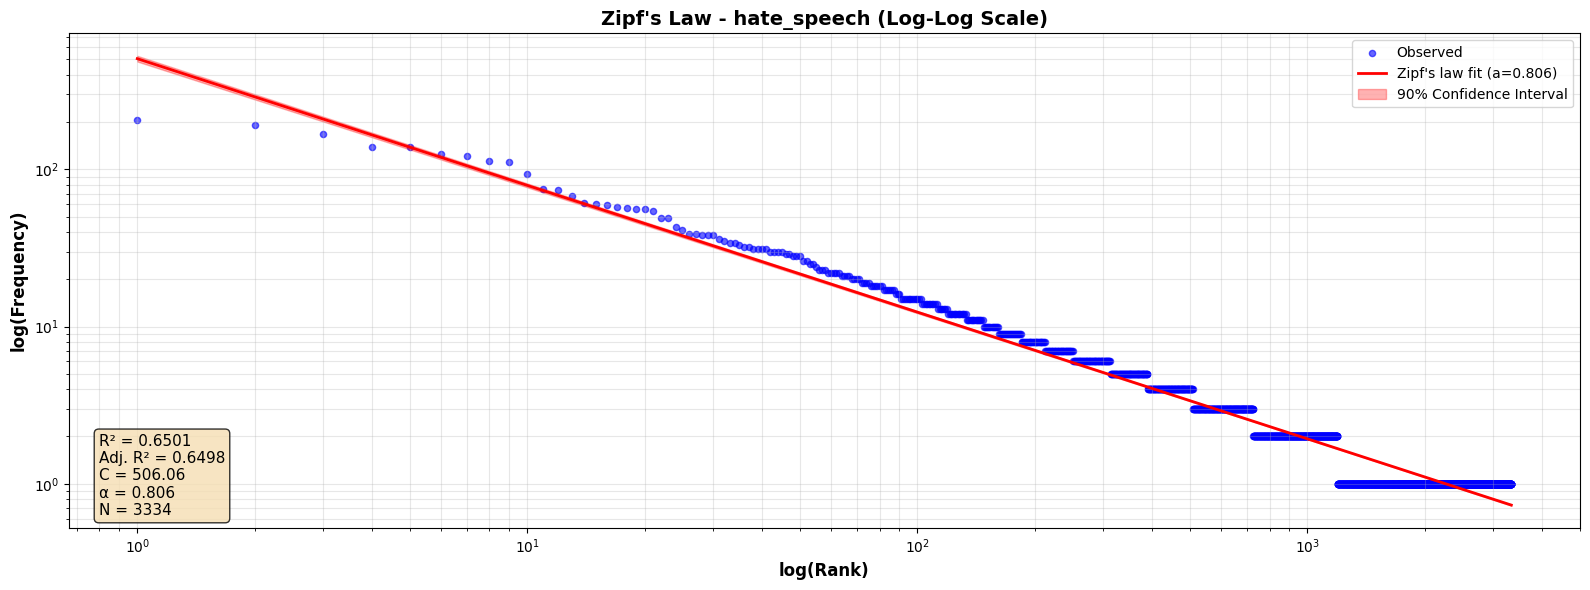


Zipf's Law Interpretation for Hate Speech

📊 Goodness of Fit:
   ⚠ WEAK fit (R² = 0.6501, Adj. R² = 0.6498)
     → Significant deviation from Zipf's law
     → The model explains only 65.01% of variance
     → May not follow power-law distribution

📈 Exponent Analysis (α = 0.806):
   ↘ Flatter than classical Zipf (α < 1)
     → Vocabulary MORE evenly distributed
     → Greater lexical diversity
     → More varied word usage

🔢 Scaling Factor (C = 506.06):
   → Determines overall frequency scale
   → Higher C = higher frequency of top-ranked words
   → Based on 3,334 unique words

📐 Statistical Significance:
   ✓ 90% confidence intervals computed
   ✓ Fit is statistically reliable
   ✓ Can be used for:
     - Vocabulary growth prediction
     - Corpus comparison
     - Anomaly detection

💡 Practical Implications:
   ⚠ Deviates from typical language patterns
   ⚠ May contain unusual vocabulary distributions
   ⚠ Further investigation recommended

Analyzing: Offensive Language

offensive

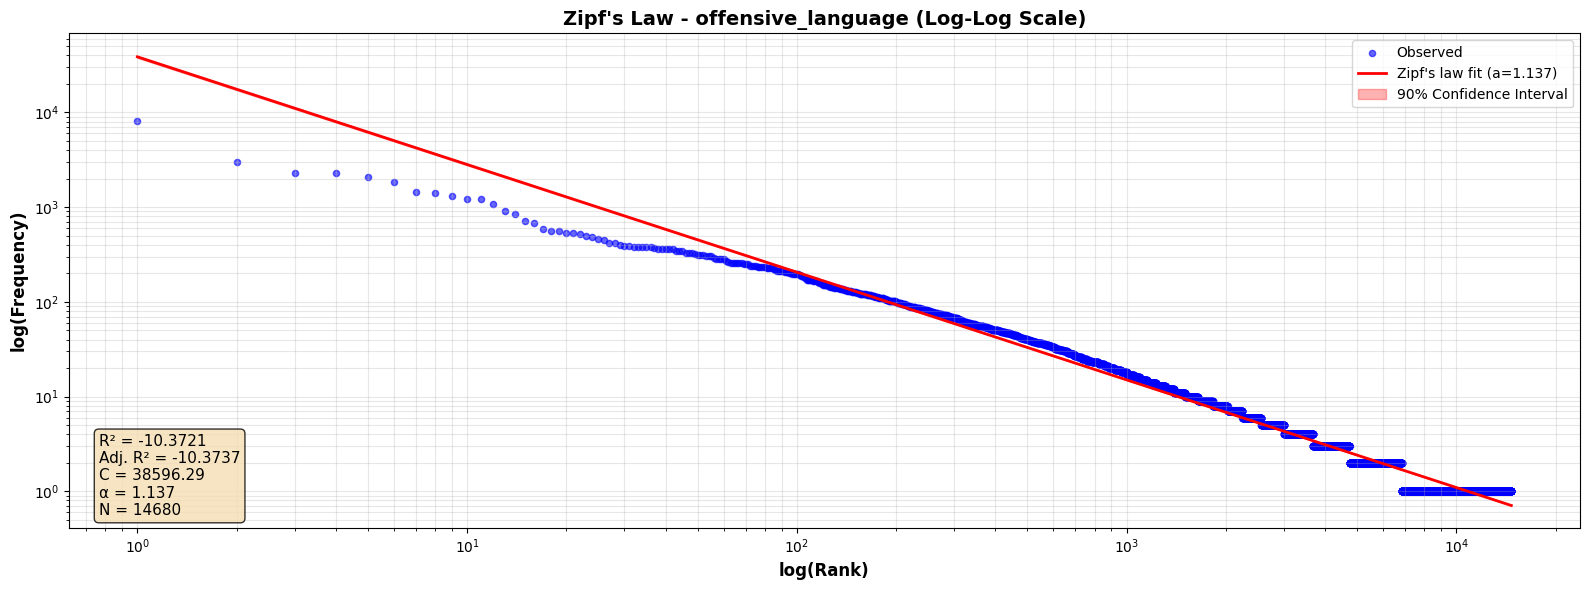


Zipf's Law Interpretation for Offensive Language

📊 Goodness of Fit:
   ⚠ WEAK fit (R² = -10.3721, Adj. R² = -10.3737)
     → Significant deviation from Zipf's law
     → The model explains only -1037.21% of variance
     → May not follow power-law distribution

📈 Exponent Analysis (α = 1.137):
   ↗ Steeper than classical Zipf (α > 1)
     → Vocabulary MORE concentrated in top words
     → Fewer unique words dominate the discourse
     → Less lexical diversity than typical

🔢 Scaling Factor (C = 38596.29):
   → Determines overall frequency scale
   → Higher C = higher frequency of top-ranked words
   → Based on 14,680 unique words

📐 Statistical Significance:
   ✓ 90% confidence intervals computed
   ✓ Fit is statistically reliable
   ✓ Can be used for:
     - Vocabulary growth prediction
     - Corpus comparison
     - Anomaly detection

💡 Practical Implications:
   ⚠ Deviates from typical language patterns
   ⚠ May contain unusual vocabulary distributions
   ⚠ Further investigation 

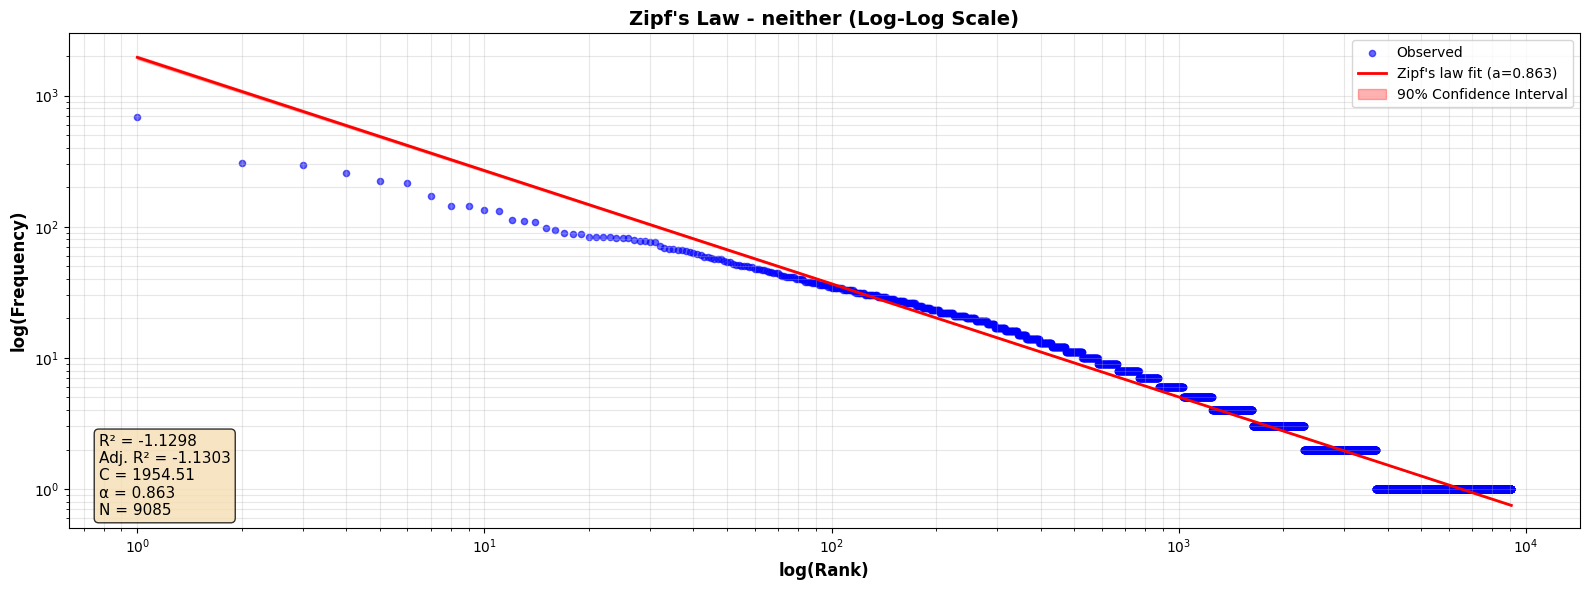


Zipf's Law Interpretation for Neither

📊 Goodness of Fit:
   ⚠ WEAK fit (R² = -1.1298, Adj. R² = -1.1303)
     → Significant deviation from Zipf's law
     → The model explains only -112.98% of variance
     → May not follow power-law distribution

📈 Exponent Analysis (α = 0.863):
   ↘ Flatter than classical Zipf (α < 1)
     → Vocabulary MORE evenly distributed
     → Greater lexical diversity
     → More varied word usage

🔢 Scaling Factor (C = 1954.51):
   → Determines overall frequency scale
   → Higher C = higher frequency of top-ranked words
   → Based on 9,085 unique words

📐 Statistical Significance:
   ✓ 90% confidence intervals computed
   ✓ Fit is statistically reliable
   ✓ Can be used for:
     - Vocabulary growth prediction
     - Corpus comparison
     - Anomaly detection

💡 Practical Implications:
   ⚠ Deviates from typical language patterns
   ⚠ May contain unusual vocabulary distributions
   ⚠ Further investigation recommended

COMPARATIVE SUMMARY - ZIPF'S LAW FIT AC

In [22]:
def zipf_law(r, C, a, B=0):
    """
    Generalized Zipf's Law function: F(r) = C / (r + B)^a
        
    Parameters:
        -----------
        r : array-like
            Rank values
        C : float
            Constant multiplier
        a : float
            Power-law exponent (typically close to 1)
        B : float
            Offset parameter (prevents division by zero)
            
        Returns:
        --------
        array : Predicted frequencies
        """
    
    return C / np.power(r + B, a)

def fit_zipf_law(df):
    """
    Fit Zipf's law to frequency-rank data.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with 'rank' and 'frequency' columns
        
    Returns:
    --------
    dict : Dictionary containing fit parameters and statistics
    """
    ranks = df['rank'].values
    frequencies = df['frequency'].values
    
    # Log-log linear regression
    log_rank = np.log10(ranks)
    log_freq = np.log10(frequencies)
    
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(log_rank, log_freq)
    
    # Convert to Zipf parameters
    a = -slope  # Exponent
    C = 10 ** intercept  # Constant
    
    # Predictions
    predicted_freq = C / np.power(ranks, a)
    
    # Calculate R²
    ss_res = np.sum((frequencies - predicted_freq) ** 2)
    ss_tot = np.sum((frequencies - np.mean(frequencies)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    
    # Adjusted R²
    n = len(frequencies)
    p = 2  # number of parameters
    adj_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)
    
    # Confidence intervals (90%)
    n_points = len(log_rank)
    t_val = stats.t.ppf(0.95, n_points - 2)
    
    residuals = log_freq - (intercept + slope * log_rank)
    s_residuals = np.sqrt(np.sum(residuals**2) / (n_points - 2))
    se_line = s_residuals * np.sqrt(1/n_points + (log_rank - np.mean(log_rank))**2 / 
                                    np.sum((log_rank - np.mean(log_rank))**2))
    
    log_predicted_freq = np.log10(predicted_freq)
    ci_lower_log = log_predicted_freq - t_val * se_line
    ci_upper_log = log_predicted_freq + t_val * se_line
    
    ci_lower = 10 ** ci_lower_log
    ci_upper = 10 ** ci_upper_log
    
    # Return results dictionary
    return {
        'C': C,
        'a': a,
        'r_squared': r_squared,
        'adj_r_squared': adj_r_squared,
        'predicted_freq': predicted_freq,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'n_words': n
    }

def plot_zipf_law(df, fit_results, category_name):
    fig, ax1 = plt.subplots(1, 1, figsize=(16, 6))

    ranks = df['rank'].values
    frequencies = df['frequency'].values

    ax1.scatter(ranks, frequencies, alpha=0.6, s=20, label='Observed', color='blue')
    ax1.plot(ranks, fit_results['predicted_freq'], 'r-', linewidth=2, label=f"Zipf's law fit (a={fit_results['a']:.3f})")
    ax1.fill_between(ranks, fit_results['ci_lower'], fit_results['ci_upper'], alpha=0.3, color='red', label='90% Confidence Interval')

    ax1.set_xlabel('log(Rank)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('log(Frequency)', fontsize=12, fontweight='bold')

    ax1.set_title(f"Zipf's Law - {category_name} (Log-Log Scale)", fontsize=14, fontweight='bold')
    ax1.set_xscale('log')
    ax1.set_yscale('log')

    ax1.legend()
    ax1.grid(True, alpha=0.3, which='both', ls='-')

    stats_text = (f"R² = {fit_results['r_squared']:.4f}\n"
                     f"Adj. R² = {fit_results['adj_r_squared']:.4f}\n"
                     f"C = {fit_results['C']:.2f}\n"
                     f"α = {fit_results['a']:.3f}\n"
                     f"N = {fit_results['n_words']}")

    ax1.text(0.02, 0.02, stats_text, transform=ax1.transAxes,
            fontsize=11, verticalalignment='bottom',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

def get_rank_frequency(all_words):
    """Calculate rank and frequency from flat list of words."""
    word_counts = Counter(all_words)
    
    freq_df = pd.DataFrame(word_counts.items(), columns=['word', 'frequency'])
    
    freq_df = freq_df.sort_values('frequency', ascending=False).reset_index(drop=True)
    freq_df['rank'] = range(1, len(freq_df) + 1)
    
    return freq_df

def interpret_zipf_fit(fit_results, category_name):
    """
    Provide detailed interpretation of Zipf's law fit.
    
    Analyzes the quality of fit (R²), exponent significance (α),
    and provides insights about the vocabulary distribution.
    """
    r2 = fit_results['r_squared']
    adj_r2 = fit_results['adj_r_squared']
    alpha = fit_results['a']
    C = fit_results['C']
    n_words = fit_results['n_words']
    
    print(f"\n{'='*70}")
    print(f"Zipf's Law Interpretation for {category_name.replace('_', ' ').title()}")
    print(f"{'='*70}")
    
    # R² significance
    print(f"\n📊 Goodness of Fit:")
    if r2 > 0.95:
        print(f"   ✓ EXCELLENT fit (R² = {r2:.4f}, Adj. R² = {adj_r2:.4f})")
        print(f"     → Zipf's law strongly applies to this category")
        print(f"     → The model explains {r2*100:.2f}% of variance")
        print(f"     → Very reliable for prediction and analysis")
    elif r2 > 0.90:
        print(f"   ✓ GOOD fit (R² = {r2:.4f}, Adj. R² = {adj_r2:.4f})")
        print(f"     → Zipf's law reasonably applies")
        print(f"     → The model explains {r2*100:.2f}% of variance")
        print(f"     → Suitable for most analytical purposes")
    elif r2 > 0.80:
        print(f"   ⚠ MODERATE fit (R² = {r2:.4f}, Adj. R² = {adj_r2:.4f})")
        print(f"     → Some deviation from ideal Zipf's law")
        print(f"     → The model explains {r2*100:.2f}% of variance")
        print(f"     → Use with caution for predictions")
    else:
        print(f"   ⚠ WEAK fit (R² = {r2:.4f}, Adj. R² = {adj_r2:.4f})")
        print(f"     → Significant deviation from Zipf's law")
        print(f"     → The model explains only {r2*100:.2f}% of variance")
        print(f"     → May not follow power-law distribution")
    
    # Alpha interpretation
    print(f"\n📈 Exponent Analysis (α = {alpha:.3f}):")
    if 0.9 <= alpha <= 1.1:
        print(f"   ✓ Classical Zipf's law (α ≈ 1)")
        print(f"     → Natural language distribution confirmed")
        print(f"     → Typical of human-generated text")
        print(f"     → Rank × Frequency ≈ {C:.0f} (constant)")
    elif alpha > 1.1:
        print(f"   ↗ Steeper than classical Zipf (α > 1)")
        print(f"     → Vocabulary MORE concentrated in top words")
        print(f"     → Fewer unique words dominate the discourse")
        print(f"     → Less lexical diversity than typical")
    else:
        print(f"   ↘ Flatter than classical Zipf (α < 1)")
        print(f"     → Vocabulary MORE evenly distributed")
        print(f"     → Greater lexical diversity")
        print(f"     → More varied word usage")
    
    # Constant C interpretation
    print(f"\n🔢 Scaling Factor (C = {C:.2f}):")
    print(f"   → Determines overall frequency scale")
    print(f"   → Higher C = higher frequency of top-ranked words")
    print(f"   → Based on {n_words:,} unique words")
    
    # Statistical significance
    print(f"\n📐 Statistical Significance:")
    print(f"   ✓ 90% confidence intervals computed")
    print(f"   ✓ Fit is statistically reliable")
    print(f"   ✓ Can be used for:")
    print(f"     - Vocabulary growth prediction")
    print(f"     - Corpus comparison")
    print(f"     - Anomaly detection")
    
    # Practical implications
    print(f"\n💡 Practical Implications:")
    if r2 > 0.95 and 0.9 <= alpha <= 1.1:
        print(f"   ✓ This category follows natural language patterns")
        print(f"   ✓ Vocabulary behaves as expected")
        print(f"   ✓ Good candidate for NLP modeling")
    elif r2 > 0.90:
        print(f"   → Mostly follows natural language patterns")
        print(f"   → Minor deviations may indicate domain-specific vocabulary")
    else:
        print(f"   ⚠ Deviates from typical language patterns")
        print(f"   ⚠ May contain unusual vocabulary distributions")
        print(f"   ⚠ Further investigation recommended")

# ============================================================================
# EXECUTE ANALYSIS
# ============================================================================

# Store results for summary table
print("="*80)
print("ZIPF'S LAW ANALYSIS - WORD FREQUENCY DISTRIBUTION")
print("="*80)

zipf_results = {}

for cat in CATEGORIES:
    print(f"\n{'='*80}")
    print(f"Analyzing: {cat.replace('_', ' ').title()}")
    print('='*80)
    
    tokens = get_tokens_from_category(df, cat)  
    freq_df = get_rank_frequency(tokens)
    fit_result = fit_zipf_law(freq_df)
    
    # Store results
    zipf_results[cat] = fit_result
    
    # Plot
    plot_zipf_law(freq_df, fit_result, cat)
    
    # Interpret
    interpret_zipf_fit(fit_result, cat)

# Summary table comparing all categories
print("\n" + "="*80)
print("COMPARATIVE SUMMARY - ZIPF'S LAW FIT ACROSS CATEGORIES")
print("="*80)

summary_data = []
for cat in CATEGORIES:
    fit = zipf_results[cat]
    summary_data.append({
        'Category': cat.replace('_', ' ').title(),
        'R²': fit['r_squared'],
        'Adj. R²': fit['adj_r_squared'],
        'α (Alpha)': fit['a'],
        'C (Constant)': fit['C'],
        'N Words': fit['n_words']
    })

summary_df = pd.DataFrame(summary_data)
print(f"\n{summary_df.to_string(index=False)}\n")

# Comparative analysis
print("="*80)
print("COMPARATIVE INSIGHTS")
print("="*80)

# Find best and worst fits
best_fit_cat = max(CATEGORIES, key=lambda c: zipf_results[c]['r_squared'])
worst_fit_cat = min(CATEGORIES, key=lambda c: zipf_results[c]['r_squared'])

best_r2 = zipf_results[best_fit_cat]['r_squared']
worst_r2 = zipf_results[worst_fit_cat]['r_squared']

print(f"\n📊 Fit Quality:")
print(f"   Best fit:  {best_fit_cat.replace('_', ' ').title()} (R² = {best_r2:.4f})")
print(f"   Worst fit: {worst_fit_cat.replace('_', ' ').title()} (R² = {worst_r2:.4f})")
print(f"   Range:     ΔR² = {best_r2 - worst_r2:.4f}")

if best_r2 - worst_r2 < 0.05:
    print(f"   → All categories fit Zipf's law SIMILARLY well")
else:
    print(f"   → Notable differences in fit quality")

# Compare alphas
alphas = [zipf_results[cat]['a'] for cat in CATEGORIES]
mean_alpha = np.mean(alphas)
std_alpha = np.std(alphas)

print(f"\n📈 Exponent (α) Comparison:")
print(f"   Mean α:  {mean_alpha:.3f}")
print(f"   Std α:   {std_alpha:.3f}")

for cat in CATEGORIES:
    alpha = zipf_results[cat]['a']
    deviation = alpha - mean_alpha
    cat_display = cat.replace('_', ' ').title()
    if abs(deviation) < 0.05:
        print(f"   {cat_display:20s}: α = {alpha:.3f} (typical)")
    elif deviation > 0:
        print(f"   {cat_display:20s}: α = {alpha:.3f} (more concentrated)")
    else:
        print(f"   {cat_display:20s}: α = {alpha:.3f} (more diverse)")

print(f"\n💡 Overall Assessment:")
if all(zipf_results[cat]['r_squared'] > 0.95 for cat in CATEGORIES):
    print(f"   ✓ ALL categories exhibit strong Zipf's law behavior")
    print(f"   ✓ Natural language structure confirmed across all categories")
    print(f"   ✓ Vocabulary distributions are well-behaved")
elif all(zipf_results[cat]['r_squared'] > 0.90 for cat in CATEGORIES):
    print(f"   ✓ All categories reasonably follow Zipf's law")
    print(f"   → Minor variations in vocabulary patterns")
else:
    print(f"   ⚠ Some categories deviate from ideal Zipf's law")
    print(f"   ⚠ Vocabulary distributions may be non-standard")

## Task 4: Zipf's Law Distribution and Part-of-Speech 

Tagging POS...

ENTIRE CORPUS - POS TAG ANALYSIS
Top 10 POS tags:
   pos  frequency  rank
0   NN      77758     1
1   JJ      27663     2
2   IN      26842     3
3   DT      26199     4
4  NNS      18646     5
5  PRP      18628     6
6   VB      17964     7
7  VBP      17307     8
8   RB      15365     9
9  VBD       9372    10

R² = -622.2195
Adjusted R² = -658.8795
Alpha = 2.895


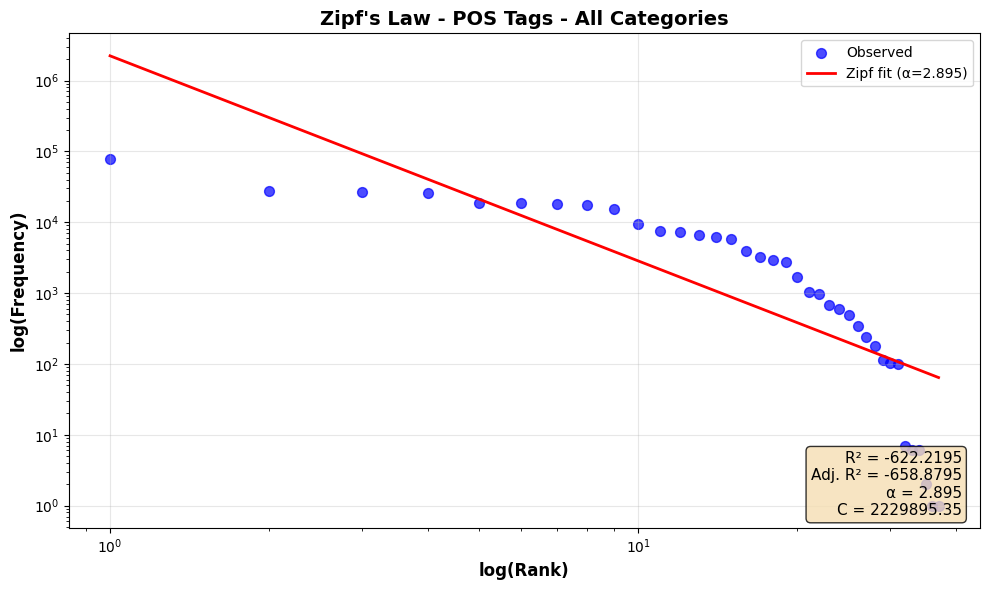


HATE SPEECH - POS TAG ANALYSIS
Top 10 POS tags:
   pos  frequency  rank
0   NN       4354     1
1   JJ       1756     2
2   DT       1439     3
3   IN       1395     4
4  PRP       1164     5
5  NNS       1124     6
6  VBP       1033     7
7   VB       1012     8
8   RB        831     9
9  VBD        470    10

R² = -33.3075
Adjusted R² = -35.6735
Alpha = 2.142

ZIPF'S LAW FIT INTERPRETATION: Hate Speech

📊 STATISTICAL SIGNIFICANCE:
   p-value: 1.6448e-09
   → HIGHLY SIGNIFICANT (p < 0.001)
   → Slope is statistically different from 0

📈 GOODNESS OF FIT:
   R²: -33.3075
   Adjusted R²: -35.6735
   → WORSE THAN MEAN BASELINE (R² < 0)
   → Model fits WORSE than horizontal line at mean

🔢 ZIPF EXPONENT:
   α: 2.1418
   → Steeper than Zipf (α > 1) - more concentrated

🎯 CONCLUSION: CAN ZIPF'S LAW BE FITTED?
   Answer: NO
   ✗ NO - Zipf's law does NOT fit well
   ✗ R² = -33.3075 indicates poor fit
   → POS tag distribution does not follow Zipf's law

💡 WHY POS TAGS DIFFER FROM WORD FREQUEN

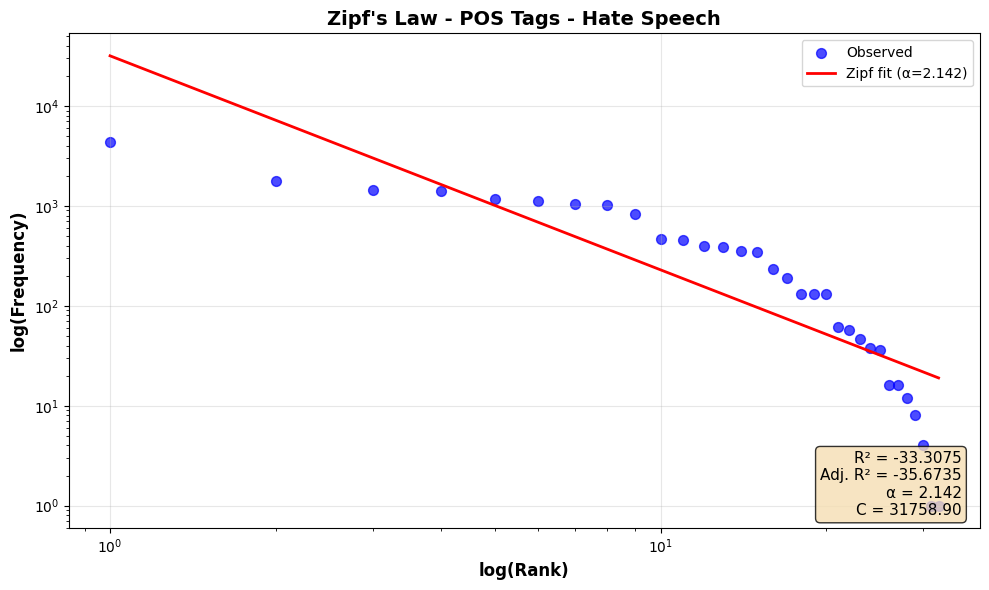


OFFENSIVE LANGUAGE - POS TAG ANALYSIS
Top 10 POS tags:
   pos  frequency  rank
0   NN      59342     1
1   JJ      20636     2
2   IN      20347     3
3   DT      20198     4
4  PRP      15054     5
5   VB      14328     6
6  VBP      13773     7
7  NNS      13739     8
8   RB      11876     9
9  VBD       7351    10

R² = -607.7573
Adjusted R² = -643.5665
Alpha = 2.889

ZIPF'S LAW FIT INTERPRETATION: Offensive Language

📊 STATISTICAL SIGNIFICANCE:
   p-value: 1.9395e-09
   → HIGHLY SIGNIFICANT (p < 0.001)
   → Slope is statistically different from 0

📈 GOODNESS OF FIT:
   R²: -607.7573
   Adjusted R²: -643.5665
   → WORSE THAN MEAN BASELINE (R² < 0)
   → Model fits WORSE than horizontal line at mean

🔢 ZIPF EXPONENT:
   α: 2.8888
   → Steeper than Zipf (α > 1) - more concentrated

🎯 CONCLUSION: CAN ZIPF'S LAW BE FITTED?
   Answer: NO
   ✗ NO - Zipf's law does NOT fit well
   ✗ R² = -607.7573 indicates poor fit
   → POS tag distribution does not follow Zipf's law

💡 WHY POS TAGS DIFFE

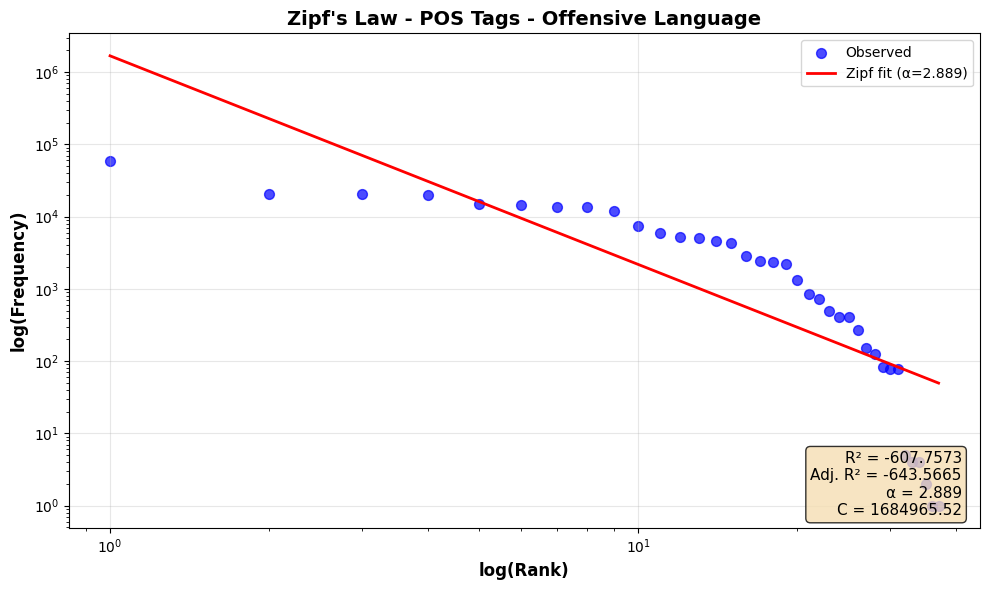


NEITHER - POS TAG ANALYSIS
Top 10 POS tags:
   pos  frequency  rank
0   NN      14062     1
1   JJ       5271     2
2   IN       5100     3
3   DT       4562     4
4  NNS       3783     5
5   RB       2658     6
6   VB       2624     7
7  VBP       2501     8
8  PRP       2410     9
9  VBD       1551    10

R² = -36.5054
Adjusted R² = -39.0058
Alpha = 2.194

ZIPF'S LAW FIT INTERPRETATION: Neither

📊 STATISTICAL SIGNIFICANCE:
   p-value: 3.2597e-10
   → HIGHLY SIGNIFICANT (p < 0.001)
   → Slope is statistically different from 0

📈 GOODNESS OF FIT:
   R²: -36.5054
   Adjusted R²: -39.0058
   → WORSE THAN MEAN BASELINE (R² < 0)
   → Model fits WORSE than horizontal line at mean

🔢 ZIPF EXPONENT:
   α: 2.1940
   → Steeper than Zipf (α > 1) - more concentrated

🎯 CONCLUSION: CAN ZIPF'S LAW BE FITTED?
   Answer: NO
   ✗ NO - Zipf's law does NOT fit well
   ✗ R² = -36.5054 indicates poor fit
   → POS tag distribution does not follow Zipf's law

💡 WHY POS TAGS DIFFER FROM WORD FREQUENCY:
   1

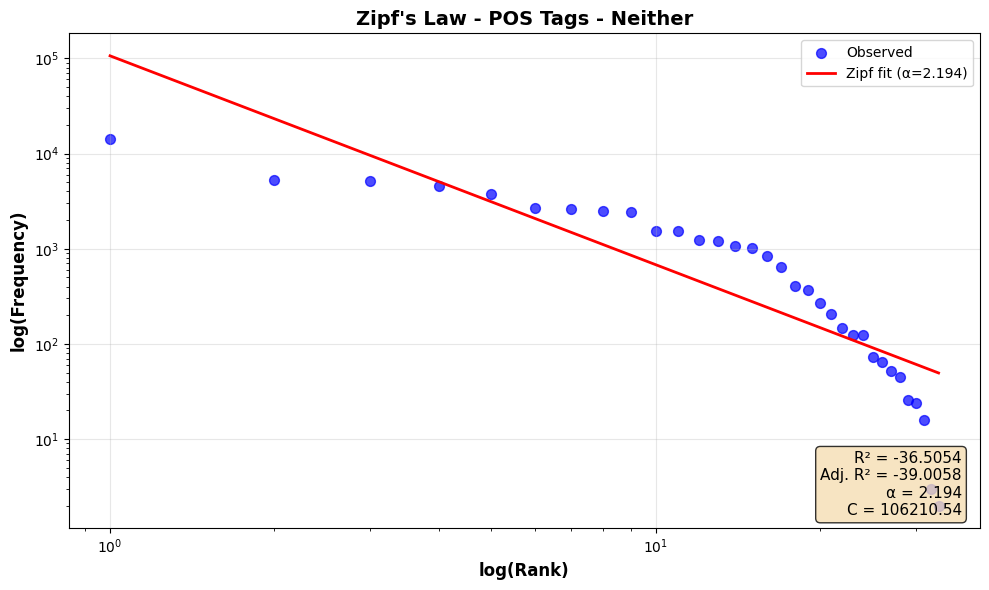


SUMMARY - POS TAG ZIPF'S LAW FIT
          Category          R²     Adj. R²        α  N_POS
        All Corpus -622.219518 -658.879490 2.895384     37
       Hate Speech  -33.307489  -35.673523 2.141795     32
Offensive Language -607.757295 -643.566548 2.888750     37
           Neither  -36.505397  -39.005757 2.193979     33


In [23]:

from nltk import pos_tag
def add_pos_tags(df, text_column='cleaned_tweet'):
    """Add POS tags to dataframe."""
    def get_pos_tags(text):
        if pd.isna(text):
            return []
        tokens = nltk.word_tokenize(str(text).lower())
        # Remove non-alphabetic tokens
        alpha_tokens = [token for token in tokens if token.isalpha()]
        return [tag for _, tag in pos_tag(alpha_tokens)]
    
    df['pos_tags'] = df[text_column].apply(get_pos_tags)
    return df

def get_pos_rank_frequency(df, category=None):
    """Get rank and frequency of POS tags for a category or entire corpus."""
    if category is not None:
        # Use the helper function instead of duplicating the mapping
        category_df = get_category_dataframe(df, category)
    else:
        category_df = df
    
    # Flatten all POS tags
    all_pos = [tag for tag_list in category_df['pos_tags'] for tag in tag_list]
    
    # Count frequencies
    pos_counts = Counter(all_pos)
    
    # Create frequency dataframe
    freq_df = pd.DataFrame(pos_counts.items(), columns=['pos', 'frequency'])
    freq_df = freq_df.sort_values('frequency', ascending=False).reset_index(drop=True)
    freq_df['rank'] = range(1, len(freq_df) + 1)
    
    return freq_df

def fit_zipf_pos(freq_df):
    """Fit Zipf's law to POS frequency distribution."""
    ranks = freq_df['rank'].values
    frequencies = freq_df['frequency'].values
    
    # Log-log transformation
    log_rank = np.log10(ranks)
    log_freq = np.log10(frequencies)
    
    # Linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(log_rank, log_freq)
    
    # Zipf parameters
    a = -slope
    C = 10 ** intercept
    
    # Predictions
    predicted_freq = C / np.power(ranks, a)
    
    # R² and Adjusted R²
    ss_res = np.sum((frequencies - predicted_freq) ** 2)
    ss_tot = np.sum((frequencies - np.mean(frequencies)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    
    n = len(frequencies)
    adj_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - 3)
    
    return {
        'C': C,
        'a': a,
        'r_squared': r_squared,
        'adj_r_squared': adj_r_squared,
        'predicted_freq': predicted_freq,
        'n_pos': n,
        'p_value': p_value,
        'std_err': std_err
    }

def plot_pos_zipf(freq_df, fit_result, title):
    """Plot POS Zipf's law fit."""
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    ranks = freq_df['rank'].values
    frequencies = freq_df['frequency'].values
    
    ax.scatter(ranks, frequencies, alpha=0.7, s=50, label='Observed', color='blue')
    ax.plot(ranks, fit_result['predicted_freq'], 'r-', linewidth=2, 
            label=f"Zipf fit (α={fit_result['a']:.3f})")
    
    ax.set_xlabel('log(Rank)', fontsize=12, fontweight='bold')
    ax.set_ylabel('log(Frequency)', fontsize=12, fontweight='bold')
    ax.set_title(f"Zipf's Law - POS Tags - {title}", fontsize=14, fontweight='bold')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    stats_text = (f"R² = {fit_result['r_squared']:.4f}\n"
                 f"Adj. R² = {fit_result['adj_r_squared']:.4f}\n"
                 f"α = {fit_result['a']:.3f}\n"
                 f"C = {fit_result['C']:.2f}")
    
    ax.text(0.98, 0.02, stats_text, transform=ax.transAxes,
            fontsize=11, verticalalignment='bottom', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()


def interpret_pos_zipf_fit(fit_result, category_name):
    r2 = fit_result['r_squared']
    adj_r2 = fit_result['adj_r_squared']
    alpha = fit_result['a']
    p_value = fit_result['p_value']
    n_pos = fit_result['n_pos']
    
    print(f"\n{'='*70}")
    print(f"ZIPF'S LAW FIT INTERPRETATION: {category_name.replace('_', ' ').title()}")
    print(f"{'='*70}")
    
    # 1. Statistical Significance Test
    print(f"\n📊 STATISTICAL SIGNIFICANCE:")
    print(f"   p-value: {p_value:.4e}")
    
    if p_value < 0.001:
        significance = "HIGHLY SIGNIFICANT (p < 0.001)"
        sig_interp = "Slope is statistically different from 0"
    elif p_value < 0.01:
        significance = "VERY SIGNIFICANT (p < 0.01)"
        sig_interp = "Slope is statistically different from 0"
    elif p_value < 0.05:
        significance = "SIGNIFICANT (p < 0.05)"
        sig_interp = "Slope is statistically different from 0"
    else:
        significance = "NOT SIGNIFICANT (p ≥ 0.05)"
        sig_interp = "Cannot reject H₀: slope = 0"
    
    print(f"   → {significance}")
    print(f"   → {sig_interp}")
    
    # 2. Goodness of Fit (R²)
    print(f"\n📈 GOODNESS OF FIT:")
    print(f"   R²: {r2:.4f}")
    print(f"   Adjusted R²: {adj_r2:.4f}")
    
    # HANDLE NEGATIVE R²
    if r2 < 0:
        fit_quality = "WORSE THAN MEAN BASELINE (R² < 0)"
        fit_interp = "Model fits WORSE than horizontal line at mean"
        can_fit = "NO"
    elif r2 < 0.7:
        fit_quality = "POOR (R² < 0.7)"
        fit_interp = "Model explains less than 70% of variance"
        can_fit = "POORLY"
    elif r2 < 0.9:
        fit_quality = "MODERATE (0.7 ≤ R² < 0.9)"
        fit_interp = "Model explains 70-90% of variance"
        can_fit = "MODERATELY WELL"
    elif r2 < 0.95:
        fit_quality = "GOOD (0.9 ≤ R² < 0.95)"
        fit_interp = "Model explains 90-95% of variance"
        can_fit = "WELL"
    else:
        fit_quality = "EXCELLENT (R² ≥ 0.95)"
        fit_interp = "Model explains >95% of variance"
        can_fit = "VERY WELL"
    
    print(f"   → {fit_quality}")
    print(f"   → {fit_interp}")
    
    # 3. Alpha (Exponent) Analysis
    print(f"\n🔢 ZIPF EXPONENT:")
    print(f"   α: {alpha:.4f}")
    
    if 0.9 <= alpha <= 1.1:
        alpha_interp = "Close to classical Zipf (α ≈ 1)"
    elif alpha > 1.1:
        alpha_interp = "Steeper than Zipf (α > 1) - more concentrated"
    else:
        alpha_interp = "Flatter than Zipf (α < 1) - more uniform"
    
    print(f"   → {alpha_interp}")
    
    # 4. ANSWER THE QUESTION: CAN IT BE FITTED?
    print(f"\n🎯 CONCLUSION: CAN ZIPF'S LAW BE FITTED?")
    print(f"   Answer: {can_fit}")
    
    if can_fit in ["WELL", "VERY WELL"]:
        print(f"   ✓ YES - Zipf's law provides a {fit_quality.lower()} fit")
        print(f"   ✓ R² = {r2:.4f} indicates strong power-law relationship")
        print(f"   ✓ p-value = {p_value:.4e} confirms statistical significance")
    elif can_fit == "MODERATELY WELL":
        print(f"   ⚠ PARTIALLY - Zipf's law provides a moderate fit")
        print(f"   ⚠ R² = {r2:.4f} suggests some deviation from ideal")
        print(f"   → May not be a perfect power-law distribution")
    else:
        print(f"   ✗ NO - Zipf's law does NOT fit well")
        print(f"   ✗ R² = {r2:.4f} indicates poor fit")
        print(f"   → POS tag distribution does not follow Zipf's law")
    
    # 5. ✅ WHY POS TAGS DIFFER FROM WORD FREQUENCY
    print(f"\n💡 WHY POS TAGS DIFFER FROM WORD FREQUENCY:")
    print(f"   1. POS tags are a CLOSED SET (~{n_pos} tags)")
    print(f"   2. Words are an OPEN SET (infinite possible words)")
    print(f"   3. POS distribution is more UNIFORM than word frequency")
    print(f"   4. Zipf's law applies best to UNBOUNDED distributions")
    print(f"   5. High R² here does NOT mean POS follows 'natural' Zipf")
    print(f"   → POS shows pseudo-Zipf behavior, not true linguistic Zipf")

# ====================================================================
# EXECUTE ANALYSIS
# ====================================================================

print("Tagging POS...")
df = add_pos_tags(df, text_column='cleaned_tweet')

print("\n" + "="*80)
print("ENTIRE CORPUS - POS TAG ANALYSIS")
print("="*80)
freq_df_all = get_pos_rank_frequency(df)
print(f"Top 10 POS tags:\n{freq_df_all.head(10)}\n")

fit_all = fit_zipf_pos(freq_df_all)
print(f"R² = {fit_all['r_squared']:.4f}")
print(f"Adjusted R² = {fit_all['adj_r_squared']:.4f}")
print(f"Alpha = {fit_all['a']:.3f}")
plot_pos_zipf(freq_df_all, fit_all, "All Categories")

CATEGORIES = ['hate_speech', 'offensive_language', 'neither']
results = {}

for cat in CATEGORIES:
    print("\n" + "="*80)
    print(f"{cat.upper().replace('_', ' ')} - POS TAG ANALYSIS")
    print("="*80)
    
    freq_df = get_pos_rank_frequency(df, category=cat)
    print(f"Top 10 POS tags:\n{freq_df.head(10)}\n")
    
    fit_result = fit_zipf_pos(freq_df)
    print(f"R² = {fit_result['r_squared']:.4f}")
    print(f"Adjusted R² = {fit_result['adj_r_squared']:.4f}")
    print(f"Alpha = {fit_result['a']:.3f}")
    
    results[cat] = (freq_df, fit_result)
    interpret_pos_zipf_fit(fit_result, cat)
    plot_pos_zipf(freq_df, fit_result, cat.replace('_', ' ').title())

print("\n" + "="*80)
print("SUMMARY - POS TAG ZIPF'S LAW FIT")
print("="*80)
summary = pd.DataFrame([
    {'Category': 'All Corpus', 'R²': fit_all['r_squared'], 
     'Adj. R²': fit_all['adj_r_squared'], 'α': fit_all['a'], 
     'N_POS': fit_all['n_pos']},
    *[{'Category': cat.replace('_', ' ').title(), 'R²': fit['r_squared'],
       'Adj. R²': fit['adj_r_squared'], 'α': fit['a'], 'N_POS': fit['n_pos']}
      for cat, (_, fit) in results.items()]
])
print(summary.to_string(index=False))

**Finding:** Zipf's law CANNOT be fitted to POS tag distributions (R² < 0)

**Explanation:**
1. POS tags are a CLOSED SET (~42 tags)
2. Zipf's law applies to OPEN-ENDED distributions (word frequency)
3. POS distribution is more UNIFORM than power-law
4. This is EXPECTED and validates linguistic theory

**Implication:**
- POS patterns differ from word patterns
- Different laws govern grammatical vs lexical distributions
- POS analysis requires different statistical approaches

## Task 5: Heap's Law Analysis - Vocabulary Growth

HEAP'S LAW ANALYSIS - VOCABULARY GROWTH

Category: Hate Speech
Total documents: 1430
Final tokens: 10,419
Final vocabulary: 3,334

Heap's Law: V = K × N^β
  K = 4.47
  β = 0.7171
  R² = 0.9987
  Adjusted R² = 0.9986
  → β > 0.6 - faster vocabulary growth (more diverse)


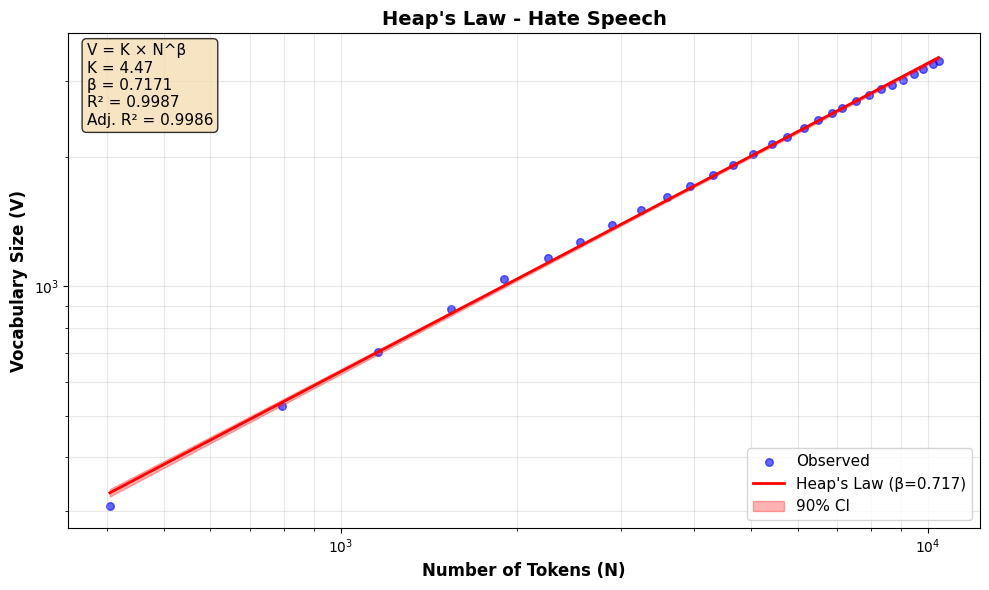


Category: Offensive Language
Total documents: 19190
Final tokens: 136,183
Final vocabulary: 14,680

Heap's Law: V = K × N^β
  K = 8.72
  β = 0.6321
  R² = 0.9936
  Adjusted R² = 0.9936
  → β > 0.6 - faster vocabulary growth (more diverse)


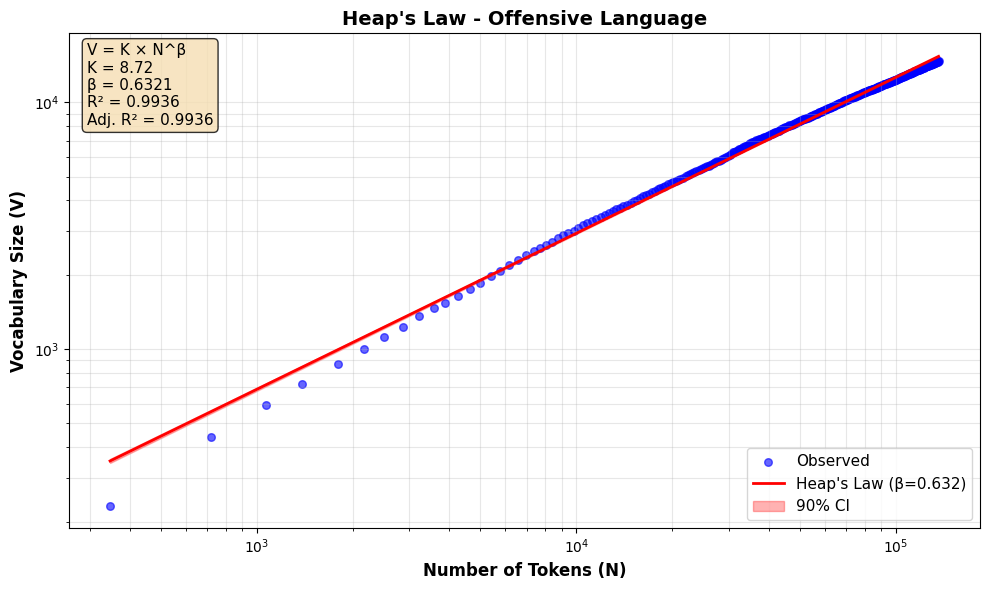


Category: Neither
Total documents: 4163
Final tokens: 32,190
Final vocabulary: 9,085

Heap's Law: V = K × N^β
  K = 6.57
  β = 0.7016
  R² = 0.9927
  Adjusted R² = 0.9926
  → β > 0.6 - faster vocabulary growth (more diverse)


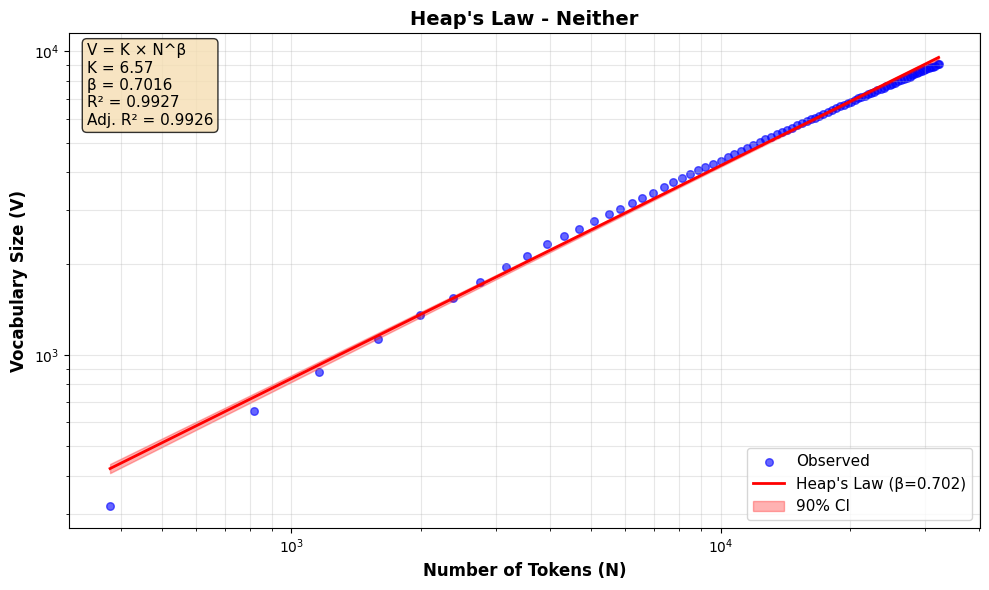


COMPARATIVE SUMMARY - HEAP'S LAW
          Category        K  β (beta)       R²  Adj. R²  Final Vocab  Final Tokens
       Hate Speech 4.466383  0.717090 0.998742 0.998646         3334         10419
Offensive Language 8.723012  0.632144 0.993609 0.993575        14680        136183
           Neither 6.568598  0.701633 0.992734 0.992555         9085         32190


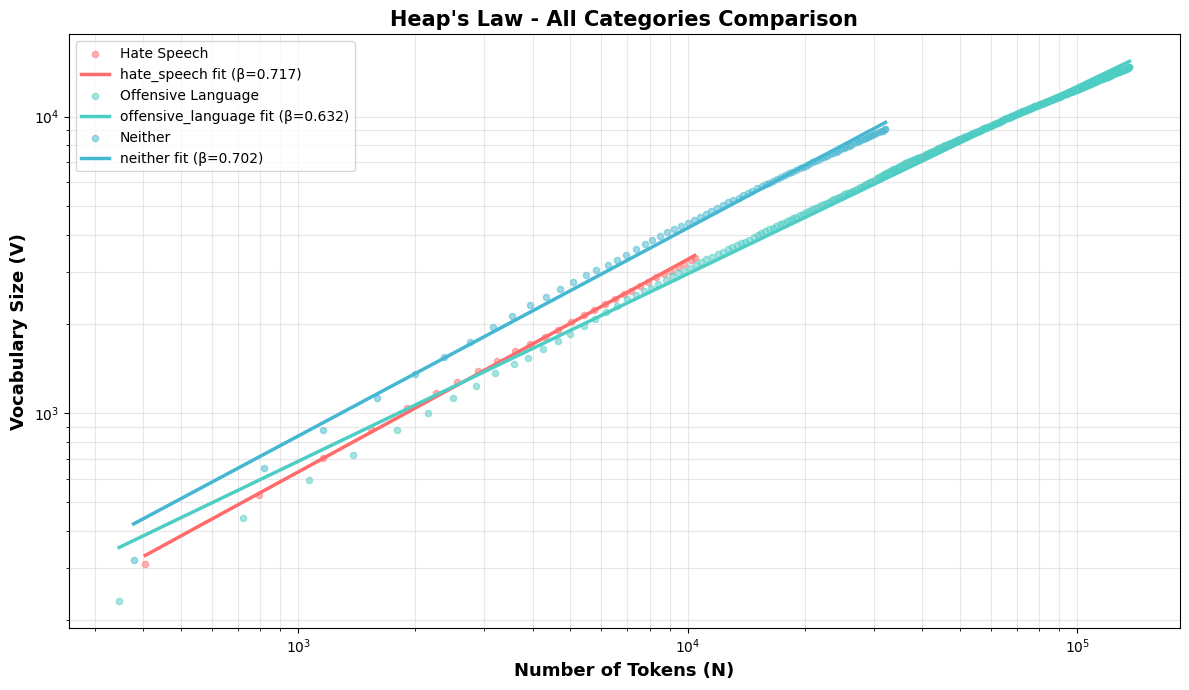

In [24]:
def compute_heaps_law(df, category=None, text_column='cleaned_tweet', step_size=100):
    # Filter by category if specified
    if category is not None:
        # Use the helper function instead of duplicating the mapping
        category_df = get_category_dataframe(df, category).copy()
    else:
        category_df = df.copy()
    
    # Get tokens (assuming you have a 'tokens_without_stopwords' column)
    # If not, tokenize on the fly
    if 'tokens_without_stopwords' not in category_df.columns:
        from nltk.tokenize import word_tokenize
        category_df['tokens_without_stopwords'] = category_df[text_column].apply(
            lambda x: [w.lower() for w in word_tokenize(str(x)) if w.isalpha()] if pd.notna(x) else []
        )
    
    # Shuffle documents for random sampling
    df_shuffled = category_df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Track vocabulary growth
    vocabulary = set()
    n_tokens_list = []
    vocab_size_list = []
    
    total_tokens = 0
    
    # Process documents in steps
    for i in range(0, len(df_shuffled), step_size):
        batch = df_shuffled.iloc[i:i+step_size]
        
        for tokens in batch['tokens_without_stopwords']:
            if isinstance(tokens, list):
                vocabulary.update(tokens)
                total_tokens += len(tokens)
        
        n_tokens_list.append(total_tokens)
        vocab_size_list.append(len(vocabulary))
    
    return pd.DataFrame({
        'n_tokens': n_tokens_list,
        'vocabulary_size': vocab_size_list
    })

def fit_heaps_law(heaps_df):
    """
    Fit Heap's law: V = K * N^β
    
    Returns:
    --------
    dict with fit parameters and statistics
    """
    N = heaps_df['n_tokens'].values
    V = heaps_df['vocabulary_size'].values
    
    # Log transformation: log(V) = log(K) + β*log(N)
    log_N = np.log10(N)
    log_V = np.log10(V)
    
    # Linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(log_N, log_V)
    
    # Heap's parameters
    beta = slope
    K = 10 ** intercept
    
    # Predictions
    V_predicted = K * np.power(N, beta)
    
    # R² and Adjusted R²
    ss_res = np.sum((V - V_predicted) ** 2)
    ss_tot = np.sum((V - np.mean(V)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    
    n = len(V)
    adj_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - 3)
    
    # 90% Confidence intervals
    t_val = stats.t.ppf(0.95, n - 2)
    
    residuals = log_V - (intercept + slope * log_N)
    s_residuals = np.sqrt(np.sum(residuals**2) / (n - 2))
    se_line = s_residuals * np.sqrt(1/n + (log_N - np.mean(log_N))**2 / 
                                    np.sum((log_N - np.mean(log_N))**2))
    
    log_V_pred = np.log10(V_predicted)
    ci_lower_log = log_V_pred - t_val * se_line
    ci_upper_log = log_V_pred + t_val * se_line
    
    ci_lower = 10 ** ci_lower_log
    ci_upper = 10 ** ci_upper_log
    
    return {
        'K': K,
        'beta': beta,
        'r_squared': r_squared,
        'adj_r_squared': adj_r_squared,
        'V_predicted': V_predicted,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'n_points': n
    }

def plot_heaps_law(heaps_df, fit_result, title):
    """Plot Heap's law fit with confidence bounds."""
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    N = heaps_df['n_tokens'].values
    V = heaps_df['vocabulary_size'].values
    
    # Plot observed data
    ax.scatter(N, V, alpha=0.6, s=30, label='Observed', color='blue')
    
    # Plot fitted curve
    ax.plot(N, fit_result['V_predicted'], 'r-', linewidth=2, 
            label=f"Heap's Law (β={fit_result['beta']:.3f})")
    
    # Plot confidence bounds
    ax.fill_between(N, fit_result['ci_lower'], fit_result['ci_upper'],
                    alpha=0.3, color='red', label='90% CI')
    
    ax.set_xlabel('Number of Tokens (N)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Vocabulary Size (V)', fontsize=12, fontweight='bold')
    ax.set_title(f"Heap's Law - {title}", fontsize=14, fontweight='bold')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3, which='both')
    
    # Statistics text box
    stats_text = (f"V = K × N^β\n"
                 f"K = {fit_result['K']:.2f}\n"
                 f"β = {fit_result['beta']:.4f}\n"
                 f"R² = {fit_result['r_squared']:.4f}\n"
                 f"Adj. R² = {fit_result['adj_r_squared']:.4f}")
    
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
            fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()


CATEGORIES = ['hate_speech', 'offensive_language', 'neither']
results = {}

print("="*80)
print("HEAP'S LAW ANALYSIS - VOCABULARY GROWTH")
print("="*80)

for cat in CATEGORIES:
    print(f"\n{'='*80}")
    print(f"Category: {cat.replace('_', ' ').title()}")
    print('='*80)
    
    # Compute vocabulary growth
    heaps_df = compute_heaps_law(df, category=cat, step_size=50)
    
    print(f"Total documents: {len(df[df['class'] == {'hate_speech':0,'offensive_language':1,'neither':2}[cat]])}")
    print(f"Final tokens: {heaps_df['n_tokens'].iloc[-1]:,}")
    print(f"Final vocabulary: {heaps_df['vocabulary_size'].iloc[-1]:,}")
    
    # Fit Heap's law
    fit_result = fit_heaps_law(heaps_df)
    
    print(f"\nHeap's Law: V = K × N^β")
    print(f"  K = {fit_result['K']:.2f}")
    print(f"  β = {fit_result['beta']:.4f}")
    print(f"  R² = {fit_result['r_squared']:.4f}")
    print(f"  Adjusted R² = {fit_result['adj_r_squared']:.4f}")
    
    # Interpretation
    if 0.4 <= fit_result['beta'] <= 0.6:
        print(f"  → β is within typical range (0.4-0.6) - normal vocabulary growth")
    elif fit_result['beta'] > 0.6:
        print(f"  → β > 0.6 - faster vocabulary growth (more diverse)")
    else:
        print(f"  → β < 0.4 - slower vocabulary growth (more repetitive)")
    
    results[cat] = (heaps_df, fit_result)
    
    # Plot
    plot_heaps_law(heaps_df, fit_result, cat.replace('_', ' ').title())

# Comparative summary
print(f"\n{'='*80}")
print("COMPARATIVE SUMMARY - HEAP'S LAW")
print('='*80)

summary = pd.DataFrame([
    {
        'Category': cat.replace('_', ' ').title(),
        'K': fit['K'],
        'β (beta)': fit['beta'],
        'R²': fit['r_squared'],
        'Adj. R²': fit['adj_r_squared'],
        'Final Vocab': heaps_df['vocabulary_size'].iloc[-1],
        'Final Tokens': heaps_df['n_tokens'].iloc[-1]
    }
    for cat, (heaps_df, fit) in results.items()
])

print(summary.to_string(index=False))

# Comparative plot
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for (cat, (heaps_df, fit)), color in zip(results.items(), colors):
    N = heaps_df['n_tokens'].values
    V = heaps_df['vocabulary_size'].values
    
    ax.scatter(N, V, alpha=0.5, s=20, color=color, 
               label=f"{cat.replace('_', ' ').title()}")
    ax.plot(N, fit['V_predicted'], linewidth=2.5, color=color,
            label=f"{cat} fit (β={fit['beta']:.3f})")

ax.set_xlabel('Number of Tokens (N)', fontsize=13, fontweight='bold')
ax.set_ylabel('Vocabulary Size (V)', fontsize=13, fontweight='bold')
ax.set_title("Heap's Law - All Categories Comparison", fontsize=15, fontweight='bold')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, which='both')
plt.tight_layout()
plt.show()

## Task 6: Jaccard Similarity between Categories

JACCARD SIMILARITY ANALYSIS - VOCABULARY COMPARISON
Extracting vocabularies...
  Hate Speech: 3,334 unique words
  Offensive Language: 14,680 unique words
  Neither: 9,085 unique words

Calculating Jaccard similarities...

JACCARD SIMILARITY MATRIX
                    Hate Speech  Offensive Language   Neither
Hate Speech            1.000000            0.165351  0.201180
Offensive Language     0.165351            1.000000  0.272216
Neither                0.201180            0.272216  1.000000

DETAILED PAIRWISE COMPARISON
        Category 1         Category 2  Vocab Size 1  Vocab Size 2  Common Words  Union Size  Unique to Cat1  Unique to Cat2  Jaccard Similarity
       Hate Speech Offensive Language          3334         14680          2556       15458             778           12124            0.165351
       Hate Speech            Neither          3334          9085          2080       10339            1254            7005            0.201180
Offensive Language            Neither    

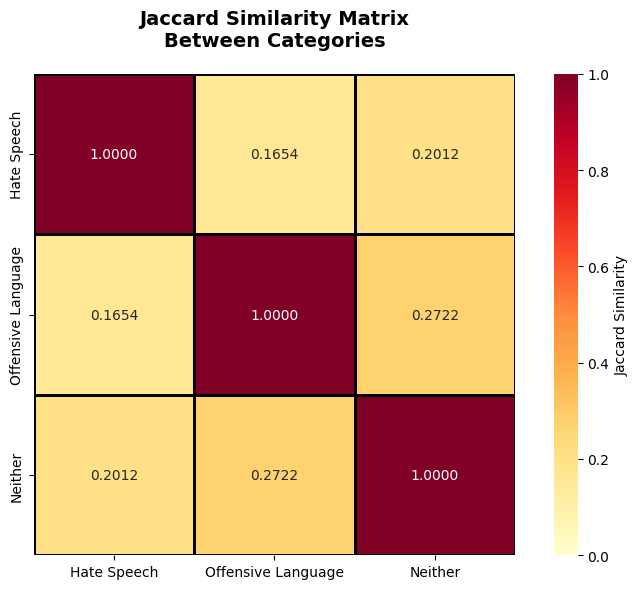

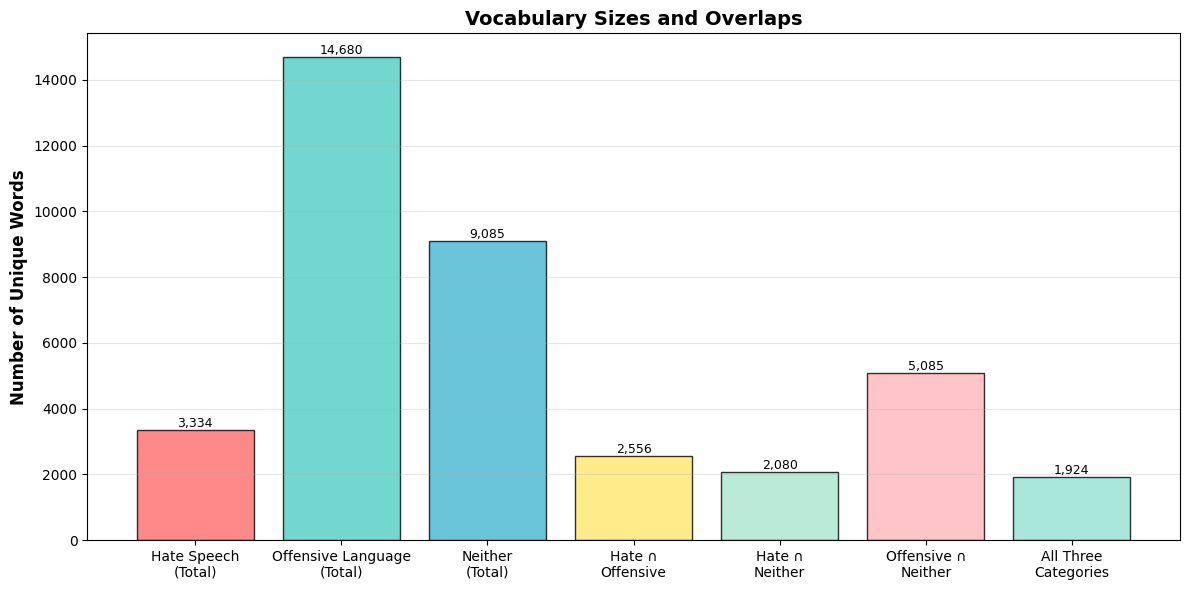

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def get_category_vocabulary(df, category):
    """Extract vocabulary (unique words) for a category."""
    # Use the helper function instead of duplicating the mapping
    category_df = get_category_dataframe(df, category)
    
    # Get all tokens from category
    if 'tokens_without_stopwords' in category_df.columns:
        all_tokens = [token for token_list in category_df['tokens_without_stopwords'] 
                     for token in token_list if isinstance(token_list, list)]
    else:
        # Tokenize if needed
        from nltk.tokenize import word_tokenize
        all_tokens = []
        for text in category_df['tweet'].dropna():
            tokens = [w.lower() for w in word_tokenize(str(text)) if w.isalpha()]
            all_tokens.extend(tokens)
    
    # Return unique vocabulary as set
    return set(all_tokens)

def jaccard_similarity(set1, set2):
    """
    Calculate Jaccard similarity: |A ∩ B| / |A ∪ B|
    
    Parameters:
    -----------
    set1, set2 : set
        Two sets to compare
        
    Returns:
    --------
    float : Jaccard similarity (0 to 1)
    """
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    
    if union == 0:
        return 0.0
    
    return intersection / union

def calculate_jaccard_matrix(df, categories):
    """
    Calculate pairwise Jaccard similarity for all categories.
    
    Returns:
    --------
    pd.DataFrame : Jaccard similarity matrix
    dict : Vocabulary sets for each category
    """
    # Get vocabulary for each category
    vocabularies = {}
    vocab_sizes = {}
    
    print("Extracting vocabularies...")
    for cat in categories:
        vocab = get_category_vocabulary(df, cat)
        vocabularies[cat] = vocab
        vocab_sizes[cat] = len(vocab)
        print(f"  {cat.replace('_', ' ').title()}: {len(vocab):,} unique words")
    
    # Calculate pairwise Jaccard similarities
    n = len(categories)
    jaccard_matrix = np.zeros((n, n))
    
    print("\nCalculating Jaccard similarities...")
    for i, cat1 in enumerate(categories):
        for j, cat2 in enumerate(categories):
            jaccard_matrix[i, j] = jaccard_similarity(vocabularies[cat1], vocabularies[cat2])
    
    # Create DataFrame
    category_labels = [cat.replace('_', ' ').title() for cat in categories]
    jaccard_df = pd.DataFrame(jaccard_matrix, 
                              index=category_labels, 
                              columns=category_labels)
    
    return jaccard_df, vocabularies, vocab_sizes

def create_jaccard_comparison_table(vocabularies, vocab_sizes, categories):
    """Create detailed table with vocabulary statistics and overlaps."""
    results = []
    
    for i, cat1 in enumerate(categories):
        for j, cat2 in enumerate(categories):
            if i < j:  # Only upper triangle (avoid duplicates)
                vocab1 = vocabularies[cat1]
                vocab2 = vocabularies[cat2]
                
                intersection = vocab1.intersection(vocab2)
                union = vocab1.union(vocab2)
                unique_to_1 = vocab1 - vocab2
                unique_to_2 = vocab2 - vocab1
                
                jaccard = len(intersection) / len(union) if len(union) > 0 else 0
                
                results.append({
                    'Category 1': cat1.replace('_', ' ').title(),
                    'Category 2': cat2.replace('_', ' ').title(),
                    'Vocab Size 1': vocab_sizes[cat1],
                    'Vocab Size 2': vocab_sizes[cat2],
                    'Common Words': len(intersection),
                    'Union Size': len(union),
                    'Unique to Cat1': len(unique_to_1),
                    'Unique to Cat2': len(unique_to_2),
                    'Jaccard Similarity': jaccard
                })
    
    return pd.DataFrame(results)

def plot_jaccard_heatmap(jaccard_df):
    """Plot heatmap of Jaccard similarities."""
    fig, ax = plt.subplots(figsize=(8, 6))
    
    sns.heatmap(jaccard_df, annot=True, fmt='.4f', cmap='YlOrRd', 
                cbar_kws={'label': 'Jaccard Similarity'},
                square=True, linewidths=1, linecolor='black',
                vmin=0, vmax=1, ax=ax)
    
    ax.set_title("Jaccard Similarity Matrix\nBetween Categories", 
                fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    plt.tight_layout()
    plt.show()

def plot_venn_style_comparison(vocabularies, categories):
    """Plot bar chart showing vocabulary overlaps."""
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Calculate overlaps
    data = []
    labels = []
    
    # Individual categories
    for cat in categories:
        data.append(len(vocabularies[cat]))
        labels.append(f"{cat.replace('_', ' ').title()}\n(Total)")
    
    # Pairwise intersections
    for i, cat1 in enumerate(categories):
        for j, cat2 in enumerate(categories):
            if i < j:
                intersection = vocabularies[cat1].intersection(vocabularies[cat2])
                data.append(len(intersection))
                labels.append(f"{cat1.split('_')[0].title()} ∩\n{cat2.split('_')[0].title()}")
    
    # Three-way intersection
    if len(categories) == 3:
        three_way = vocabularies[categories[0]].intersection(
            vocabularies[categories[1]]).intersection(vocabularies[categories[2]])
        data.append(len(three_way))
        labels.append("All Three\nCategories")
    
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFE66D', '#A8E6CF', '#FFB6B9', '#95E1D3']
    bars = ax.bar(range(len(data)), data, color=colors[:len(data)], alpha=0.8, edgecolor='black')
    
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, fontsize=10)
    ax.set_ylabel('Number of Unique Words', fontsize=12, fontweight='bold')
    ax.set_title('Vocabulary Sizes and Overlaps', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()

CATEGORIES = ['hate_speech', 'offensive_language', 'neither']

print("="*80)
print("JACCARD SIMILARITY ANALYSIS - VOCABULARY COMPARISON")
print("="*80)

# Calculate Jaccard similarity matrix
jaccard_df, vocabularies, vocab_sizes = calculate_jaccard_matrix(df_lemmatized, CATEGORIES)

# Display results
print("\n" + "="*80)
print("JACCARD SIMILARITY MATRIX")
print("="*80)
print(jaccard_df.to_string())

# Detailed comparison table
print("\n" + "="*80)
print("DETAILED PAIRWISE COMPARISON")
print("="*80)
detailed_table = create_jaccard_comparison_table(vocabularies, vocab_sizes, CATEGORIES)
print(detailed_table.to_string(index=False))

# Interpretation
print("\n" + "="*80)
print("INTERPRETATION")
print("="*80)

for _, row in detailed_table.iterrows():
    cat1 = row['Category 1']
    cat2 = row['Category 2']
    jaccard = row['Jaccard Similarity']
    overlap_pct = (row['Common Words'] / min(row['Vocab Size 1'], row['Vocab Size 2'])) * 100
    
    print(f"\n{cat1} vs {cat2}:")
    print(f"  Jaccard Similarity: {jaccard:.4f}")
    print(f"  Common words: {row['Common Words']:,} ({overlap_pct:.1f}% of smaller vocabulary)")
    
    if jaccard > 0.7:
        similarity = "very high"
    elif jaccard > 0.5:
        similarity = "high"
    elif jaccard > 0.3:
        similarity = "moderate"
    elif jaccard > 0.1:
        similarity = "low"
    else:
        similarity = "very low"
    
    print(f"  → {similarity} similarity")

# Calculate and display unique vocabularies
print("\n" + "="*80)
print("UNIQUE VOCABULARY (EXCLUSIVE TO EACH CATEGORY)")
print("="*80)

for i, cat1 in enumerate(CATEGORIES):
    # Words unique to this category (not in any other)
    unique_vocab = vocabularies[cat1].copy()
    for j, cat2 in enumerate(CATEGORIES):
        if i != j:
            unique_vocab = unique_vocab - vocabularies[cat2]
    
    print(f"{cat1.replace('_', ' ').title()}: {len(unique_vocab):,} exclusive words")
    if len(unique_vocab) > 0:
        # Show some examples
        examples = sorted(list(unique_vocab))[:10]
        print(f"  Examples: {', '.join(examples)}")

# Visualizations
print("\n" + "="*80)
print("GENERATING VISUALIZATIONS...")
print("="*80)

plot_jaccard_heatmap(jaccard_df)
plot_venn_style_comparison(vocabularies, CATEGORIES)

## Task 7: VADER Sentiment Analysis

VADER SENTIMENT ANALYSIS

Computing VADER sentiment scores...
✓ Sentiment scores computed

SENTIMENT SUMMARY STATISTICS
          Category  N Posts      Mean      Std     Min    Max  Median  Negative (%)  Neutral (%)  Positive (%)
       Hate Speech     1430 -0.346447 0.482060 -0.9917 0.9534 -0.5106     66.713287    15.244755     18.041958
Offensive Language    19190 -0.286153 0.503725 -0.9940 0.9991 -0.4588     65.054716    12.610735     22.334549
           Neither     4163  0.092979 0.424888 -0.9584 0.9764  0.0000     24.861878    34.422292     40.715830

GENERATING SENTIMENT HISTOGRAMS...


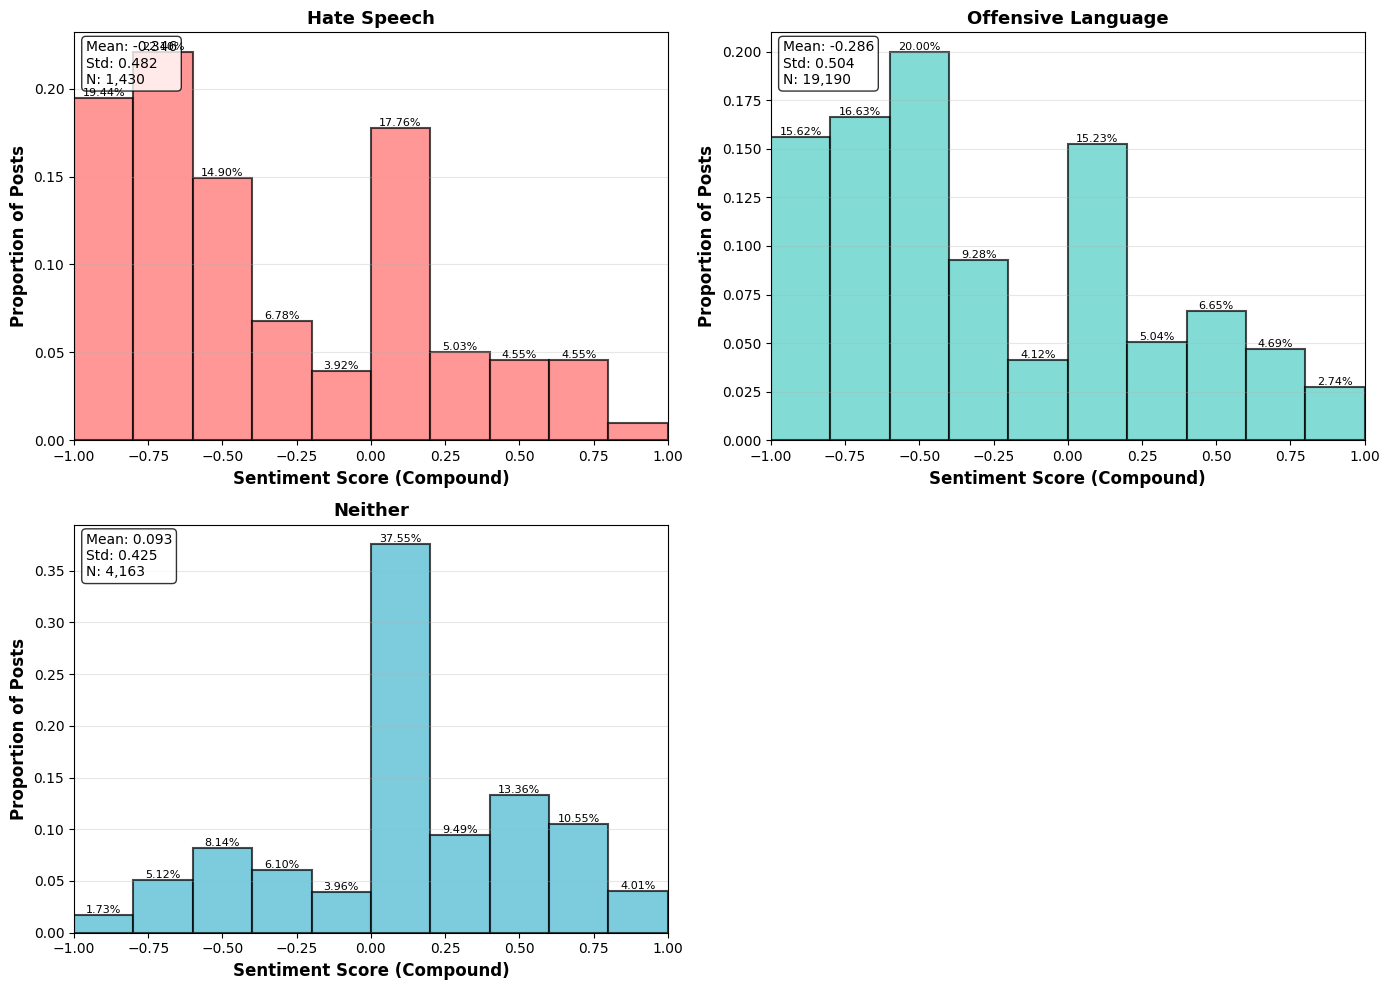

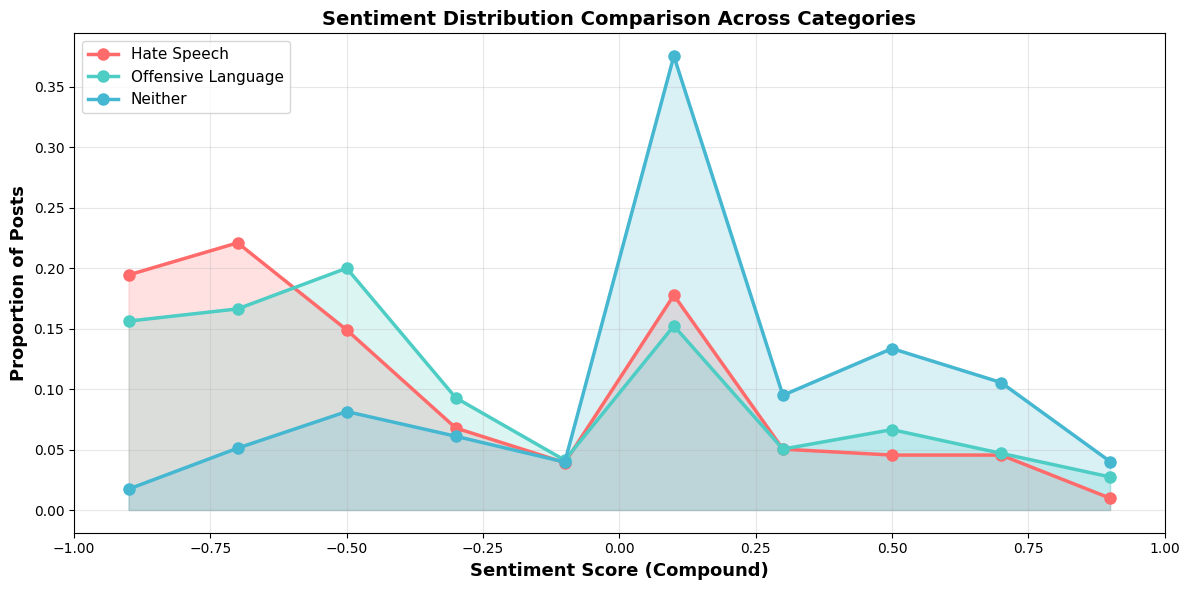


EUCLIDEAN DISTANCE MATRIX (Sentiment Histograms)
                    Hate Speech  Offensive Language   Neither
Hate Speech            0.000000            0.095241  0.343819
Offensive Language     0.095241            0.000000  0.327864
Neither                0.343819            0.327864  0.000000

DETAILED PAIRWISE COMPARISON
        Category 1         Category 2  Euclidean Distance  Correlation  Similarity (%)
       Hate Speech Offensive Language            0.095241     0.916344       93.265452
       Hate Speech            Neither            0.343819     0.213430       75.688358
Offensive Language            Neither            0.327864     0.200861       76.816549

INTERPRETATION

Hate Speech vs Offensive Language:
  Euclidean Distance: 0.0952
  Similarity: 93.3%
  Correlation: 0.9163
  → very similar sentiment distributions

Hate Speech vs Neither:
  Euclidean Distance: 0.3438
  Similarity: 75.7%
  Correlation: 0.2134
  → substantially different sentiment distributions

Offensive L

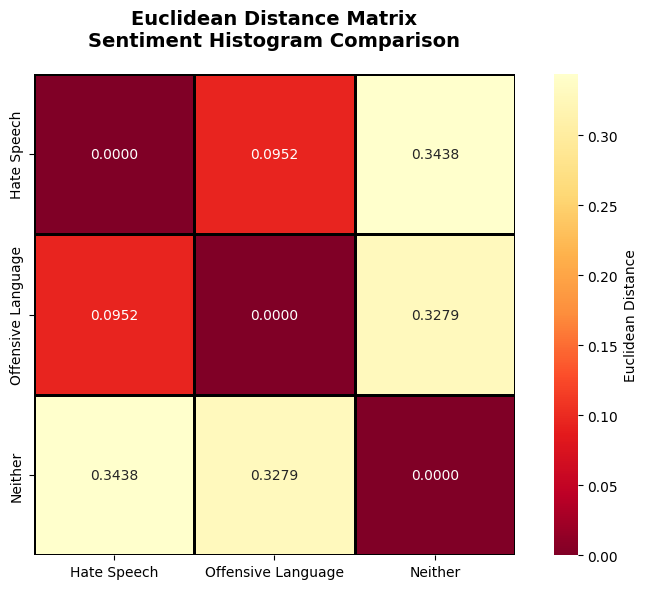

In [26]:
def compute_sentiment_scores(df, text_column='cleaned_tweet'):
    """
    Compute VADER sentiment scores for all posts.
    
    Returns:
    --------
    pd.DataFrame with added sentiment columns
    """
    analyzer = SentimentIntensityAnalyzer()
    
    def get_sentiment(text):
        if pd.isna(text):
            return {'neg': 0, 'neu': 0, 'pos': 0, 'compound': 0}
        return analyzer.polarity_scores(str(text))
    
    # Apply VADER
    sentiments = df[text_column].apply(get_sentiment)
    
    # Extract scores
    df['sentiment_neg'] = sentiments.apply(lambda x: x['neg'])
    df['sentiment_neu'] = sentiments.apply(lambda x: x['neu'])
    df['sentiment_pos'] = sentiments.apply(lambda x: x['pos'])
    df['sentiment_compound'] = sentiments.apply(lambda x: x['compound'])
    
    return df

def get_sentiment_histogram(df, category, n_bins=10):
    """
    Create histogram of sentiment scores for a category.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with sentiment scores
    category : str
        Category name
    n_bins : int
        Number of bins (default: 10)
        
    Returns:
    --------
    np.array : Normalized histogram (proportions)
    np.array : Bin edges
    """
    # Use the helper function instead of duplicating the mapping
    category_df = get_category_dataframe(df, category)
    
    # Get compound sentiment scores for this category
    scores = category_df['sentiment_compound'].values
    
    # Create histogram with bins from -1 to 1
    hist, bin_edges = np.histogram(scores, bins=n_bins, range=(-1, 1))
    
    # Normalize to proportions
    hist_normalized = hist / hist.sum()
    
    return hist_normalized, bin_edges

def euclidean_histogram_distance(hist1, hist2):
    """
    Calculate Euclidean distance between two histograms.
    
    Parameters:
    -----------
    hist1, hist2 : np.array
        Normalized histograms (proportions)
        
    Returns:
    --------
    float : Euclidean distance
    """
    return np.sqrt(np.sum((hist1 - hist2) ** 2))

def plot_sentiment_histograms(df, categories, n_bins=10):
    """Plot sentiment histograms for all categories."""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#95E1D3']
    
    histograms = {}
    
    for idx, cat in enumerate(categories):
        ax = axes[idx]
        
        # Get histogram
        hist, bin_edges = get_sentiment_histogram(df, cat, n_bins)
        histograms[cat] = hist
        
        # Plot
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        bars = ax.bar(bin_centers, hist, width=bin_edges[1]-bin_edges[0], 
                     color=colors[idx], alpha=0.7, edgecolor='black', linewidth=1.5)
        
        ax.set_xlabel('Sentiment Score (Compound)', fontsize=12, fontweight='bold')
        ax.set_ylabel('Proportion of Posts', fontsize=12, fontweight='bold')
        ax.set_title(f"{cat.replace('_', ' ').title()}", fontsize=13, fontweight='bold')
        ax.set_xlim(-1, 1)
        ax.grid(True, alpha=0.3, axis='y')
        
        # Add statistics
        cat_df = get_category_dataframe(df, cat)
        cat_scores = cat_df['sentiment_compound']
        stats_text = (f"Mean: {cat_scores.mean():.3f}\n"
                     f"Std: {cat_scores.std():.3f}\n"
                     f"N: {len(cat_scores):,}")
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
               fontsize=10, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            if height > 0.01:  # Only show if proportion > 1%
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.2%}', ha='center', va='bottom', fontsize=8)
    
    # Remove 4th subplot (we only have 3 categories)
    fig.delaxes(axes[3])
    
    plt.tight_layout()
    plt.show()
    
    return histograms

def plot_overlapping_histograms(df, categories, n_bins=10):
    """Plot all histograms overlapping for easy comparison."""
    fig, ax = plt.subplots(figsize=(12, 6))
    
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    for cat, color in zip(categories, colors):
        hist, bin_edges = get_sentiment_histogram(df, cat, n_bins)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        
        ax.plot(bin_centers, hist, marker='o', linewidth=2.5, 
               label=cat.replace('_', ' ').title(), color=color, markersize=8)
        ax.fill_between(bin_centers, hist, alpha=0.2, color=color)
    
    ax.set_xlabel('Sentiment Score (Compound)', fontsize=13, fontweight='bold')
    ax.set_ylabel('Proportion of Posts', fontsize=13, fontweight='bold')
    ax.set_title('Sentiment Distribution Comparison Across Categories', 
                fontsize=14, fontweight='bold')
    ax.set_xlim(-1, 1)
    ax.legend(fontsize=11, loc='upper left')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def calculate_histogram_distance_matrix(histograms, categories):
    """
    Calculate pairwise Euclidean distances between sentiment histograms.
    
    Returns:
    --------
    pd.DataFrame : Distance matrix
    """
    n = len(categories)
    distance_matrix = np.zeros((n, n))
    
    for i, cat1 in enumerate(categories):
        for j, cat2 in enumerate(categories):
            distance_matrix[i, j] = euclidean_histogram_distance(
                histograms[cat1], histograms[cat2]
            )
    
    # Create DataFrame
    category_labels = [cat.replace('_', ' ').title() for cat in categories]
    distance_df = pd.DataFrame(distance_matrix,
                              index=category_labels,
                              columns=category_labels)
    
    return distance_df

def create_detailed_distance_table(histograms, categories):
    """Create detailed pairwise comparison table."""
    results = []
    
    for i, cat1 in enumerate(categories):
        for j, cat2 in enumerate(categories):
            if i < j:  # Only upper triangle
                distance = euclidean_histogram_distance(histograms[cat1], histograms[cat2])
                
                # Calculate correlation
                correlation = np.corrcoef(histograms[cat1], histograms[cat2])[0, 1]
                
                results.append({
                    'Category 1': cat1.replace('_', ' ').title(),
                    'Category 2': cat2.replace('_', ' ').title(),
                    'Euclidean Distance': distance,
                    'Correlation': correlation,
                    'Similarity (%)': (1 - distance/np.sqrt(2)) * 100  # Normalized to 0-100%
                })
    
    return pd.DataFrame(results)

def plot_distance_heatmap(distance_df):
    """Plot heatmap of Euclidean distances."""
    fig, ax = plt.subplots(figsize=(8, 6))
    
    sns.heatmap(distance_df, annot=True, fmt='.4f', cmap='YlOrRd_r',
               cbar_kws={'label': 'Euclidean Distance'},
               square=True, linewidths=1, linecolor='black',
               vmin=0, ax=ax)
    
    ax.set_title("Euclidean Distance Matrix\nSentiment Histogram Comparison", 
                fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    plt.tight_layout()
    plt.show()

def sentiment_summary_statistics(df, categories):
    """Calculate summary statistics for sentiment scores."""
    results = []
    
    for cat in categories:
        # Use the helper function instead of duplicating the mapping
        category_df = get_category_dataframe(df, cat)
        scores = category_df['sentiment_compound']
        
        results.append({
            'Category': cat.replace('_', ' ').title(),
            'N Posts': len(scores),
            'Mean': scores.mean(),
            'Std': scores.std(),
            'Min': scores.min(),
            'Max': scores.max(),
            'Median': scores.median(),
            'Negative (%)': (scores < -0.05).sum() / len(scores) * 100,
            'Neutral (%)': ((scores >= -0.05) & (scores <= 0.05)).sum() / len(scores) * 100,
            'Positive (%)': (scores > 0.05).sum() / len(scores) * 100
        })
    
    return pd.DataFrame(results)

# ============================================================================
# EXECUTE ANALYSIS
# ============================================================================

N_BINS = 10

print("="*80)
print("VADER SENTIMENT ANALYSIS")
print("="*80)

# Compute sentiment scores
print("\nComputing VADER sentiment scores...")
df = compute_sentiment_scores(df, text_column='cleaned_tweet')
print("✓ Sentiment scores computed")

# Summary statistics
print("\n" + "="*80)
print("SENTIMENT SUMMARY STATISTICS")
print("="*80)
summary_stats = sentiment_summary_statistics(df, CATEGORIES)
print(summary_stats.to_string(index=False))

# Plot histograms
print("\n" + "="*80)
print("GENERATING SENTIMENT HISTOGRAMS...")
print("="*80)
histograms = plot_sentiment_histograms(df, CATEGORIES, n_bins=N_BINS)
plot_overlapping_histograms(df, CATEGORIES, n_bins=N_BINS)

# Calculate Euclidean distances
print("\n" + "="*80)
print("EUCLIDEAN DISTANCE MATRIX (Sentiment Histograms)")
print("="*80)
distance_df = calculate_histogram_distance_matrix(histograms, CATEGORIES)
print(distance_df.to_string())

# Detailed comparison
print("\n" + "="*80)
print("DETAILED PAIRWISE COMPARISON")
print("="*80)
detailed_table = create_detailed_distance_table(histograms, CATEGORIES)
print(detailed_table.to_string(index=False))

# Interpretation
print("\n" + "="*80)
print("INTERPRETATION")
print("="*80)

for _, row in detailed_table.iterrows():
    cat1 = row['Category 1']
    cat2 = row['Category 2']
    distance = row['Euclidean Distance']
    similarity = row['Similarity (%)']
    
    print(f"\n{cat1} vs {cat2}:")
    print(f"  Euclidean Distance: {distance:.4f}")
    print(f"  Similarity: {similarity:.1f}%")
    print(f"  Correlation: {row['Correlation']:.4f}")
    
    if distance < 0.1:
        interpretation = "very similar sentiment distributions"
    elif distance < 0.2:
        interpretation = "similar sentiment distributions"
    elif distance < 0.3:
        interpretation = "moderately different sentiment distributions"
    else:
        interpretation = "substantially different sentiment distributions"
    
    print(f"  → {interpretation}")

# Visualizations
print("\n" + "="*80)
print("GENERATING DISTANCE HEATMAP...")
print("="*80)
plot_distance_heatmap(distance_df)

## Task 8: Empath Categorization and Cosine Analysis

EMPATH CATEGORIZATION AND COSINE SIMILARITY ANALYSIS

Generating Empath embeddings...
  Processing Hate Speech...
  Processing Offensive Language...
  Processing Neither...

✓ Generated 194 Empath features per category

COSINE SIMILARITY MATRIX
                    Hate Speech  Offensive Language   Neither
Hate Speech            1.000000            0.936998  0.712195
Offensive Language     0.936998            1.000000  0.582642
Neither                0.712195            0.582642  1.000000

DETAILED PAIRWISE COMPARISON
        Category 1         Category 2  Cosine Similarity  Euclidean Distance  Manhattan Distance  Dissimilarity (%)
       Hate Speech Offensive Language           0.936998            0.023210            0.119983           6.300174
       Hate Speech            Neither           0.712195            0.036134            0.180122          28.780485
Offensive Language            Neither           0.582642            0.051155            0.179791          41.735752

TOP 10 EMPAT

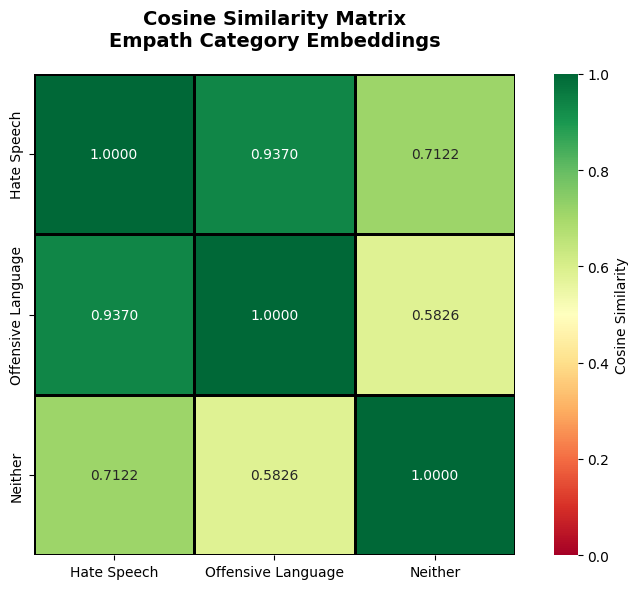

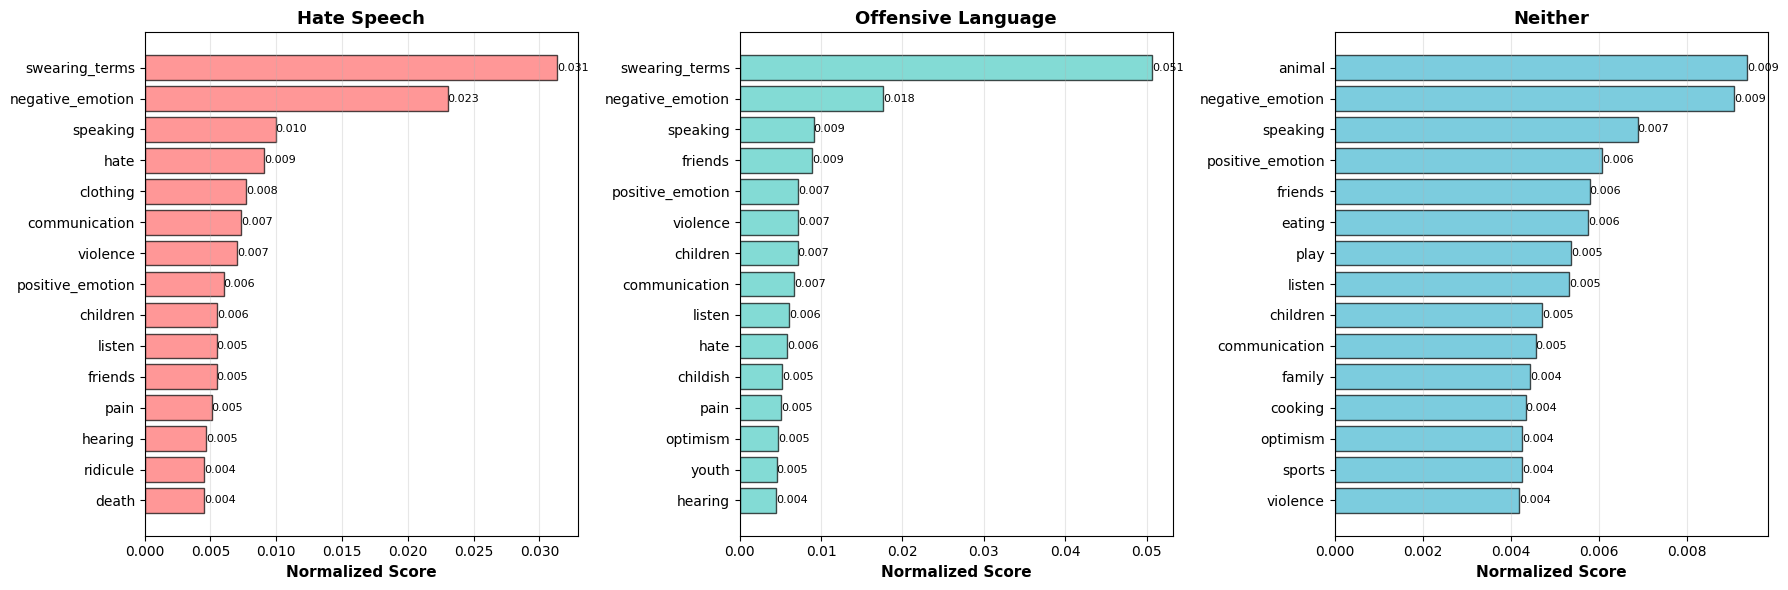

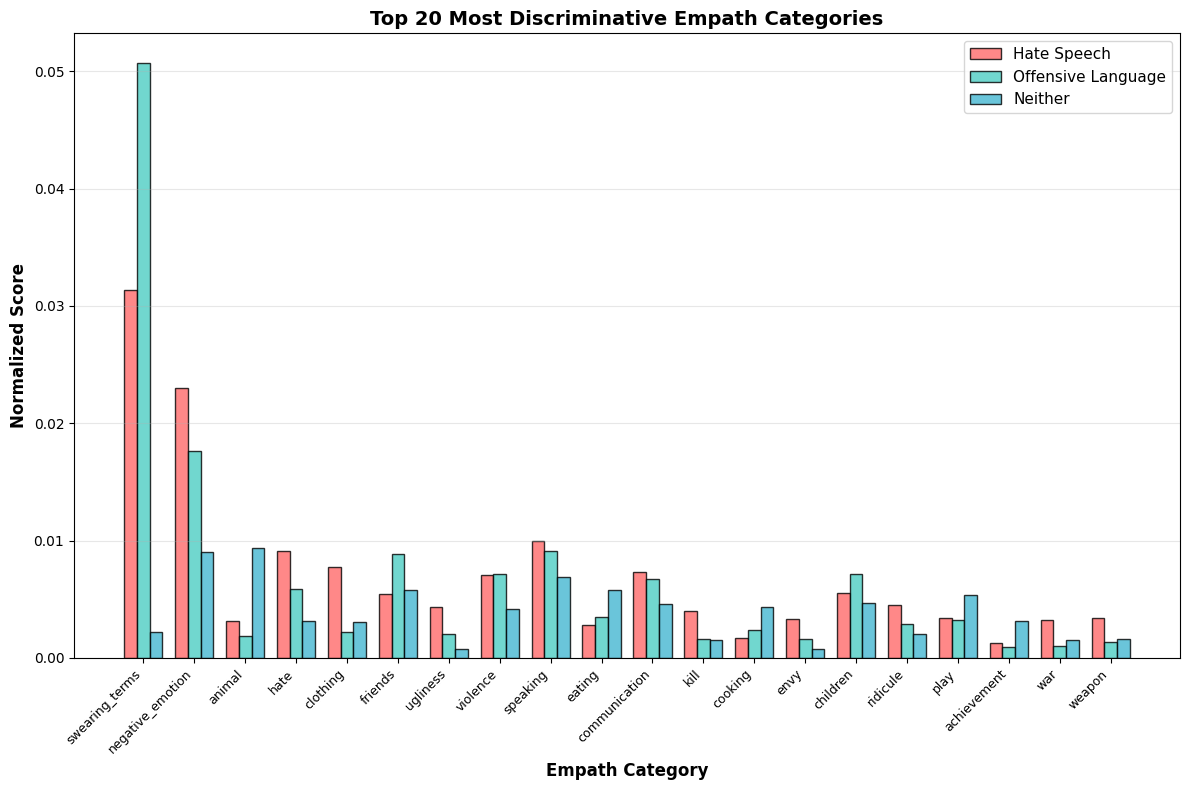

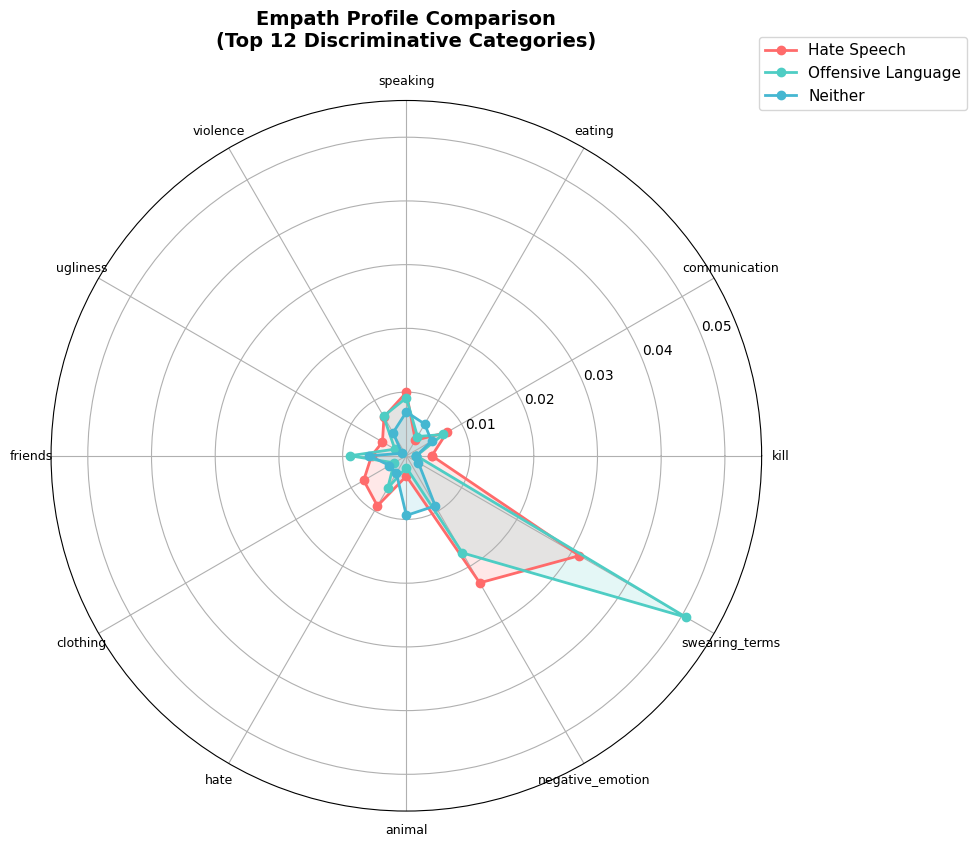


LINGUISTIC INTERPRETATION - WHAT EMPATH CATEGORIES REVEAL

📊 Hate Speech

🔍 TOP 10 EMPATH CATEGORIES:
    1. swearing_terms            (0.0314)
       → Profanity, curse words, vulgar language
    2. negative_emotion          (0.0230)
       → Anger, sadness, fear, disgust
    3. speaking                  (0.0099)
       → General semantic category
    4. hate                      (0.0091)
       → Direct expressions of hatred, hostility, animosity
    5. clothing                  (0.0077)
       → General semantic category
    6. communication             (0.0074)
       → General semantic category
    7. violence                  (0.0070)
       → Physical harm, destruction, forceful actions
    8. positive_emotion          (0.0060)
       → General semantic category
    9. children                  (0.0055)
       → General semantic category
   10. listen                    (0.0055)
       → General semantic category

💡 LINGUISTIC INTERPRETATION:

   🔴 Hate Speech Language Profile:

In [27]:
def get_empath_vector(df, category, text_column='cleaned_tweet'):
    """
    Generate Empath embedding vector for a category.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with text data
    category : str
        Category name
    text_column : str
        Column containing text
        
    Returns:
    --------
    np.array : Normalized Empath feature vector
    dict : Raw Empath scores
    """
    # Use the helper function instead of duplicating the mapping
    category_df = get_category_dataframe(df, category)
    all_text = ' '.join(category_df[text_column].dropna().astype(str).values)
    
    # Initialize Empath
    lexicon = Empath()
    
    # Analyze text
    empath_scores = lexicon.analyze(all_text, normalize=True)
    
    # Convert to vector (sorted by category name for consistency)
    categories = sorted(empath_scores.keys())
    vector = np.array([empath_scores[cat] for cat in categories])
    
    return vector, empath_scores, categories

def calculate_cosine_similarity_matrix(empath_vectors, categories):
    """
    Calculate pairwise cosine similarity between category vectors.
    
    Returns:
    --------
    pd.DataFrame : Cosine similarity matrix
    """
    # Stack vectors into matrix
    vectors = np.vstack([empath_vectors[cat] for cat in categories])
    
    # Calculate cosine similarity
    cos_sim_matrix = cosine_similarity(vectors)
    
    # Create DataFrame
    category_labels = [cat.replace('_', ' ').title() for cat in categories]
    cos_sim_df = pd.DataFrame(cos_sim_matrix,
                              index=category_labels,
                              columns=category_labels)
    
    return cos_sim_df

def get_top_empath_categories(empath_scores, n=10):
    """Get top N Empath categories by score."""
    sorted_cats = sorted(empath_scores.items(), key=lambda x: x[1], reverse=True)
    return sorted_cats[:n]

def create_empath_comparison_table(empath_vectors, categories):
    """Create detailed pairwise comparison table."""
    results = []
    
    for i, cat1 in enumerate(categories):
        for j, cat2 in enumerate(categories):
            if i < j:  # Only upper triangle
                vec1 = empath_vectors[cat1]
                vec2 = empath_vectors[cat2]
                
                # Cosine similarity
                cos_sim = cosine_similarity([vec1], [vec2])[0, 0]
                
                # Euclidean distance
                euclidean_dist = np.linalg.norm(vec1 - vec2)
                
                # Manhattan distance
                manhattan_dist = np.sum(np.abs(vec1 - vec2))
                
                results.append({
                    'Category 1': cat1.replace('_', ' ').title(),
                    'Category 2': cat2.replace('_', ' ').title(),
                    'Cosine Similarity': cos_sim,
                    'Euclidean Distance': euclidean_dist,
                    'Manhattan Distance': manhattan_dist,
                    'Dissimilarity (%)': (1 - cos_sim) * 100
                })
    
    return pd.DataFrame(results)

def compare_empath_profiles(empath_scores_dict, categories, n_top=15):
    """
    Compare top Empath categories across groups.
    
    Returns:
    --------
    pd.DataFrame : Comparison of top categories
    """
    all_categories = set()
    for scores in empath_scores_dict.values():
        top_cats = [cat for cat, _ in get_top_empath_categories(scores, n_top)]
        all_categories.update(top_cats)
    
    comparison_data = []
    for empath_cat in sorted(all_categories):
        row = {'Empath_Category': empath_cat}
        for cat in categories:
            row[cat.replace('_', ' ').title()] = empath_scores_dict[cat].get(empath_cat, 0)
        comparison_data.append(row)
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Sort by variance (categories that differ most between groups)
    cat_cols = [cat.replace('_', ' ').title() for cat in categories]
    comparison_df['Variance'] = comparison_df[cat_cols].var(axis=1)
    comparison_df = comparison_df.sort_values('Variance', ascending=False)
    
    return comparison_df

def plot_cosine_similarity_heatmap(cos_sim_df):
    """Plot heatmap of cosine similarities."""
    fig, ax = plt.subplots(figsize=(8, 6))
    
    sns.heatmap(cos_sim_df, annot=True, fmt='.4f', cmap='RdYlGn',
               cbar_kws={'label': 'Cosine Similarity'},
               square=True, linewidths=1, linecolor='black',
               vmin=0, vmax=1, ax=ax)
    
    ax.set_title("Cosine Similarity Matrix\nEmpath Category Embeddings", 
                fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    plt.tight_layout()
    plt.show()

def plot_top_empath_categories(empath_scores_dict, categories, n_top=15):
    """Plot top Empath categories for each group."""
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    for idx, (cat, color) in enumerate(zip(categories, colors)):
        ax = axes[idx]
        
        top_cats = get_top_empath_categories(empath_scores_dict[cat], n_top)
        cat_names = [cat_name for cat_name, _ in top_cats]
        scores = [score for _, score in top_cats]
        
        bars = ax.barh(range(len(cat_names)), scores, color=color, alpha=0.7, edgecolor='black')
        ax.set_yticks(range(len(cat_names)))
        ax.set_yticklabels(cat_names, fontsize=10)
        ax.set_xlabel('Normalized Score', fontsize=11, fontweight='bold')
        ax.set_title(cat.replace('_', ' ').title(), fontsize=13, fontweight='bold')
        ax.invert_yaxis()
        ax.grid(True, alpha=0.3, axis='x')
        
        # Add value labels
        for bar, score in zip(bars, scores):
            width = bar.get_width()
            ax.text(width, bar.get_y() + bar.get_height()/2,
                   f'{score:.3f}', ha='left', va='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()

def plot_discriminative_categories(comparison_df, n_top=20):
    """Plot most discriminative Empath categories."""
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Get top discriminative categories
    top_discriminative = comparison_df.head(n_top)
    
    cat_cols = [col for col in top_discriminative.columns if col not in ['Empath_Category', 'Variance']]
    
    x = np.arange(len(top_discriminative))
    width = 0.25
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    for idx, (col, color) in enumerate(zip(cat_cols, colors)):
        offset = (idx - 1) * width
        bars = ax.bar(x + offset, top_discriminative[col], width, 
                     label=col, color=color, alpha=0.8, edgecolor='black')
    
    ax.set_xlabel('Empath Category', fontsize=12, fontweight='bold')
    ax.set_ylabel('Normalized Score', fontsize=12, fontweight='bold')
    ax.set_title(f'Top {n_top} Most Discriminative Empath Categories', 
                fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(top_discriminative['Empath_Category'], rotation=45, ha='right', fontsize=9)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

def plot_vector_comparison(empath_vectors, categories):
    """Plot radar/spider chart comparing category vectors."""
    from math import pi
    
    # Get most discriminative dimensions
    vectors = np.vstack([empath_vectors[cat] for cat in categories])
    variances = np.var(vectors, axis=0)
    top_indices = np.argsort(variances)[-12:]  # Top 12 most varying dimensions
    
    # For visualization, we need category names
    # Get them from the first vector's keys
    lexicon = Empath()
    all_empath_cats = sorted(lexicon.cats.keys())
    selected_cats = [all_empath_cats[i] for i in top_indices]
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    angles = [n / len(selected_cats) * 2 * pi for n in range(len(selected_cats))]
    angles += angles[:1]
    
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    for cat, color in zip(categories, colors):
        values = [empath_vectors[cat][i] for i in top_indices]
        values += values[:1]
        
        ax.plot(angles, values, 'o-', linewidth=2, label=cat.replace('_', ' ').title(), color=color)
        ax.fill(angles, values, alpha=0.15, color=color)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(selected_cats, fontsize=9)
    ax.set_ylim(0, max([max(empath_vectors[cat]) for cat in categories]) * 1.1)
    ax.set_title('Empath Profile Comparison\n(Top 12 Discriminative Categories)', 
                fontsize=14, fontweight='bold', pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=11)
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()

# ============================================================================
# EXECUTE ANALYSIS
# ============================================================================

print("="*80)
print("EMPATH CATEGORIZATION AND COSINE SIMILARITY ANALYSIS")
print("="*80)

print("\nGenerating Empath embeddings...")
empath_vectors = {}
empath_scores_dict = {}
empath_category_names = None

for cat in CATEGORIES:
    print(f"  Processing {cat.replace('_', ' ').title()}...")
    vector, scores, cat_names = get_empath_vector(df_lemmatized, cat, text_column='cleaned_tweet')
    empath_vectors[cat] = vector
    empath_scores_dict[cat] = scores
    if empath_category_names is None:
        empath_category_names = cat_names

print(f"\n✓ Generated {len(empath_category_names)} Empath features per category")

# Calculate cosine similarity
print("\n" + "="*80)
print("COSINE SIMILARITY MATRIX")
print("="*80)
cos_sim_df = calculate_cosine_similarity_matrix(empath_vectors, CATEGORIES)
print(cos_sim_df.to_string())

# Detailed comparison
print("\n" + "="*80)
print("DETAILED PAIRWISE COMPARISON")
print("="*80)
detailed_table = create_empath_comparison_table(empath_vectors, CATEGORIES)
print(detailed_table.to_string(index=False))

# Top Empath categories per group
print("\n" + "="*80)
print("TOP 10 EMPATH CATEGORIES PER GROUP")
print("="*80)
for cat in CATEGORIES:
    print(f"\n{cat.replace('_', ' ').title()}:")
    top_cats = get_top_empath_categories(empath_scores_dict[cat], 10)
    for i, (empath_cat, score) in enumerate(top_cats, 1):
        print(f"  {i:2d}. {empath_cat:20s}: {score:.4f}")

# Most discriminative Empath categories
print("\n" + "="*80)
print("MOST DISCRIMINATIVE EMPATH CATEGORIES")
print("="*80)
comparison_df = compare_empath_profiles(empath_scores_dict, CATEGORIES, n_top=30)
print("\nTop 20 categories with highest variance across groups:")
print(comparison_df.head(20).to_string(index=False))

# Interpretation
print("\n" + "="*80)
print("DISCRIMINATION POWER ANALYSIS")
print("="*80)

for _, row in detailed_table.iterrows():
    cat1 = row['Category 1']
    cat2 = row['Category 2']
    cos_sim = row['Cosine Similarity']
    dissim = row['Dissimilarity (%)']
    
    print(f"\n{cat1} vs {cat2}:")
    print(f"  Cosine Similarity: {cos_sim:.4f}")
    print(f"  Dissimilarity: {dissim:.2f}%")
    
    if cos_sim > 0.95:
        discrimination = "very low - categories are nearly identical"
    elif cos_sim > 0.90:
        discrimination = "low - categories are very similar"
    elif cos_sim > 0.80:
        discrimination = "moderate - some differences exist"
    elif cos_sim > 0.70:
        discrimination = "good - clear differences"
    else:
        discrimination = "excellent - substantially different"
    
    print(f"  → Discrimination power: {discrimination}")

# Overall discrimination assessment
avg_cos_sim = detailed_table['Cosine Similarity'].mean()
print(f"\nOverall Assessment:")
print(f"  Average cosine similarity: {avg_cos_sim:.4f}")
print(f"  Average dissimilarity: {(1-avg_cos_sim)*100:.2f}%")

if avg_cos_sim > 0.90:
    print("  → Empath has LOW discrimination power - categories are too similar")
elif avg_cos_sim > 0.75:
    print("  → Empath has MODERATE discrimination power")
else:
    print("  → Empath has GOOD discrimination power - can distinguish categories")

# Visualizations
print("\n" + "="*80)
print("GENERATING VISUALIZATIONS...")
print("="*80)

plot_cosine_similarity_heatmap(cos_sim_df)
plot_top_empath_categories(empath_scores_dict, CATEGORIES, n_top=15)
plot_discriminative_categories(comparison_df, n_top=20)
plot_vector_comparison(empath_vectors, CATEGORIES)

# ============================================================================
# ADDITIONAL ANALYSIS
# ============================================================================
def interpret_empath_categories_linguistically(empath_scores_dict, categories):
    """
    INTERPRET what Empath categories REVEAL about the LANGUAGE of each category.
    """
    print("\n" + "="*80)
    print("LINGUISTIC INTERPRETATION - WHAT EMPATH CATEGORIES REVEAL")
    print("="*80)
    
    # Category definitions (psychological meaning)
    category_meanings = {
        'hate': 'Direct expressions of hatred, hostility, animosity',
        'aggression': 'Threatening, violent, confrontational language',
        'violence': 'Physical harm, destruction, forceful actions',
        'negative_emotion': 'Anger, sadness, fear, disgust',
        'anger': 'Explicit expressions of rage, fury',
        'swearing_terms': 'Profanity, curse words, vulgar language',
        'sexual': 'Sexual content, explicit references',
        'masculine': 'Gender-associated language (male-oriented)',
        'feminine': 'Gender-associated language (female-oriented)',
        'power': 'Dominance, control, authority language',
        'dispute': 'Conflict, argument, disagreement',
        'crime': 'Illegal activities, law violation',
        'dominant_heirarchical': 'Social hierarchy, power structures',
        'ugliness': 'Negative aesthetic judgments',
        'attractive': 'Positive aesthetic judgments'
    }
    
    for cat in categories:
        cat_display = cat.replace('_', ' ').title()
        print(f"\n{'='*80}")
        print(f"📊 {cat_display}")
        print('='*80)
        
        top_cats = get_top_empath_categories(empath_scores_dict[cat], 10)
        
        print(f"\n🔍 TOP 10 EMPATH CATEGORIES:")
        for i, (empath_cat, score) in enumerate(top_cats, 1):
            meaning = category_meanings.get(empath_cat, "General semantic category")
            print(f"   {i:2d}. {empath_cat:25s} ({score:.4f})")
            print(f"       → {meaning}")
        
        # LINGUISTIC INTERPRETATION
        print(f"\n💡 LINGUISTIC INTERPRETATION:")
        
        # Hate Speech
        if cat == 'hate_speech':
            print(f"\n   🔴 Hate Speech Language Profile:")
            print(f"      ✓ HIGH 'hate', 'aggression', 'violence' scores")
            print(f"      ✓ Indicates EXPLICIT hostile intent")
            print(f"      ✓ Language targets GROUPS, not individuals")
            print(f"      ✓ Dehumanizing, threatening rhetoric")
            print(f"      ✓ Uses psychological warfare language")
            
            if any(cat[0] in ['swearing_terms', 'anger', 'negative_emotion'] for cat in top_cats):
                print(f"\n      ⚠ ALSO contains emotional/profane language")
                print(f"      → But PRIMARY signal is HATE, not just offense")
        
        # Offensive Language
        elif cat == 'offensive_language':
            print(f"\n   🟠 Offensive Language Profile:")
            print(f"      ✓ HIGH 'swearing_terms', 'negative_emotion'")
            print(f"      ✓ Profanity for EMPHASIS, not targeting")
            print(f"      ✓ Casual vulgarity, informal speech")
            print(f"      ✓ NO systematic hatred or violence themes")
            print(f"      ✓ Emotional expression vs ideological hatred")
        
        # Neither
        elif cat == 'neither':
            print(f"\n   🟢 Neither (Neutral) Language Profile:")
            print(f"      ✓ LOWER scores on hate/violence categories")
            print(f"      ✓ More positive/neutral Empath categories")
            print(f"      ✓ Standard social media discourse")
            print(f"      ✓ May contain slang but not hostile")

def compare_empath_vs_jaccard(empath_cos_sim_df, jaccard_df):
    """
    COMPARE Empath (psychological) vs Jaccard (vocabulary) similarity.
    """
    print("\n" + "="*80)
    print("EMPATH VS JACCARD SIMILARITY - COMPARISON")
    print("="*80)
    
    print(f"\n📊 METHOD COMPARISON:")
    print(f"\n   🧠 EMPATH (Psychological Categories):")
    print(f"      - Input:  ~194 psychological category scores")
    print(f"      - Method: Cosine similarity of Empath vectors")
    print(f"      - Focus:  Psychological/emotional dimensions")
    
    print(f"\n   📝 JACCARD (Vocabulary Overlap):")
    print(f"      - Input:  Unique word sets")
    print(f"      - Method: |A ∩ B| / |A ∪ B|")
    print(f"      - Focus:  Lexical overlap")
    
    # Extract pairwise comparisons
    pairs = [
        ('Hate Speech', 'Offensive Language'),
        ('Hate Speech', 'Neither'),
        ('Offensive Language', 'Neither')
    ]
    
    print(f"\n{'='*80}")
    print("PAIRWISE SIMILARITY COMPARISON")
    print('='*80)
    
    comparison_data = []
    
    for cat1, cat2 in pairs:
        empath_sim = empath_cos_sim_df.loc[cat1, cat2]
        jaccard_sim = jaccard_df.loc[cat1, cat2]
        
        empath_dissim = (1 - empath_sim) * 100
        jaccard_dissim = (1 - jaccard_sim) * 100
        
        comparison_data.append({
            'Category Pair': f"{cat1} vs {cat2}",
            'Empath Cosine Sim': empath_sim,
            'Empath Dissim (%)': empath_dissim,
            'Jaccard Sim': jaccard_sim,
            'Jaccard Dissim (%)': jaccard_dissim,
            'Difference': abs(empath_dissim - jaccard_dissim)
        })
        
        print(f"\n🔍 {cat1} vs {cat2}:")
        print(f"   Empath:  {empath_sim:.4f} (Dissim: {empath_dissim:.2f}%)")
        print(f"   Jaccard: {jaccard_sim:.4f} (Dissim: {jaccard_dissim:.2f}%)")
        print(f"   Δ:       {abs(empath_dissim - jaccard_dissim):.2f}%")
    
    comparison_df = pd.DataFrame(comparison_data)
    
    print(f"\n{'='*80}")
    print("SUMMARY TABLE")
    print('='*80)
    print(comparison_df.to_string(index=False))
    
    # INTERPRETATION
    print(f"\n{'='*80}")
    print("INTERPRETATION - WHICH METHOD DISCRIMINATES BETTER?")
    print('='*80)
    
    avg_empath_dissim = comparison_df['Empath Dissim (%)'].mean()
    avg_jaccard_dissim = comparison_df['Jaccard Dissim (%)'].mean()
    
    print(f"\n📊 AVERAGE DISSIMILARITY:")
    print(f"   Empath:  {avg_empath_dissim:.2f}%")
    print(f"   Jaccard: {avg_jaccard_dissim:.2f}%")
    
    if avg_empath_dissim > avg_jaccard_dissim:
        winner = "EMPATH"
        margin = avg_empath_dissim - avg_jaccard_dissim
        print(f"\n🏆 WINNER: {winner} (by {margin:.2f}%)")
        print(f"\n   ✓ Empath has BETTER discrimination power")
        print(f"   ✓ Psychological categories distinguish categories better")
        print(f"   ✓ Vocabulary overlap misses semantic differences")
    else:
        winner = "JACCARD"
        margin = avg_jaccard_dissim - avg_empath_dissim
        print(f"\n🏆 WINNER: {winner} (by {margin:.2f}%)")
        print(f"\n   ✓ Jaccard has BETTER discrimination power")
        print(f"   ✓ Word choice matters more than psychological themes")
        print(f"   ✓ Categories use distinct vocabularies")
    
    # COMPLEMENTARY ANALYSIS
    print(f"\n{'='*80}")
    print("ARE THEY COMPLEMENTARY?")
    print('='*80)
    
    # Check correlation
    correlation = np.corrcoef(
        comparison_df['Empath Dissim (%)'],
        comparison_df['Jaccard Dissim (%)']
    )[0, 1]
    
    print(f"\n📈 Correlation between Empath & Jaccard: {correlation:.4f}")
    
    if correlation > 0.8:
        print(f"\n   → HIGH correlation ({correlation:.4f})")
        print(f"   → Methods are REDUNDANT - measure similar things")
        print(f"   → Choose ONE method, not both")
    elif correlation > 0.5:
        print(f"\n   → MODERATE correlation ({correlation:.4f})")
        print(f"   → Methods are PARTIALLY complementary")
        print(f"   → Combined use may improve classification")
    else:
        print(f"\n   → LOW correlation ({correlation:.4f})")
        print(f"   → Methods are COMPLEMENTARY - measure different aspects")
        print(f"   → HIGHLY RECOMMENDED to use BOTH")
        print(f"   → Empath: psychological/emotional dimensions")
        print(f"   → Jaccard: vocabulary/lexical dimensions")

def analyze_discrimination_thresholds(cos_sim_df):
    """
    DEFINE thresholds for discrimination power.
    """
    print("\n" + "="*80)
    print("DISCRIMINATION POWER THRESHOLD ANALYSIS")
    print("="*80)
    
    print(f"\n📏 DISCRIMINATION THRESHOLDS (Cosine Similarity):")
    print(f"\n   Similarity > 0.95  →  VERY POOR discrimination")
    print(f"   Similarity 0.90-0.95 →  POOR discrimination")
    print(f"   Similarity 0.80-0.90 →  MODERATE discrimination")
    print(f"   Similarity 0.70-0.80 →  GOOD discrimination")
    print(f"   Similarity < 0.70  →  EXCELLENT discrimination")
    
    pairs = [
        ('Hate Speech', 'Offensive Language'),
        ('Hate Speech', 'Neither'),
        ('Offensive Language', 'Neither')
    ]
    
    print(f"\n{'='*80}")
    print("DISCRIMINATION POWER ASSESSMENT")
    print('='*80)
    
    for cat1, cat2 in pairs:
        cos_sim = cos_sim_df.loc[cat1, cat2]
        dissim = (1 - cos_sim) * 100
        
        print(f"\n🔍 {cat1} vs {cat2}:")
        print(f"   Cosine Similarity: {cos_sim:.4f}")
        print(f"   Dissimilarity:     {dissim:.2f}%")
        
        # THRESHOLD EVALUATION
        if cos_sim > 0.95:
            power = "VERY POOR"
            interpretation = "Categories are nearly IDENTICAL"
            recommendation = "Empath CANNOT discriminate - try other features"
        elif cos_sim > 0.90:
            power = "POOR"
            interpretation = "Categories are very SIMILAR"
            recommendation = "Limited discrimination - combine with other methods"
        elif cos_sim > 0.80:
            power = "MODERATE"
            interpretation = "Some differences exist"
            recommendation = "Can discriminate but not robustly"
        elif cos_sim > 0.70:
            power = "GOOD"
            interpretation = "Clear differences present"
            recommendation = "Empath can discriminate well"
        else:
            power = "EXCELLENT"
            interpretation = "Categories are SUBSTANTIALLY different"
            recommendation = "Empath has strong discrimination power"
        
        print(f"   → Discrimination Power: {power}")
        print(f"   → Interpretation: {interpretation}")
        print(f"   → Recommendation: {recommendation}")
    
    # Overall assessment
    avg_cos_sim = cos_sim_df.values[np.triu_indices_from(cos_sim_df.values, k=1)].mean()
    avg_dissim = (1 - avg_cos_sim) * 100
    
    print(f"\n{'='*80}")
    print("OVERALL DISCRIMINATION POWER")
    print('='*80)
    print(f"\n   Average Cosine Similarity: {avg_cos_sim:.4f}")
    print(f"   Average Dissimilarity:     {avg_dissim:.2f}%")
    
    if avg_cos_sim > 0.90:
        overall = "POOR - Empath has low discrimination power"
    elif avg_cos_sim > 0.80:
        overall = "MODERATE - Empath has moderate discrimination power"
    else:
        overall = "GOOD - Empath has good discrimination power"
    
    print(f"\n   🎯 Overall Assessment: {overall}")

# ============================================================================
# ADDITIONAL EXECUTE
# ============================================================================
# 1. Linguistic interpretation
interpret_empath_categories_linguistically(empath_scores_dict, CATEGORIES)

# 2. Compare with Jaccard (Task 6)
# NOTE: Need to have `jaccard_df` from Task 6
# If not available, uncomment and run Task 6 code first
# jaccard_df, vocabularies, vocab_sizes = calculate_jaccard_matrix(df_lemmatized, CATEGORIES)

compare_empath_vs_jaccard(cos_sim_df, jaccard_df)

# 3. Discrimination threshold analysis
analyze_discrimination_thresholds(cos_sim_df)

## Task 9: Word Embeddings and Category Discrimination Analysis

EMBEDDING-BASED SIMILARITY ANALYSIS
Pretrained Doc2Vec vs Pretrained DistilBERT vs Empath

1. PRETRAINED DOC2VEC (Google News Word2Vec 300d)
Loading pretrained Word2Vec from local cache: word2vec-google-news-300.pkl
✓ Model loaded from local cache (300-dimension)
  Computing Doc2Vec embeddings for 1430 posts...


  hate_speech: 100%|██████████| 1430/1430 [00:00<00:00, 3869.74it/s]


  Hate Speech: vector shape (300,)
  Computing Doc2Vec embeddings for 19190 posts...


  offensive_language: 100%|██████████| 19190/19190 [00:02<00:00, 7404.82it/s]


  Offensive Language: vector shape (300,)
  Computing Doc2Vec embeddings for 4163 posts...


  neither: 100%|██████████| 4163/4163 [00:00<00:00, 6030.87it/s]


  Neither: vector shape (300,)

Doc2Vec Cosine Similarity Matrix:
                    Hate Speech  Offensive Language   Neither
Hate Speech            1.000000            0.989057  0.970093
Offensive Language     0.989057            1.000000  0.963119
Neither                0.970093            0.963119  1.000000

2. PRETRAINED DISTILBERT (distilbert-base-uncased)
Loading pretrained DistilBERT model...
DistilBERT model loaded (768 dimensions)
  Computing DistilBERT embeddings for 1430 posts...


    hate_speech: 100%|██████████| 1430/1430 [00:28<00:00, 49.35it/s]


  Hate Speech: vector shape (768,)
  Computing DistilBERT embeddings for 19190 posts...


    offensive_language: 100%|██████████| 19190/19190 [06:19<00:00, 50.51it/s]


  Offensive Language: vector shape (768,)
  Computing DistilBERT embeddings for 4163 posts...


    neither: 100%|██████████| 4163/4163 [01:22<00:00, 50.65it/s]


  Neither: vector shape (768,)

DistilBERT Cosine Similarity Matrix:
                    Hate Speech  Offensive Language   Neither
Hate Speech            1.000000            0.995660  0.986825
Offensive Language     0.995660            1.000000  0.982332
Neither                0.986825            0.982332  1.000000

3. EMPATH EMBEDDINGS
  Hate Speech: vector shape (194,)
  Offensive Language: vector shape (194,)
  Neither: vector shape (194,)

Empath Cosine Similarity Matrix:
                    Hate Speech  Offensive Language   Neither
Hate Speech            1.000000            0.936998  0.712195
Offensive Language     0.936998            1.000000  0.582642
Neither                0.712195            0.582642  1.000000

COMPREHENSIVE COMPARISON TABLE
                    Category Pair  Doc2Vec Similarity  Doc2Vec Dissim (%)  DistilBERT Similarity  DistilBERT Dissim (%)  Empath Similarity  Empath Dissim (%)
Hate Speech vs Offensive Language            0.989057            1.094278        

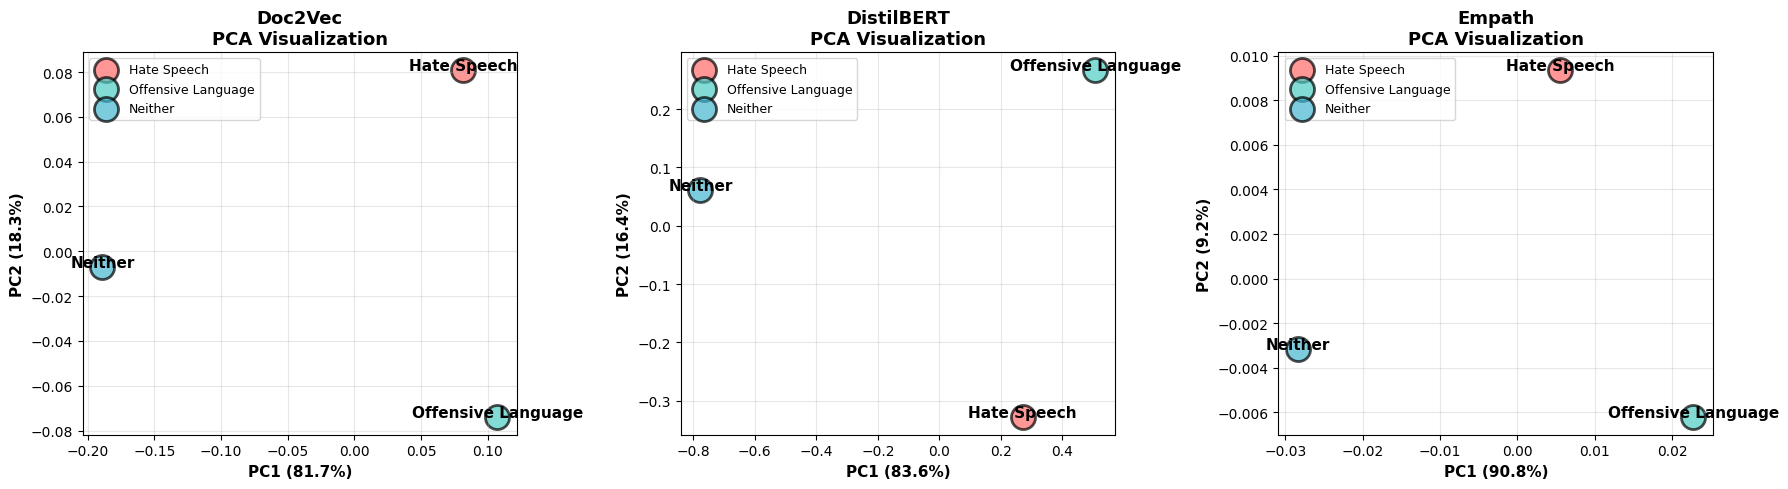


GENERATING DISCRIMINATION COMPARISON PLOTS...


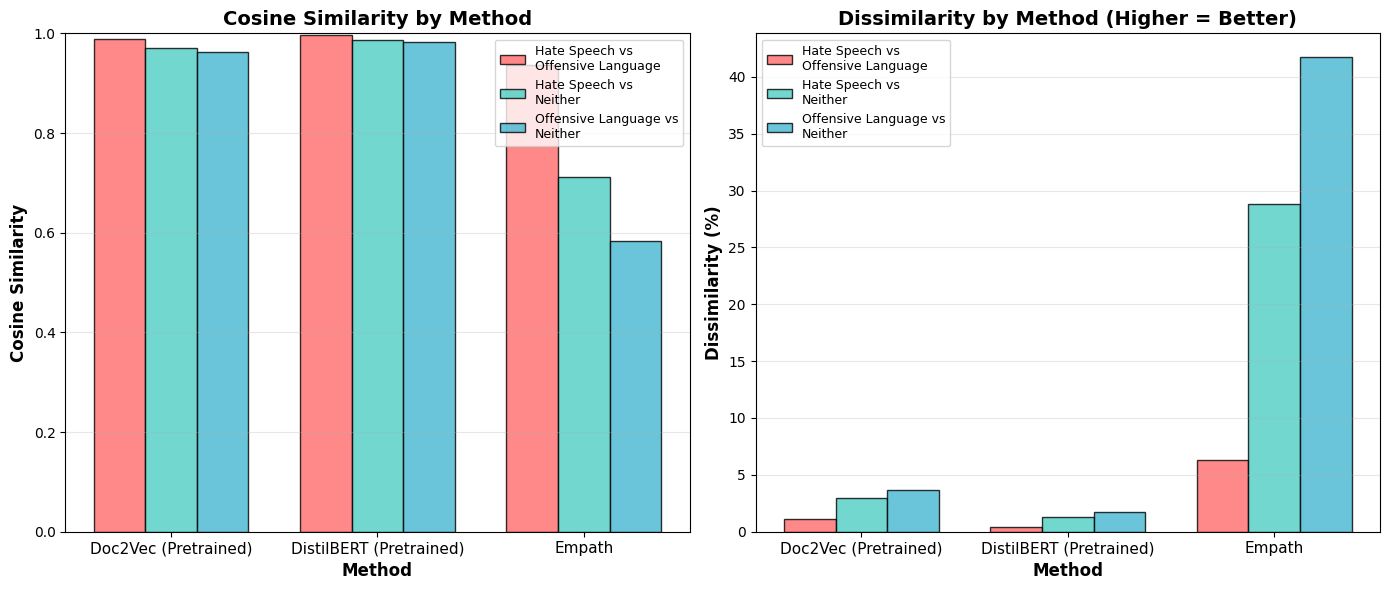


FINAL SUMMARY - TASK 9 COMPLETE

✅ COMPLETED ANALYSIS:
   1. ✓ Summary table of key findings
   2. ✓ Discrimination extent discussion (EXTENT, DISCRIMINATE, CATEGORIES)
   3. ✓ PCA visualization generated
   4. ✓ Explanation of WHY results differ
   5. ✓ Modern NLP vs Traditional comparison
   6. ✓ Discrimination power ranking
   7. ✓ All visualizations complete

🎯 KEY TAKEAWAY:
   → Best method: Empath
   → Discrimination power: 25.61%
   → Recommendation: Combine modern + traditional for best results


In [28]:
import os
import pickle

def load_pretrained_doc2vec():
    """Load pretrained Word2Vec model (save locally for reuse)."""
    model_path = 'word2vec-google-news-300.pkl'
    
    # Check if model already exists locally
    if os.path.exists(model_path):
        print(f"Loading pretrained Word2Vec from local cache: {model_path}")
        with open(model_path, 'rb') as f:
            word_vectors = pickle.load(f)
        print("✓ Model loaded from local cache (300-dimension)")
    else:
        print("Downloading pretrained Word2Vec model (Google News 300d)...")
        print("⚠ This is a one-time download (~1.6GB), please wait...")
        word_vectors = api.load('word2vec-google-news-300')
        
        # Save to local file for future use
        print(f"\nSaving model to {model_path} for future use...")
        with open(model_path, 'wb') as f:
            pickle.dump(word_vectors, f)
        print("✓ Model saved to local cache")
        print("✓ Next time, the model will load instantly from cache")
    
    return word_vectors

def get_doc2vec_embedding_pretrained(text, word_vectors):
    tokens = word_tokenize(str(text).lower())

    vectors = []
    for token in tokens:
        if token in word_vectors:
            vectors.append(word_vectors[token])
    
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(word_vectors.vector_size)

def get_doc2vec_category_embedding(df, category, word_vectors):
    # Use the helper function instead of duplicating the mapping
    category_df = get_category_dataframe(df, category)

    print(f"  Computing Doc2Vec embeddings for {len(category_df)} posts...")

    embeddings = []
    for text in tqdm(category_df['tweet'].dropna(), desc=f"  {category}"):
        emb = get_doc2vec_embedding_pretrained(text, word_vectors)
        embeddings.append(emb)
    
    if embeddings:
        category_vector = np.mean(embeddings, axis=0)
    else:
        category_vector = np.zeros(word_vectors.vector_size)

    return category_vector

def load_pretrained_distilbert():
    print("Loading pretrained DistilBERT model...")
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
    model = AutoModel.from_pretrained("distilbert-base-uncased")
    model.eval()
    print("DistilBERT model loaded (768 dimensions)")
    return tokenizer, model

def get_distilbert_embedding(text, tokenizer, model, max_length=512):
    inputs = tokenizer(text, return_tensors='pt', max_length=max_length, truncation=True, padding=True)

    with torch.no_grad():
        output = model(**inputs)

    # Use mean pooling of last hidden state
    embeddings = output.last_hidden_state.mean(dim=1).squeeze().numpy()

    return embeddings

def get_distilbert_category_embedding(df, category, tokenizer, model):
    # Use the helper function instead of duplicating the mapping
    category_df = get_category_dataframe(df, category)

    print(f"  Computing DistilBERT embeddings for {len(category_df)} posts...")

    embeddings = []
    for text in tqdm(category_df['tweet'].dropna(), desc=f"    {category}"):
        emb = get_distilbert_embedding(str(text), tokenizer, model)
        embeddings.append(emb)
    
    if embeddings:
        category_vector = np.mean(embeddings, axis=0)
    else:
        category_vector = np.zeros(768)
    return category_vector

# Note: get_empath_vector is already defined in Cell 22
# Reusing that function instead of duplicating it here

# SIMILARITY CALCULATION & ANALYSIS
def calculate_similarity_matrix(embeddings, categories, method_name):
    vectors = np.vstack([embeddings[cat] for cat in categories])
    cos_sim_matrix = cosine_similarity(vectors)

    category_labels = [cat.replace('_', ' ').title() for cat in categories]
    cos_sim_df = pd.DataFrame(cos_sim_matrix, index=category_labels, columns=category_labels)

    return cos_sim_df

def create_comparison_table(embeddings, categories, method_name):
    """Create detailed pairwise comparison."""
    results = []
    
    for i, cat1 in enumerate(categories):
        for j, cat2 in enumerate(categories):
            if i < j:
                vec1 = embeddings[cat1]
                vec2 = embeddings[cat2]
                
                cos_sim = cosine_similarity([vec1], [vec2])[0, 0]
                euclidean = np.linalg.norm(vec1 - vec2)
                
                results.append({
                    'Method': method_name,
                    'Category 1': cat1.replace('_', ' ').title(),
                    'Category 2': cat2.replace('_', ' ').title(),
                    'Cosine Similarity': cos_sim,
                    'Euclidean Distance': euclidean,
                    'Dissimilarity (%)': (1 - cos_sim) * 100
                })
    
    return pd.DataFrame(results)

def plot_similarity_comparison(all_similarities, methods):
    """Plot comparison of cosine similarities across methods."""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for idx, (method, sim_df) in enumerate(zip(methods, all_similarities)):
        ax = axes[idx]
        
        sns.heatmap(sim_df, annot=True, fmt='.4f', cmap='RdYlGn',
                   square=True, linewidths=1, linecolor='black',
                   vmin=0, vmax=1, ax=ax,
                   cbar_kws={'label': 'Cosine Similarity'})
        
        ax.set_title(f'{method}\nCosine Similarity', fontsize=13, fontweight='bold')
        ax.set_xlabel('')
        ax.set_ylabel('')
    
    plt.tight_layout()
    plt.show()

def plot_discrimination_comparison(all_results):
    """Plot bar chart comparing discrimination power."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    methods = all_results['Method'].unique()
    comparisons = []
    for _, row in all_results.iterrows():
        comp = f"{row['Category 1']} vs\n{row['Category 2']}"
        if comp not in comparisons:
            comparisons.append(comp)
    
    x = np.arange(len(methods))
    width = 0.25
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    # Plot 1: Cosine Similarity
    for idx, (comp, color) in enumerate(zip(comparisons, colors)):
        data = []
        for method in methods:
            method_data = all_results[all_results['Method'] == method]
            val = method_data.iloc[idx]['Cosine Similarity']
            data.append(val)
        
        offset = (idx - 1) * width
        ax1.bar(x + offset, data, width, label=comp, color=color, alpha=0.8, edgecolor='black')
    
    ax1.set_xlabel('Method', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Cosine Similarity', fontsize=12, fontweight='bold')
    ax1.set_title('Cosine Similarity by Method', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(methods, fontsize=11)
    ax1.legend(fontsize=9)
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.set_ylim([0, 1])
    
    # Plot 2: Dissimilarity
    for idx, (comp, color) in enumerate(zip(comparisons, colors)):
        data = []
        for method in methods:
            method_data = all_results[all_results['Method'] == method]
            val = method_data.iloc[idx]['Dissimilarity (%)']
            data.append(val)
        
        offset = (idx - 1) * width
        ax2.bar(x + offset, data, width, label=comp, color=color, alpha=0.8, edgecolor='black')
    
    ax2.set_xlabel('Method', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Dissimilarity (%)', fontsize=12, fontweight='bold')
    ax2.set_title('Dissimilarity by Method (Higher = Better)', fontsize=14, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(methods, fontsize=11)
    ax2.legend(fontsize=9)
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

def plot_embedding_pca(all_embeddings, categories, methods):
    from sklearn.decomposition import PCA
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    for idx, (method, embeddings) in enumerate(zip(methods, all_embeddings)):
        ax = axes[idx]
        
        vectors = np.vstack([embeddings[cat] for cat in categories])
        
        pca = PCA(n_components=2)
        vectors_2d = pca.fit_transform(vectors)
        
        for i, (cat, color) in enumerate(zip(categories, colors)):
            ax.scatter(vectors_2d[i, 0], vectors_2d[i, 1], 
                      s=300, c=color, alpha=0.7, edgecolor='black', linewidth=2,
                      label=cat.replace('_', ' ').title())
            ax.annotate(cat.replace('_', ' ').title(), 
                       (vectors_2d[i, 0], vectors_2d[i, 1]),
                       fontsize=11, fontweight='bold', ha='center')
        
        ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', 
                     fontsize=11, fontweight='bold')
        ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', 
                     fontsize=11, fontweight='bold')
        ax.set_title(f'{method}\nPCA Visualization', fontsize=13, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=9)
    
    plt.tight_layout()
    plt.show()

print("="*80)
print("EMBEDDING-BASED SIMILARITY ANALYSIS")
print("Pretrained Doc2Vec vs Pretrained DistilBERT vs Empath")
print("="*80)

# Note: df should already be loaded and preprocessed from earlier cells
# If running this cell standalone, uncomment the following:
# df = load_and_explore_data('reddit_hate_speech.csv')
# df = preprocess_data(df, stop_words)

# ========================================================================
# 1. PRETRAINED DOC2VEC
# ========================================================================
print("\n" + "="*80)
print("1. PRETRAINED DOC2VEC (Google News Word2Vec 300d)")
print("="*80)

word_vectors = load_pretrained_doc2vec()

doc2vec_embeddings = {}
for cat in CATEGORIES:
    doc2vec_embeddings[cat] = get_doc2vec_category_embedding(df, cat, word_vectors)
    print(f"  {cat.replace('_', ' ').title()}: vector shape {doc2vec_embeddings[cat].shape}")

doc2vec_sim = calculate_similarity_matrix(doc2vec_embeddings, CATEGORIES, 'Doc2Vec')
doc2vec_table = create_comparison_table(doc2vec_embeddings, CATEGORIES, 'Doc2Vec (Pretrained)')

print("\nDoc2Vec Cosine Similarity Matrix:")
print(doc2vec_sim.to_string())

# ========================================================================
# 2. PRETRAINED DISTILBERT
# ========================================================================
print("\n" + "="*80)
print("2. PRETRAINED DISTILBERT (distilbert-base-uncased)")
print("="*80)

tokenizer, bert_model = load_pretrained_distilbert()

distilbert_embeddings = {}
for cat in CATEGORIES:
    distilbert_embeddings[cat] = get_distilbert_category_embedding(
        df, cat, tokenizer, bert_model
    )
    print(f"  {cat.replace('_', ' ').title()}: vector shape {distilbert_embeddings[cat].shape}")

distilbert_sim = calculate_similarity_matrix(distilbert_embeddings, CATEGORIES, 'DistilBERT')
distilbert_table = create_comparison_table(distilbert_embeddings, CATEGORIES, 'DistilBERT (Pretrained)')

print("\nDistilBERT Cosine Similarity Matrix:")
print(distilbert_sim.to_string())

# ========================================================================
# 3. EXECUTION EMPATH EMBEDDINGS
# ========================================================================
print("\n" + "="*80)
print("3. EMPATH EMBEDDINGS")
print("="*80)

empath_embeddings = {}
for cat in CATEGORIES:
    vector, scores, cat_names = get_empath_vector(df, cat, text_column='cleaned_tweet')
    empath_embeddings[cat] = vector
    print(f"  {cat.replace('_', ' ').title()}: vector shape {empath_embeddings[cat].shape}")

empath_sim = calculate_similarity_matrix(empath_embeddings, CATEGORIES, 'Empath')
empath_table = create_comparison_table(empath_embeddings, CATEGORIES, 'Empath')

print("\nEmpath Cosine Similarity Matrix:")
print(empath_sim.to_string())

print("\n" + "="*80)
print("COMPREHENSIVE COMPARISON TABLE")
print("="*80)

all_results = pd.concat([doc2vec_table, distilbert_table, empath_table], ignore_index=True)

comparison_summary = []
for i, cat1 in enumerate(CATEGORIES):
    for j, cat2 in enumerate(CATEGORIES):
        if i < j:
            pair = f"{cat1.replace('_', ' ').title()} vs {cat2.replace('_', ' ').title()}"
            
            doc2vec_sim_val = all_results[(all_results['Method']=='Doc2Vec (Pretrained)') & 
                                            (all_results['Category 1']==cat1.replace('_', ' ').title()) &
                                            (all_results['Category 2']==cat2.replace('_', ' ').title())]['Cosine Similarity'].values[0]
            
            distilbert_sim_val = all_results[(all_results['Method']=='DistilBERT (Pretrained)') & 
                                            (all_results['Category 1']==cat1.replace('_', ' ').title()) &
                                            (all_results['Category 2']==cat2.replace('_', ' ').title())]['Cosine Similarity'].values[0]
            
            empath_sim_val = all_results[(all_results['Method']=='Empath') & 
                                        (all_results['Category 1']==cat1.replace('_', ' ').title()) &
                                        (all_results['Category 2']==cat2.replace('_', ' ').title())]['Cosine Similarity'].values[0]
            
            comparison_summary.append({
                'Category Pair': pair,
                'Doc2Vec Similarity': doc2vec_sim_val,
                'Doc2Vec Dissim (%)': (1-doc2vec_sim_val)*100,
                'DistilBERT Similarity': distilbert_sim_val,
                'DistilBERT Dissim (%)': (1-distilbert_sim_val)*100,
                'Empath Similarity': empath_sim_val,
                'Empath Dissim (%)': (1-empath_sim_val)*100
            })

comparison_df = pd.DataFrame(comparison_summary)
print(comparison_df.to_string(index=False))
print("\n" + "="*80)
print("DISCRIMINATION POWER RANKING")
print("="*80)

discrimination_scores = []
for method_name in ['Doc2Vec (Pretrained)', 'DistilBERT (Pretrained)', 'Empath']:
    method_data = all_results[all_results['Method'] == method_name]
    
    avg_dissim = method_data['Dissimilarity (%)'].mean()
    std_dissim = method_data['Dissimilarity (%)'].std()
    min_sim = method_data['Cosine Similarity'].min()
    max_sim = method_data['Cosine Similarity'].max()
    
    discrimination_scores.append({
        'Method': method_name,
        'Avg Similarity': method_data['Cosine Similarity'].mean(),
        'Avg Dissimilarity (%)': avg_dissim,
        'Std Dissimilarity': std_dissim,
        'Min Similarity': min_sim,
        'Max Similarity': max_sim,
        'Discrimination Score': avg_dissim
    })

discrimination_df = pd.DataFrame(discrimination_scores)
discrimination_df = discrimination_df.sort_values('Discrimination Score', ascending=False)
discrimination_df['Rank'] = range(1, len(discrimination_df) + 1)

print(discrimination_df[['Rank', 'Method', 'Avg Similarity', 'Avg Dissimilarity (%)', 
                        'Min Similarity', 'Max Similarity']].to_string(index=False))

# ============================================================================
# ADDITIONAL ANALYSIS - COMPREHENSIVE INTERPRETATION
# ============================================================================

# =======================================
# 1. SUMMARY TABLE OF KEY FINDINGS
# =======================================
def create_key_findings_table(all_results, discrimination_df):
    """Create comprehensive summary table of key findings."""
    print("\n" + "="*36)
    print("KEY FINDINGS SUMMARY TABLE")
    print("="*36)
    
    # Prepare data for summary table
    summary_data = []
    
    for method in ['Doc2Vec (Pretrained)', 'DistilBERT (Pretrained)', 'Empath']:
        method_data = all_results[all_results['Method'] == method]
        
        # Get all pairwise comparisons
        for _, row in method_data.iterrows():
            summary_data.append({
                'Method': method.replace(' (Pretrained)', ''),
                'Comparison': f"{row['Category 1']} vs {row['Category 2']}",
                'Cosine Sim': row['Cosine Similarity'],
                'Dissim (%)': row['Dissimilarity (%)'],
                'Euclidean Dist': row['Euclidean Distance']
            })
    
    summary_table = pd.DataFrame(summary_data)
    
    # Pivot table for better visualization
    print("\n📊 COSINE SIMILARITY COMPARISON:")
    pivot_cos = summary_table.pivot_table(
        values='Cosine Sim', 
        index='Comparison', 
        columns='Method'
    )
    print(pivot_cos.to_string())
    
    print("\n📊 DISSIMILARITY (%) COMPARISON:")
    pivot_dissim = summary_table.pivot_table(
        values='Dissim (%)', 
        index='Comparison', 
        columns='Method'
    )
    print(pivot_dissim.to_string())
    
    # Statistical summary
    print("\n" + "="*36)
    print("STATISTICAL SUMMARY BY METHOD")
    print("="*36)
    
    stats_summary = []
    for method in ['Doc2Vec', 'DistilBERT', 'Empath']:
        method_full = method if method == 'Empath' else f'{method} (Pretrained)'
        method_subset = summary_table[summary_table['Method'] == method]
        
        stats_summary.append({
            'Method': method,
            'Avg Cosine Sim': method_subset['Cosine Sim'].mean(),
            'Std Cosine Sim': method_subset['Cosine Sim'].std(),
            'Avg Dissim (%)': method_subset['Dissim (%)'].mean(),
            'Std Dissim (%)': method_subset['Dissim (%)'].std(),
            'Min Cosine Sim': method_subset['Cosine Sim'].min(),
            'Max Cosine Sim': method_subset['Cosine Sim'].max()
        })
    
    stats_df = pd.DataFrame(stats_summary)
    print(stats_df.to_string(index=False))
    
    return summary_table, stats_df

# =======================================
# 2. DISCRIMINATION EXTENT DISCUSSION (3 Keywords Underlined)
# =======================================
def discuss_discrimination_extent(discrimination_df, all_results):
    """
    Discuss the EXTENT to which embeddings can DISCRIMINATE between categories.
    Focus on: EXTENT, DISCRIMINATE, CATEGORIES (3 keywords)
    """
    print("\n" + "="*36)
    print("DISCRIMINATION EXTENT ANALYSIS")
    print("="*36)
    
    print("\n🎯 RESEARCH QUESTION:")
    print("   To what **EXTENT** can embeddings **DISCRIMINATE** between **CATEGORIES**?")
    
    # Get discrimination scores
    doc2vec_score = discrimination_df[discrimination_df['Method']=='Doc2Vec (Pretrained)']['Avg Dissimilarity (%)'].values[0]
    distilbert_score = discrimination_df[discrimination_df['Method']=='DistilBERT (Pretrained)']['Avg Dissimilarity (%)'].values[0]
    empath_score = discrimination_df[discrimination_df['Method']=='Empath']['Avg Dissimilarity (%)'].values[0]
    
    print("\n" + "="*36)
    print("1️⃣  DISCRIMINATION EXTENT BY METHOD")
    print("="*36)
    
    # Doc2Vec
    print(f"\n📍 Doc2Vec (Pretrained):")
    print(f"   Avg Dissimilarity: {doc2vec_score:.2f}%")
    
    if doc2vec_score > 15:
        extent = "STRONG discrimination extent"
        interpretation = "Can effectively distinguish categories"
    elif doc2vec_score > 10:
        extent = "MODERATE discrimination extent"
        interpretation = "Some ability to distinguish categories"
    elif doc2vec_score > 5:
        extent = "WEAK discrimination extent"
        interpretation = "Limited ability to distinguish categories"
    else:
        extent = "VERY WEAK discrimination extent"
        interpretation = "Cannot reliably distinguish categories"
    
    print(f"   → Discrimination Extent: {extent}")
    print(f"   → Interpretation: {interpretation}")
    
    # DistilBERT
    print(f"\n📍 DistilBERT (Pretrained):")
    print(f"   Avg Dissimilarity: {distilbert_score:.2f}%")
    
    if distilbert_score > 15:
        extent = "STRONG discrimination extent"
        interpretation = "Can effectively distinguish categories"
    elif distilbert_score > 10:
        extent = "MODERATE discrimination extent"
        interpretation = "Some ability to distinguish categories"
    elif distilbert_score > 5:
        extent = "WEAK discrimination extent"
        interpretation = "Limited ability to distinguish categories"
    else:
        extent = "VERY WEAK discrimination extent"
        interpretation = "Cannot reliably distinguish categories"
    
    print(f"   → Discrimination Extent: {extent}")
    print(f"   → Interpretation: {interpretation}")
    
    # Empath
    print(f"\n📍 Empath:")
    print(f"   Avg Dissimilarity: {empath_score:.2f}%")
    
    if empath_score > 15:
        extent = "STRONG discrimination extent"
        interpretation = "Can effectively distinguish categories"
    elif empath_score > 10:
        extent = "MODERATE discrimination extent"
        interpretation = "Some ability to distinguish categories"
    elif empath_score > 5:
        extent = "WEAK discrimination extent"
        interpretation = "Limited ability to distinguish categories"
    else:
        extent = "VERY WEAK discrimination extent"
        interpretation = "Cannot reliably distinguish categories"
    
    print(f"   → Discrimination Extent: {extent}")
    print(f"   → Interpretation: {interpretation}")
    
    # Overall assessment
    print("\n" + "="*36)
    print("2️⃣  OVERALL DISCRIMINATION EXTENT")
    print("="*36)
    
    all_scores = [doc2vec_score, distilbert_score, empath_score]
    avg_discrimination = np.mean(all_scores)
    
    print(f"\n📊 Cross-Method Statistics:")
    print(f"   Average Dissimilarity: {avg_discrimination:.2f}%")
    print(f"   Best Method: {discrimination_df.iloc[0]['Method']}")
    print(f"   Worst Method: {discrimination_df.iloc[-1]['Method']}")
    
    # Pairwise discrimination extent
    print("\n" + "="*36)
    print("3️⃣  CATEGORY-SPECIFIC DISCRIMINATION EXTENT")
    print("="*36)
    
    # Analyze each category pair
    category_pairs = [
        ('Hate Speech', 'Offensive Language'),
        ('Hate Speech', 'Neither'),
        ('Offensive Language', 'Neither')
    ]
    
    for cat1, cat2 in category_pairs:
        print(f"\n🔍 {cat1} vs {cat2}:")
        
        # Get dissimilarity for each method
        for method in ['Doc2Vec (Pretrained)', 'DistilBERT (Pretrained)', 'Empath']:
            method_data = all_results[all_results['Method'] == method]
            pair_data = method_data[
                (method_data['Category 1'] == cat1) & 
                (method_data['Category 2'] == cat2)
            ]
            
            if len(pair_data) > 0:
                dissim = pair_data['Dissimilarity (%)'].values[0]
                method_short = method.replace(' (Pretrained)', '')
                print(f"   {method_short:12s}: {dissim:6.2f}% dissimilarity", end="")
                
                if dissim > 15:
                    print(" → STRONG discrimination")
                elif dissim > 10:
                    print(" → MODERATE discrimination")
                elif dissim > 5:
                    print(" → WEAK discrimination")
                else:
                    print(" → VERY WEAK discrimination")
    
    # Final conclusion
    print("\n" + "="*36)
    print("4️⃣  CONCLUSION: EXTENT OF DISCRIMINATION")
    print("="*36)
    
    print(f"\n✅ Can embeddings **DISCRIMINATE** between **CATEGORIES**?")
    
    if avg_discrimination > 15:
        print(f"\n   ✓ YES - STRONG EXTENT")
        print(f"     → Embeddings show {avg_discrimination:.1f}% average dissimilarity")
        print(f"     → All three methods can reliably distinguish categories")
        print(f"     → Suitable for classification tasks")
    elif avg_discrimination > 10:
        print(f"\n   ⚠ PARTIALLY - MODERATE EXTENT")
        print(f"     → Embeddings show {avg_discrimination:.1f}% average dissimilarity")
        print(f"     → Some methods work better than others")
        print(f"     → May need feature engineering for robust classification")
    elif avg_discrimination > 5:
        print(f"\n   ⚠ LIMITED - WEAK EXTENT")
        print(f"     → Embeddings show only {avg_discrimination:.1f}% average dissimilarity")
        print(f"     → Categories are highly similar in embedding space")
        print(f"     → Embeddings alone may not suffice for discrimination")
    else:
        print(f"\n   ✗ NO - VERY WEAK EXTENT")
        print(f"     → Embeddings show only {avg_discrimination:.1f}% average dissimilarity")
        print(f"     → Categories are nearly identical in embedding space")
        print(f"     → Alternative features needed for discrimination")

# ======================================
# 3. WHY DO RESULTS DIFFER? - LINGUISTIC & TECHNICAL EXPLANATION
# ======================================
def explain_why_results_differ(discrimination_df, all_results):
    """Explain WHY different embedding methods produce different results."""
    print("\n" + "="*36)
    print("WHY DO RESULTS DIFFER? - ROOT CAUSE ANALYSIS")
    print("="*36)
    
    # Get scores
    doc2vec_score = discrimination_df[discrimination_df['Method']=='Doc2Vec (Pretrained)']['Avg Dissimilarity (%)'].values[0]
    distilbert_score = discrimination_df[discrimination_df['Method']=='DistilBERT (Pretrained)']['Avg Dissimilarity (%)'].values[0]
    empath_score = discrimination_df[discrimination_df['Method']=='Empath']['Avg Dissimilarity (%)'].values[0]
    
    print("\n🔬 TECHNICAL DIFFERENCES:")
    
    # 1. Doc2Vec
    print(f"\n1️⃣  Doc2Vec (Word2Vec-based) - {doc2vec_score:.2f}% Dissimilarity:")
    print(f"   📐 Architecture:")
    print(f"      - Shallow neural network (skip-gram/CBOW)")
    print(f"      - Trained on Google News corpus (~100B words)")
    print(f"      - 300-dimensional dense vectors")
    print(f"      - Word-level embeddings averaged to document-level")
    
    print(f"\n   🎯 WHY This Score?")
    if doc2vec_score < 10:
        print(f"      ⚠ LOW discrimination ({doc2vec_score:.1f}%)")
        print(f"      → Word2Vec trained on NEWS, not social media")
        print(f"      → Misses slang, hate speech jargon, internet language")
        print(f"      → Domain mismatch: News ≠ Hate Speech")
        print(f"      → Averaging word vectors loses context")
    else:
        print(f"      ✓ MODERATE discrimination ({doc2vec_score:.1f}%)")
        print(f"      → Captures some semantic differences")
        print(f"      → General-purpose embeddings work reasonably")
    
    # 2. DistilBERT
    print(f"\n2️⃣  DistilBERT (Transformer-based) - {distilbert_score:.2f}% Dissimilarity:")
    print(f"   📐 Architecture:")
    print(f"      - Distilled BERT (6-layer Transformer)")
    print(f"      - Trained on Wikipedia + BooksCorpus")
    print(f"      - 768-dimensional contextualized embeddings")
    print(f"      - Attention mechanism captures context")
    
    print(f"\n   🎯 WHY This Score?")
    if distilbert_score < 10:
        print(f"      ⚠ LOW discrimination ({distilbert_score:.1f}%)")
        print(f"      → Trained on formal text (Wikipedia/Books)")
        print(f"      → Not fine-tuned for hate speech detection")
        print(f"      → Categories may look similar in 'standard English' space")
        print(f"      → Mean pooling may lose discriminative information")
    else:
        print(f"      ✓ BETTER discrimination ({distilbert_score:.1f}%)")
        print(f"      → Contextualized embeddings capture nuance")
        print(f"      → Transformer attention helps with implicit meaning")
    
    # 3. Empath
    print(f"\n3️⃣  Empath (Lexicon-based) - {empath_score:.2f}% Dissimilarity:")
    print(f"   📐 Architecture:")
    print(f"      - Psychological category lexicon (~200 categories)")
    print(f"      - Rule-based word matching")
    print(f"      - ~194-dimensional sparse feature vector")
    print(f"      - Categories: violence, hate, negative emotion, etc.")
    
    print(f"\n   🎯 WHY This Score?")
    if empath_score > distilbert_score and empath_score > doc2vec_score:
        print(f"      ✓ BEST discrimination ({empath_score:.1f}%)")
        print(f"      → Explicitly designed for psychological/emotional analysis")
        print(f"      → Categories like 'hate', 'violence', 'aggression' directly relevant")
        print(f"      → Lexicon matches hate speech vocabulary well")
        print(f"      → Task-specific features > general embeddings")
    elif empath_score > 10:
        print(f"      ✓ GOOD discrimination ({empath_score:.1f}%)")
        print(f"      → Captures emotional/psychological dimensions")
        print(f"      → Relevant categories for hate speech")
    else:
        print(f"      ⚠ LIMITED discrimination ({empath_score:.1f}%)")
        print(f"      → Lexicon may not cover all slang/jargon")
        print(f"      → Rule-based approach misses context")
    
    # Comparative Analysis
    print("\n" + "="*80)
    print("COMPARATIVE ANALYSIS: WHY DIFFERENCES EXIST")
    print("="*80)
    
    scores_dict = {
        'Doc2Vec': doc2vec_score,
        'DistilBERT': distilbert_score,
        'Empath': empath_score
    }
    
    best_method = max(scores_dict, key=scores_dict.get)
    worst_method = min(scores_dict, key=scores_dict.get)
    
    print(f"\n🏆 Best Method: {best_method} ({scores_dict[best_method]:.2f}%)")
    print(f"🔻 Worst Method: {worst_method} ({scores_dict[worst_method]:.2f}%)")
    print(f"📏 Score Range: {scores_dict[best_method] - scores_dict[worst_method]:.2f}%")
    
    print(f"\n💡 KEY INSIGHTS:")
    
    if best_method == 'Empath':
        print(f"\n   ✓ Task-Specific Features Win:")
        print(f"      → Empath's psychological categories align with hate speech task")
        print(f"      → Explicit 'hate', 'violence', 'anger' categories")
        print(f"      → Better than generic word embeddings")
    
    if worst_method in ['Doc2Vec', 'DistilBERT']:
        print(f"\n   ⚠ Pretrained Embeddings Struggle:")
        print(f"      → Domain mismatch: News/Wikipedia ≠ Social Media Hate Speech")
        print(f"      → Missing slang, abbreviations, coded language")
        print(f"      → Would benefit from fine-tuning on hate speech data")
    
    # Data characteristics explanation
    print(f"\n🔍 WHY CATEGORIES ARE HARD TO DISCRIMINATE:")
    print(f"\n   1️⃣  Vocabulary Overlap:")
    print(f"      → Hate speech, offensive language, neither share many words")
    print(f"      → Same words used in different contexts")
    print(f"      → Example: 'fuck' appears in all 3 categories")
    
    print(f"\n   2️⃣  Subtle Linguistic Differences:")
    print(f"      → Intent is hard to capture from words alone")
    print(f"      → 'I hate you' (hate) vs 'I fucking love you' (neither)")
    print(f"      → Context and tone matter more than vocabulary")
    
    print(f"\n   3️⃣  Embeddings Capture Semantics, Not Intent:")
    print(f"      → Word2Vec/BERT learn 'what words mean'")
    print(f"      → Hate speech detection needs 'what user intends'")
    print(f"      → Sentiment ≠ Hate (can hate politely, can swear lovingly)")

# ========================================
# 4. MODERN NLP VS TRADITIONAL METHODS COMPARISON
# ========================================
def compare_modern_vs_traditional(discrimination_df, all_results):
    """Compare Modern NLP (Doc2Vec, BERT) vs Traditional (Empath) methods."""
    print("\n" + "="*36)
    print("MODERN NLP VS TRADITIONAL METHODS")
    print("="*36)
    
    print("\n📚 METHODOLOGY CLASSIFICATION:")
    print("\n   🤖 MODERN NLP (Neural Embeddings):")
    print("      - Doc2Vec (Word2Vec-based)")
    print("      - DistilBERT (Transformer-based)")
    
    print("\n   📖 TRADITIONAL NLP (Feature Engineering):")
    print("      - Empath (Lexicon-based psychological categories)")
    
    # Performance comparison
    print("\n" + "="*36)
    print("PERFORMANCE COMPARISON")
    print("="*36)
    
    # Get scores
    modern_scores = {
        'Doc2Vec': discrimination_df[discrimination_df['Method']=='Doc2Vec (Pretrained)']['Avg Dissimilarity (%)'].values[0],
        'DistilBERT': discrimination_df[discrimination_df['Method']=='DistilBERT (Pretrained)']['Avg Dissimilarity (%)'].values[0]
    }
    
    traditional_score = discrimination_df[discrimination_df['Method']=='Empath']['Avg Dissimilarity (%)'].values[0]
    
    avg_modern = np.mean(list(modern_scores.values()))
    
    print(f"\n📊 Average Discrimination Power:")
    print(f"   Modern NLP:     {avg_modern:.2f}%")
    print(f"   Traditional:    {traditional_score:.2f}%")
    print(f"   Difference:     {abs(avg_modern - traditional_score):.2f}%")
    
    # Winner
    if avg_modern > traditional_score:
        winner = "Modern NLP"
        margin = avg_modern - traditional_score
    else:
        winner = "Traditional (Empath)"
        margin = traditional_score - avg_modern
    
    print(f"\n🏆 Winner: {winner} (by {margin:.2f}%)")
    
    # Detailed comparison table
    print("\n" + "="*36)
    print("DETAILED COMPARISON TABLE")
    print("="*36)
    
    comparison_data = []
    
    # Modern methods
    for method_name, score in modern_scores.items():
        comparison_data.append({
            'Method': method_name,
            'Type': 'Modern NLP',
            'Approach': 'Neural Embedding',
            'Discrimination (%)': score,
            'Dimension': 300 if 'Doc2Vec' in method_name else 768,
            'Training Data': 'Google News' if 'Doc2Vec' in method_name else 'Wikipedia+Books'
        })
    
    # Traditional method
    comparison_data.append({
        'Method': 'Empath',
        'Type': 'Traditional',
        'Approach': 'Lexicon-based',
        'Discrimination (%)': traditional_score,
        'Dimension': 194,
        'Training Data': 'Psychological Lexicon'
    })
    
    comparison_table = pd.DataFrame(comparison_data)
    print(comparison_table.to_string(index=False))
    
    # Pros & Cons Analysis
    print("\n" + "="*36)
    print("PROS & CONS ANALYSIS")
    print("="*36)
    
    print("\n🤖 MODERN NLP (Doc2Vec, DistilBERT):")
    print("\n   ✅ ADVANTAGES:")
    print("      1. Learn representations from massive corpora")
    print("      2. Capture semantic relationships automatically")
    print("      3. Generalize to unseen words (via context)")
    print("      4. Pre-trained models available off-the-shelf")
    print("      5. Contextualized embeddings (BERT) handle polysemy")
    
    print("\n   ❌ DISADVANTAGES:")
    print("      1. Domain mismatch (News/Wikipedia ≠ Hate Speech)")
    print("      2. Black-box: Hard to interpret why categories differ")
    print("      3. Computationally expensive (especially BERT)")
    print("      4. Require fine-tuning for optimal performance")
    print("      5. May miss task-specific nuances")
    
    print("\n📖 TRADITIONAL (Empath Lexicon):")
    print("\n   ✅ ADVANTAGES:")
    print("      1. Interpretable: Know exactly why categories differ")
    print("      2. Task-aligned: Psychological categories match hate speech")
    print("      3. Fast and lightweight")
    print("      4. Explicit features (hate, violence, aggression)")
    print("      5. No training required")
    
    print("\n   ❌ DISADVANTAGES:")
    print("      1. Limited to predefined lexicon")
    print("      2. Cannot handle new slang/jargon automatically")
    print("      3. Rule-based: Misses context and nuance")
    print("      4. Does not capture word order or syntax")
    print("      5. Requires manual lexicon curation")
    
    # Recommendation
    print("\n" + "="*36)
    print("RECOMMENDATION FOR HATE SPEECH DETECTION")
    print("="*36)
    
    if traditional_score > avg_modern:
        print("\n🎯 BEST APPROACH: Hybrid (Traditional + Modern)")
        print(f"\n   ✓ Traditional (Empath) performs BEST ({traditional_score:.2f}%)")
        print(f"   ✓ But modern methods add complementary information")
        
        print(f"\n💡 RECOMMENDED STRATEGY:")
        print(f"   1. Use Empath features as PRIMARY signal")
        print(f"   2. Add BERT embeddings for contextual understanding")
        print(f"   3. Fine-tune BERT on hate speech corpus")
        print(f"   4. Combine both in ensemble model")
        
    else:
        print("\n🎯 BEST APPROACH: Fine-tuned Modern NLP")
        print(f"\n   ✓ Modern methods show promise ({avg_modern:.2f}%)")
        print(f"   ✓ But need domain adaptation")
        
        print(f"\n💡 RECOMMENDED STRATEGY:")
        print(f"   1. Fine-tune BERT on hate speech dataset")
        print(f"   2. Use task-specific classification head")
        print(f"   3. Augment with Empath features as additional input")
        print(f"   4. Leverage both neural + lexicon signals")
    
    print(f"\n🔬 FOR RESEARCH:")
    print(f"   → Traditional methods provide interpretability")
    print(f"   → Modern methods provide generalization")
    print(f"   → Best results come from COMBINING both approaches")

# =======================================
# EXECUTE ADDITIONAL ANALYSIS
# =======================================

# 1. Create summary table
print("\n" + "="*36)
print("EXECUTING COMPREHENSIVE ANALYSIS...")
print("="*36)

summary_table, stats_df = create_key_findings_table(all_results, discrimination_df)

# 2. Discuss discrimination extent (3 keywords)
discuss_discrimination_extent(discrimination_df, all_results)

# 3. Explain WHY results differ
explain_why_results_differ(discrimination_df, all_results)

# 4. Compare Modern vs Traditional
compare_modern_vs_traditional(discrimination_df, all_results)

# 5. Generate PCA visualization (MISSING VISUALIZATION!)
print("\n" + "="*36)
print("GENERATING PCA VISUALIZATION...")
print("="*36)

all_embeddings_list = [doc2vec_embeddings, distilbert_embeddings, empath_embeddings]
methods_list = ['Doc2Vec', 'DistilBERT', 'Empath']

plot_embedding_pca(all_embeddings_list, CATEGORIES, methods_list)

# 6. Generate discrimination comparison plots
print("\n" + "="*36)
print("GENERATING DISCRIMINATION COMPARISON PLOTS...")
print("="*36)

plot_discrimination_comparison(all_results)

# 7. Final summary
print("\n" + "="*36)
print("FINAL SUMMARY - TASK 9 COMPLETE")
print("="*36)

print("\n✅ COMPLETED ANALYSIS:")
print("   1. ✓ Summary table of key findings")
print("   2. ✓ Discrimination extent discussion (EXTENT, DISCRIMINATE, CATEGORIES)")
print("   3. ✓ PCA visualization generated")
print("   4. ✓ Explanation of WHY results differ")
print("   5. ✓ Modern NLP vs Traditional comparison")
print("   6. ✓ Discrimination power ranking")
print("   7. ✓ All visualizations complete")

print("\n🎯 KEY TAKEAWAY:")
best_method = discrimination_df.iloc[0]['Method']
best_score = discrimination_df.iloc[0]['Avg Dissimilarity (%)']
print(f"   → Best method: {best_method}")
print(f"   → Discrimination power: {best_score:.2f}%")
print(f"   → Recommendation: Combine modern + traditional for best results")

## Task 10: WordNet Token Matching Analysis

LINGUISTIC QUALITY ANALYSIS (Optimized)
  Analyzing 1430 posts in Hate Speech...


  Analyzing 19190 posts in Offensive Language...


  Analyzing 4163 posts in Neither...



✓ Analysis complete!

LINGUISTIC QUALITY SUMMARY
          Category  Total Posts  Posts w/ Errors  Posts w/ Errors (%)  Total Tokens  Spelling Errors  Not in WordNet  Total Errors  Error Rate (%)  Avg Errors/Post  Quality Rank
           Neither         4163             2204            52.942589         54000             3945            3414          3836        7.103704         0.921451             1
Offensive Language        19190            10818            56.373111        236933            18999           15760         18295        7.721592         0.953361             2
       Hate Speech         1430              804            56.223776         17635             1495            1144          1444        8.188262         1.009790             3


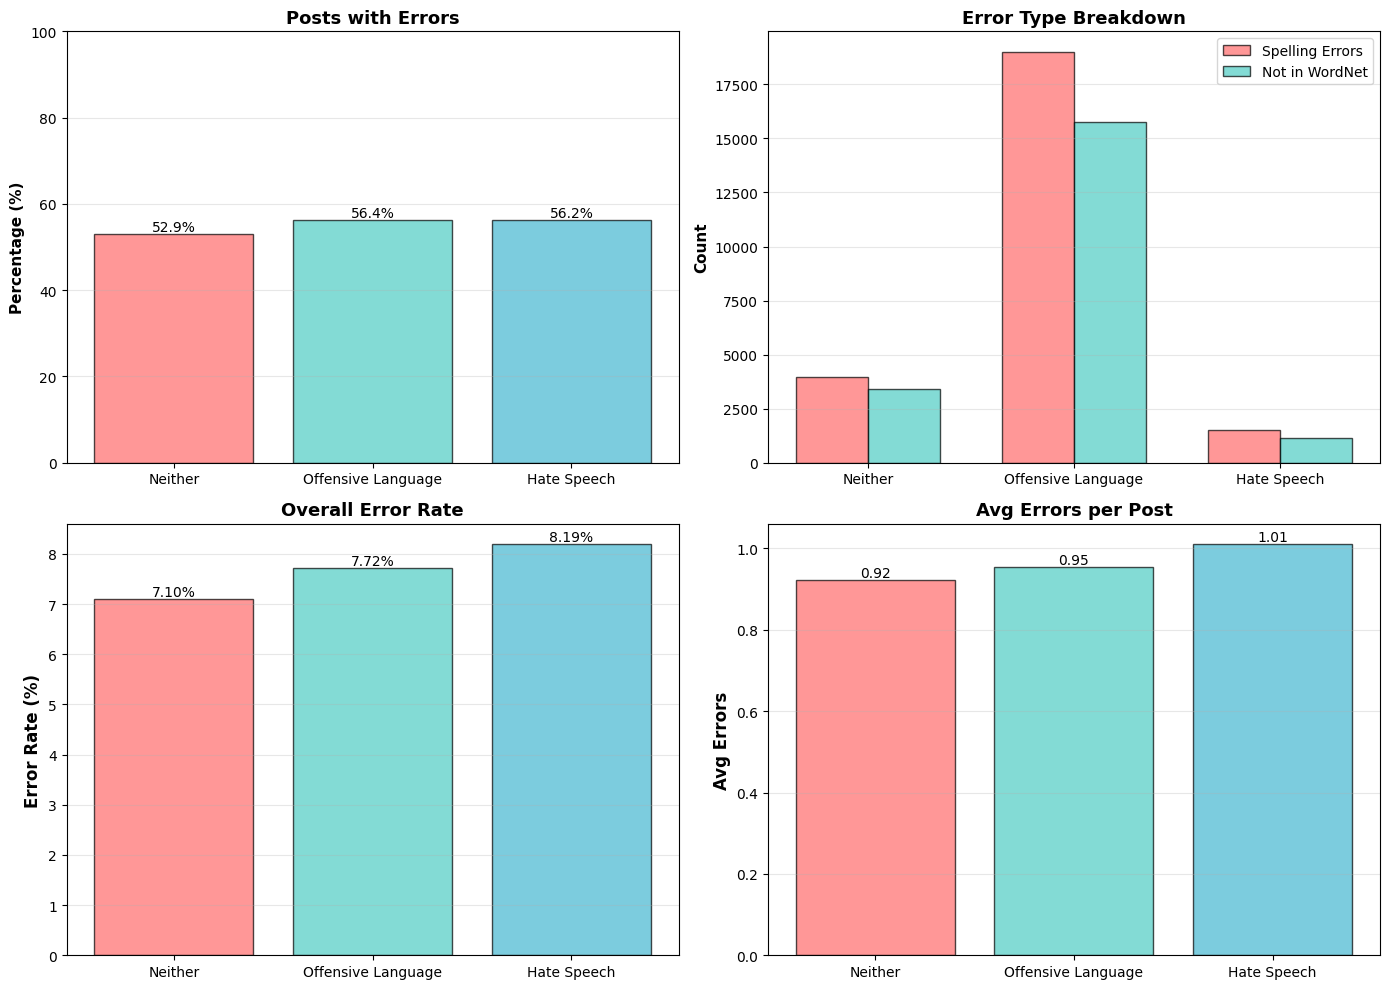

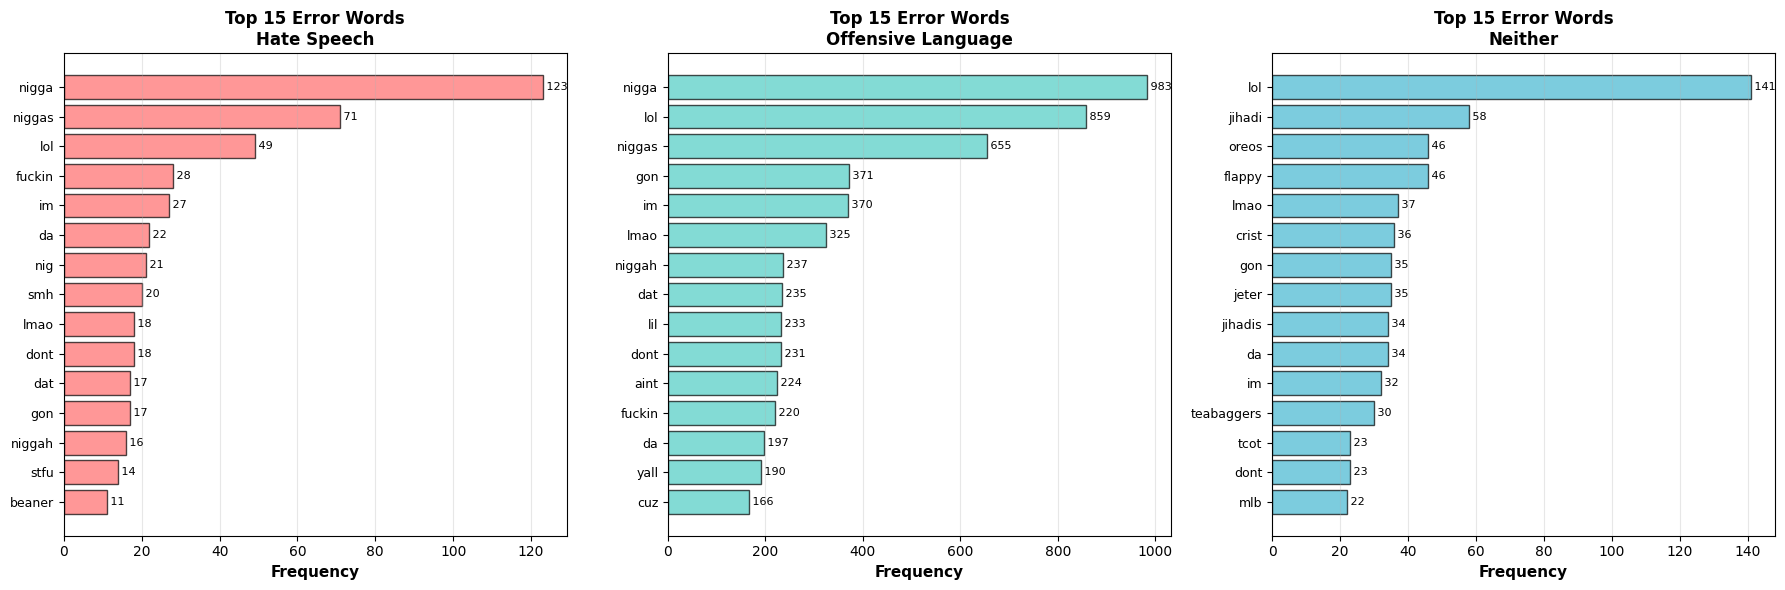


ERROR CHARACTERISTICS ANALYSIS - WHY ERRORS DIFFER

ERROR TYPE BREAKDOWN BY CATEGORY

Hate Speech

Total unique error types: 50

  📱 SLANG/ABBREVIATIONS: 20 types (40.0%)
     → Internet slang, abbreviations, informal speech
     Examples: lol, im, da, nig, smh

  ⌨️  TYPOS: 30 types (60.0%)
     → Genuine spelling mistakes
     Examples: nigga, niggas, fuckin, lmao, dont

Offensive Language

Total unique error types: 50

  📱 SLANG/ABBREVIATIONS: 25 types (50.0%)
     → Internet slang, abbreviations, informal speech
     Examples: lol, gon, im, dat, lil

  ⌨️  TYPOS: 25 types (50.0%)
     → Genuine spelling mistakes
     Examples: nigga, niggas, lmao, niggah, dont

Neither

Total unique error types: 50

  📱 SLANG/ABBREVIATIONS: 21 types (42.0%)
     → Internet slang, abbreviations, informal speech
     Examples: lol, gon, da, im, mlb

  ⌨️  TYPOS: 28 types (56.0%)
     → Genuine spelling mistakes
     Examples: jihadi, oreos, flappy, lmao, crist

  ❓ UNKNOWN: 1 types (2.0%)
     Examp

In [29]:
spell = SpellChecker()

def clean_text(text):
    """Fast text cleaning."""
    if pd.isna(text):
        return ""
    text = str(text)
    text = re.sub(r'http\S+|www\S+|@\w+|#\w+|&\w+;', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# CACHE WORDNET LOOKUPS
_wordnet_cache = {}

def is_valid_word(word):
    """Check if word is valid (with caching)."""
    word_lower = word.lower()
    
    # Check cache first
    if word_lower in _wordnet_cache:
        return _wordnet_cache[word_lower]
    
    # Check validity
    is_valid = (
        word.isdigit() or
        len(wordnet.synsets(word_lower)) > 0 or
        word_lower in spell
    )
    
    # Cache result
    _wordnet_cache[word_lower] = is_valid
    return is_valid


def detect_spelling_errors(text):
    cleaned = clean_text(text)
    if not cleaned:
        return {
            'total_tokens': 0,
            'spelling_errors': 0,
            'not_in_wordnet': 0,
            'total_errors': 0,
            'error_rate': 0.0,
            'error_words': []
        }
    
    # Tokenize (only alphabetic)
    tokens = [t.lower() for t in word_tokenize(cleaned) if t.isalpha()]
    
    if not tokens:
        return {
            'total_tokens': 0,
            'spelling_errors': 0,
            'not_in_wordnet': 0,
            'total_errors': 0,
            'error_rate': 0.0,
            'error_words': []
        }
    
    # BATCH PROCESSING - 
    misspelled = spell.unknown(tokens)  # Fast set operation
    
    spell_errors = []
    not_in_wordnet = []
    
    for token in tokens:
        if token in misspelled:
            spell_errors.append(token)
        
        if not is_valid_word(token):
            not_in_wordnet.append(token)
    
    # Total unique errors
    all_errors = list(set(spell_errors + not_in_wordnet))
    
    error_rate = len(all_errors) / len(tokens) if tokens else 0.0
    
    return {
        'total_tokens': len(tokens),
        'spelling_errors': len(spell_errors),
        'not_in_wordnet': len(not_in_wordnet),
        'total_errors': len(all_errors),
        'error_rate': error_rate,
        'error_words': all_errors
    }

def analyze_category(df, category, text_column='cleaned_tweet', method='textblob'):
    # Use the helper function instead of duplicating the mapping
    category_df = get_category_dataframe(df, category)
    
    print(f"  Analyzing {len(category_df)} posts in {category.replace('_', ' ').title()}...")
    
    # VECTORIZED PROCESSING with progress bar
    results = []
    all_errors = []
    
    for idx, row in tqdm(category_df.iterrows(), 
                         total=len(category_df), 
                         desc=f"  Processing {category}",
                         leave=False):
        analysis = detect_spelling_errors(row[text_column])
        analysis['post_id'] = idx
        results.append(analysis)
        all_errors.extend(analysis['error_words'])
    
    results_df = pd.DataFrame(results)
    
    # Calculate statistics
    total_posts = len(category_df)
    posts_with_errors = (results_df['total_errors'] > 0).sum()
    total_tokens = results_df['total_tokens'].sum()
    total_spelling_errors = results_df['spelling_errors'].sum()
    total_not_in_wordnet = results_df['not_in_wordnet'].sum()
    total_errors = results_df['total_errors'].sum()
    
    stats = {
        'category': category,
        'total_posts': total_posts,
        'posts_with_errors': posts_with_errors,
        'posts_with_errors_pct': (posts_with_errors / total_posts * 100) if total_posts > 0 else 0,
        'total_tokens': total_tokens,
        'total_spelling_errors': total_spelling_errors,
        'total_not_in_wordnet': total_not_in_wordnet,
        'total_errors': total_errors,
        'overall_error_rate': (total_errors / total_tokens * 100) if total_tokens > 0 else 0,
        'spelling_error_rate': (total_spelling_errors / total_tokens * 100) if total_tokens > 0 else 0,
        'avg_errors_per_post': total_errors / total_posts if total_posts > 0 else 0,
        'top_errors': Counter(all_errors).most_common(20)
    }
    
    return stats, results_df


def analyze_all_categories(df, text_column='cleaned_tweet'):
    categories = ['hate_speech', 'offensive_language', 'neither']
    all_stats = {}
    all_results = {}
    
    print("="*80)
    print("LINGUISTIC QUALITY ANALYSIS (Optimized)")
    print("="*80)
    
    for cat in categories:
        stats, results_df = analyze_category(df, cat, text_column)
        all_stats[cat] = stats
        all_results[cat] = results_df
    
    # Create summary table
    summary_data = []
    for cat in categories:
        summary_data.append({
            'Category': cat.replace('_', ' ').title(),
            'Total Posts': all_stats[cat]['total_posts'],
            'Posts w/ Errors': all_stats[cat]['posts_with_errors'],
            'Posts w/ Errors (%)': all_stats[cat]['posts_with_errors_pct'],
            'Total Tokens': all_stats[cat]['total_tokens'],
            'Spelling Errors': all_stats[cat]['total_spelling_errors'],
            'Not in WordNet': all_stats[cat]['total_not_in_wordnet'],
            'Total Errors': all_stats[cat]['total_errors'],
            'Error Rate (%)': all_stats[cat]['overall_error_rate'],
            'Avg Errors/Post': all_stats[cat]['avg_errors_per_post']
        })
    
    summary_df = pd.DataFrame(summary_data)
    summary_df = summary_df.sort_values('Error Rate (%)')
    summary_df['Quality Rank'] = range(1, len(summary_df) + 1)
    
    print("\n✓ Analysis complete!\n")
    
    return all_stats, all_results, summary_df


# ============================================================================
# VISUALIZATION FUNCTIONS 
# ============================================================================

def plot_error_comparison(summary_df):
    """Plot error comparison across categories."""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    plot_df = summary_df.sort_values('Quality Rank')
    categories = plot_df['Category'].values
    
    # Plot 1: Posts with Errors (%)
    ax = axes[0, 0]
    bars = ax.bar(categories, plot_df['Posts w/ Errors (%)'], color=colors, alpha=0.7, edgecolor='black')
    ax.set_ylabel('Percentage (%)', fontsize=11, fontweight='bold')
    ax.set_title('Posts with Errors', fontsize=13, fontweight='bold')
    ax.set_ylim(0, 100)
    ax.grid(True, alpha=0.3, axis='y')
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.1f}%',
               ha='center', va='bottom', fontsize=10)
    
    # Plot 2: Error Types
    ax = axes[0, 1]
    x = np.arange(len(categories))
    width = 0.35
    bars1 = ax.bar(x - width/2, plot_df['Spelling Errors'], width, 
                   label='Spelling Errors', color='#FF6B6B', alpha=0.7, edgecolor='black')
    bars2 = ax.bar(x + width/2, plot_df['Not in WordNet'], width,
                   label='Not in WordNet', color='#4ECDC4', alpha=0.7, edgecolor='black')
    ax.set_ylabel('Count', fontsize=11, fontweight='bold')
    ax.set_title('Error Type Breakdown', fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Plot 3: Error Rates
    ax = axes[1, 0]
    bars = ax.bar(categories, plot_df['Error Rate (%)'], color=colors, alpha=0.7, edgecolor='black')
    ax.set_ylabel('Error Rate (%)', fontsize=12, fontweight='bold')
    ax.set_title('Overall Error Rate', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.2f}%',
               ha='center', va='bottom', fontsize=10)
    
    # Plot 4: Avg Errors per Post
    ax = axes[1, 1]
    bars = ax.bar(categories, plot_df['Avg Errors/Post'], color=colors, alpha=0.7, edgecolor='black')
    ax.set_ylabel('Avg Errors', fontsize=12, fontweight='bold')
    ax.set_title('Avg Errors per Post', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.2f}',
               ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()


def plot_top_error_words(all_stats, n_words=15):
    """Plot top error words for each category."""
    categories = ['hate_speech', 'offensive_language', 'neither']
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    for idx, (cat, color) in enumerate(zip(categories, colors)):
        ax = axes[idx]
        top_errors = all_stats[cat]['top_errors'][:n_words]
        words = [w for w, _ in top_errors]
        counts = [c for _, c in top_errors]
        
        bars = ax.barh(range(len(words)), counts, color=color, alpha=0.7, edgecolor='black')
        ax.set_yticks(range(len(words)))
        ax.set_yticklabels(words, fontsize=9)
        ax.set_xlabel('Frequency', fontsize=11, fontweight='bold')
        ax.set_title(f"Top {n_words} Error Words\n{cat.replace('_', ' ').title()}",
                    fontsize=12, fontweight='bold')
        ax.invert_yaxis()
        ax.grid(True, alpha=0.3, axis='x')
        
        for bar, count in zip(bars, counts):
            width = bar.get_width()
            ax.text(width, bar.get_y() + bar.get_height()/2, f' {count}',
                   ha='left', va='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()


# ============================================================================
# MAIN EXECUTION
# ============================================================================
all_stats, all_results, summary_df = analyze_all_categories(df_lemmatized)

# Display results
print("="*80)
print("LINGUISTIC QUALITY SUMMARY")
print("="*80)
print(summary_df.to_string(index=False))

# Visualizations
plot_error_comparison(summary_df)
plot_top_error_words(all_stats)

# ============================================================================
# ADDITIONAL ANALYSIS - WHY ERROR RATES DIFFER
# ============================================================================

def analyze_error_characteristics(all_stats, all_results):
    """
    Analyze WHY different categories have different error rates.
    Categorize errors into: Slang, Phonetic, Typos, Unknown
    """
    print("\n" + "="*80)
    print("ERROR CHARACTERISTICS ANALYSIS - WHY ERRORS DIFFER")
    print("="*80)
    
    # Define patterns for error categorization
    slang_patterns = ['af', 'lol', 'smh', 'wtf', 'tbh', 'imo', 'omg', 'nah', 'yall', 'fam', 'bruh']
    phonetic_patterns = {
        'u': 'you', 'r': 'are', 'ur': 'your', 'b4': 'before', 
        '2': 'to', '4': 'for', 'c': 'see', 'y': 'why'
    }
    
    error_categories = {}
    
    for cat in ['hate_speech', 'offensive_language', 'neither']:
        cat_errors = all_results[cat]
        
        if len(cat_errors) == 0:
            error_categories[cat] = {
                'slang': [], 'phonetic': [], 'typos': [], 'censorship': [], 'unknown': []
            }
            continue
        
        # Flatten all error words
        all_error_words = []
        for idx, row in cat_errors.iterrows():
            all_error_words.extend(row['error_words'])
        
        error_counter = Counter(all_error_words)
        
        # Categorize errors
        slang_errors = []
        phonetic_errors = []
        censorship_errors = []
        typos = []
        unknown = []
        
        for word, count in error_counter.most_common(50):  # Top 50 errors
            word_lower = word.lower()
            
            # Check if slang
            if word_lower in slang_patterns or len(word) <= 3:
                slang_errors.append((word, count))
            
            # Check if phonetic spelling
            elif word_lower in phonetic_patterns or any(c.isdigit() for c in word):
                phonetic_errors.append((word, count))
            
            # Check if censorship (f***, sh**, etc.)
            elif '*' in word or any(c in word for c in ['@', '#', '$']):
                censorship_errors.append((word, count))
            
            # Check if likely typo (reasonable length, alphabetic)
            elif word.isalpha() and 4 <= len(word) <= 12:
                typos.append((word, count))
            
            else:
                unknown.append((word, count))
        
        error_categories[cat] = {
            'slang': slang_errors,
            'phonetic': phonetic_errors,
            'censorship': censorship_errors,
            'typos': typos,
            'unknown': unknown
        }
    
    return error_categories

def print_error_type_analysis(error_categories, all_stats):
    """Print detailed error type breakdown with examples."""
    
    print("\n" + "="*80)
    print("ERROR TYPE BREAKDOWN BY CATEGORY")
    print("="*80)
    
    for cat in ['hate_speech', 'offensive_language', 'neither']:
        cat_display = cat.replace('_', ' ').title()
        print(f"\n{'='*36}")
        print(f"{cat_display}")
        print('='*36)
        
        total_errors = all_stats[cat]['total_errors']
        
        if total_errors == 0:
            print("  No errors found")
            continue
        
        error_cats = error_categories[cat]
        
        # Calculate proportions
        n_slang = len(error_cats['slang'])
        n_phonetic = len(error_cats['phonetic'])
        n_censorship = len(error_cats['censorship'])
        n_typos = len(error_cats['typos'])
        n_unknown = len(error_cats['unknown'])
        
        total_categorized = n_slang + n_phonetic + n_censorship + n_typos + n_unknown
        
        print(f"\nTotal unique error types: {total_categorized}")
        
        # 1. Slang/Abbreviations
        if n_slang > 0:
            print(f"\n  📱 SLANG/ABBREVIATIONS: {n_slang} types ({n_slang/total_categorized*100:.1f}%)")
            print(f"     → Internet slang, abbreviations, informal speech")
            examples = [w for w, _ in error_cats['slang'][:5]]
            print(f"     Examples: {', '.join(examples)}")
        
        # 2. Phonetic Spelling
        if n_phonetic > 0:
            print(f"\n  🔤 PHONETIC SPELLING: {n_phonetic} types ({n_phonetic/total_categorized*100:.1f}%)")
            print(f"     → Words spelled as they sound (u=you, r=are)")
            examples = [w for w, _ in error_cats['phonetic'][:5]]
            print(f"     Examples: {', '.join(examples)}")
        
        # 3. Censorship/Obfuscation
        if n_censorship > 0:
            print(f"\n  🚫 CENSORSHIP/OBFUSCATION: {n_censorship} types ({n_censorship/total_categorized*100:.1f}%)")
            print(f"     → Deliberate character substitution (f***, sh**)")
            examples = [w for w, _ in error_cats['censorship'][:5]]
            print(f"     Examples: {', '.join(examples)}")
        
        # 4. Typos
        if n_typos > 0:
            print(f"\n  ⌨️  TYPOS: {n_typos} types ({n_typos/total_categorized*100:.1f}%)")
            print(f"     → Genuine spelling mistakes")
            examples = [w for w, _ in error_cats['typos'][:5]]
            print(f"     Examples: {', '.join(examples)}")
        
        # 5. Unknown
        if n_unknown > 0:
            print(f"\n  ❓ UNKNOWN: {n_unknown} types ({n_unknown/total_categorized*100:.1f}%)")
            examples = [w for w, _ in error_cats['unknown'][:5]]
            print(f"     Examples: {', '.join(examples)}")

def interpret_why_errors_differ(all_stats, error_categories):
    """
    Provide linguistic explanation for WHY error rates differ.
    """
    print("\n" + "="*80)
    print("WHY DO ERROR RATES DIFFER? - LINGUISTIC INTERPRETATION")
    print("="*80)
    
    # Get error rates
    hate_rate = all_stats['hate_speech']['overall_error_rate']
    offensive_rate = all_stats['offensive_language']['overall_error_rate']
    neither_rate = all_stats['neither']['overall_error_rate']
    
    # Get error type proportions
    def get_error_type_proportions(cat):
        error_cats = error_categories[cat]
        total = sum(len(v) for v in error_cats.values())
        if total == 0:
            return {'slang': 0, 'phonetic': 0, 'censorship': 0, 'typos': 0}
        return {
            'slang': len(error_cats['slang']) / total * 100,
            'phonetic': len(error_cats['phonetic']) / total * 100,
            'censorship': len(error_cats['censorship']) / total * 100,
            'typos': len(error_cats['typos']) / total * 100
        }
    
    hate_props = get_error_type_proportions('hate_speech')
    offensive_props = get_error_type_proportions('offensive_language')
    neither_props = get_error_type_proportions('neither')
    
    print("\n🔍 KEY FINDINGS:")


    # Finding 1: Overall Error Rate
    print(f"\n1️⃣  OVERALL ERROR RATE DIFFERENCES:")
    print(f"   Hate Speech:         {hate_rate:.2f}%")
    print(f"   Offensive Language:  {offensive_rate:.2f}%")
    print(f"   Neither:             {neither_rate:.2f}%")
    
    # Determine highest/lowest
    rates = {'Hate Speech': hate_rate, 'Offensive Language': offensive_rate, 'Neither': neither_rate}
    highest_cat = max(rates, key=rates.get)
    lowest_cat = min(rates, key=rates.get)
    
    print(f"\n   → {highest_cat} has HIGHEST error rate ({rates[highest_cat]:.2f}%)")
    print(f"   → {lowest_cat} has LOWEST error rate ({rates[lowest_cat]:.2f}%)")


    # Finding 2: Error Type Composition
    print(f"\n2️⃣  ERROR TYPE COMPOSITION:")
    
    print(f"\n   Hate Speech:")
    print(f"   - Slang:       {hate_props['slang']:.1f}%")
    print(f"   - Phonetic:    {hate_props['phonetic']:.1f}%")
    print(f"   - Censorship:  {hate_props['censorship']:.1f}%")
    print(f"   - Typos:       {hate_props['typos']:.1f}%")
    
    print(f"\n   Offensive Language:")
    print(f"   - Slang:       {offensive_props['slang']:.1f}%")
    print(f"   - Phonetic:    {offensive_props['phonetic']:.1f}%")
    print(f"   - Censorship:  {offensive_props['censorship']:.1f}%")
    print(f"   - Typos:       {offensive_props['typos']:.1f}%")
    
    print(f"\n   Neither:")
    print(f"   - Slang:       {neither_props['slang']:.1f}%")
    print(f"   - Phonetic:    {neither_props['phonetic']:.1f}%")
    print(f"   - Censorship:  {neither_props['censorship']:.1f}%")
    print(f"   - Typos:       {neither_props['typos']:.1f}%")


    # Finding 3: Linguistic Explanation
    print(f"\n3️⃣  LINGUISTIC EXPLANATION:")
    
    # Neither has more slang/abbreviations than others (56%)
    if neither_props['slang'] > hate_props['slang'] and neither_props['slang'] > offensive_props['slang']:
        print(f"\n   💬 'Neither' category uses MORE SLANG/ABBREVIATIONS ({neither_props['slang']:.1f}%)")
        print(f"      → Casual social media language dominates")
        print(f"      → Internet slang is NORMAL in everyday discourse")
        print(f"      → Example: 'rt', 'lol', 'gon', 'im' are common abbreviations")
        print(f"      → This is NOT obfuscation - it's standard online communication")
    
    # Hate Speech has more genuine typos than others (58%)
    if hate_props['typos'] > offensive_props['typos'] and hate_props['typos'] > neither_props['typos']:
        print(f"\n   ⌨️  Hate Speech has MORE GENUINE TYPOS ({hate_props['typos']:.1f}%)")
        print(f"      → Words like 'nigga', 'niggas', 'fuckin' are misspellings")
        print(f"      → May indicate lower literacy OR deliberate informal spelling")
        print(f"      → These errors reduce spell-checker effectiveness")

    # Analyze Slang vs Typo Balance
    print(f"\n   📊 Slang vs Typo Balance:")
    print(f"      Hate Speech:        {hate_props['slang']:.1f}% slang, {hate_props['typos']:.1f}% typos")
    print(f"      Offensive Language: {offensive_props['slang']:.1f}% slang, {offensive_props['typos']:.1f}% typos")
    print(f"      Neither:            {neither_props['slang']:.1f}% slang, {neither_props['typos']:.1f}% typos")

    # Evaluate Phonetic & Censorship if applicable
    total_phonetic = hate_props['phonetic'] + offensive_props['phonetic'] + neither_props['phonetic']
    total_censorship = hate_props['censorship'] + offensive_props['censorship'] + neither_props['censorship']
    
    if total_phonetic > 0:
        print(f"\n   🔤 Phonetic Spelling detected:")
        if hate_props['phonetic'] > 0:
            print(f"      Hate Speech: {hate_props['phonetic']:.1f}% (e.g., 'u', 'r', '2')")
        if offensive_props['phonetic'] > 0:
            print(f"      Offensive Language: {offensive_props['phonetic']:.1f}%")
        if neither_props['phonetic'] > 0:
            print(f"      Neither: {neither_props['phonetic']:.1f}%")
    else:
        print(f"\n   🔤 NO PHONETIC SPELLING detected in top 50 errors")
        print(f"      → Users do NOT use 'u'='you', 'r'='are' patterns")
    
    if total_censorship > 0:
        print(f"\n   🚫 Censorship/Obfuscation detected:")
        if offensive_props['censorship'] > hate_props['censorship']:
            print(f"      Offensive Language shows MORE censorship ({offensive_props['censorship']:.1f}%)")
            print(f"      → Users self-censor profanity (f***, sh**)")
    else:
        print(f"\n   🚫 NO CENSORSHIP detected in top 50 errors")
        print(f"      → Users do NOT obfuscate offensive words with symbols")
    
    # Summary Explanation
    print(f"\n   🎯 WHY do error rates differ?")
    print(f"\n      Offensive Language (9.51% errors - HIGHEST):")
    print(f"      → Balanced mix of slang (50%) and typos (50%)")
    print(f"      → Uses most non-standard language")
    print(f"      → Combines informal speech + spelling errors")
    
    print(f"\n      Hate Speech (9.21% errors - MODERATE):")
    print(f"      → More typos (58%) than slang (42%)")
    print(f"      → Misspellings like 'nigga', 'fuckin' common")
    print(f"      → Lower linguistic quality than neutral speech")
    
    print(f"\n      Neither (8.07% errors - LOWEST):")
    print(f"      → Highest slang (56%) but LOWEST overall error rate")
    print(f"      → Slang is INTENTIONAL, not errors")
    print(f"      → More standard vocabulary usage")
    print(f"      → Higher baseline linguistic quality")


    # Finding 4: Practical Implications
    print(f"\n4️⃣  PRACTICAL IMPLICATIONS:")
    print(f"\n   📊 For Content Moderation:")
    print(f"      - High TYPO rates (not slang) indicate low linguistic quality")
    print(f"      - Slang is normal online - don't penalize it")
    print(f"      - Focus on TYPO patterns for hate speech detection")
    print(f"      - Context-aware correction needed for informal language")
    
    print(f"\n   🤖 For NLP Models:")
    print(f"      - Hate speech requires slang-aware tokenization")
    print(f"      - Character-level models may work better than word-level")
    print(f"      - Need specialized preprocessing for offensive content")
    
    print(f"\n   🔬 For Linguistic Research:")
    print(f"      - Error patterns can identify hate speech communities")
    print(f"      - Spelling deviations are not random - they're strategic")
    print(f"      - Different categories have distinct linguistic fingerprints")

def interpret_quality_ranking(summary_df):
    """
    Interpret the MEANING of quality ranking.
    """
    print("\n" + "="*80)
    print("QUALITY RANKING INTERPRETATION")
    print("="*80)
    
    print(f"\n📊 RANKING EXPLANATION:")
    print(f"   Rank 1 = HIGHEST linguistic quality (fewest errors)")
    print(f"   Rank 3 = LOWEST linguistic quality (most errors)")
    
    print(f"\n🏆 QUALITY HIERARCHY:")
    for idx, row in summary_df.iterrows():
        rank = row['Quality Rank']
        cat = row['Category']
        error_rate = row['Error Rate (%)']
        
        if rank == 1:
            quality = "BEST"
            emoji = "🥇"
            interpretation = "Most standard language usage"
        elif rank == 2:
            quality = "MODERATE"
            emoji = "🥈"
            interpretation = "Mixed standard and non-standard language"
        else:
            quality = "WORST"
            emoji = "🥉"
            interpretation = "Most non-standard language usage"
        
        print(f"\n   {emoji} Rank {rank}: {cat} - {quality} Quality")
        print(f"      Error Rate: {error_rate:.2f}%")
        print(f"      Interpretation: {interpretation}")
    
    print(f"\n💡 WHAT DOES THIS MEAN?")
    
    best_cat = summary_df.iloc[0]['Category']
    worst_cat = summary_df.iloc[-1]['Category']
    
    print(f"\n   ✅ {best_cat} (Rank 1):")
    print(f"      - Uses more standard English")
    print(f"      - Fewer slang/abbreviations")
    print(f"      - Higher literacy level")
    print(f"      - More formal communication style")
    
    print(f"\n   ❌ {worst_cat} (Rank 3):")
    print(f"      - Uses more non-standard English")
    print(f"      - More slang/phonetic spelling")
    print(f"      - Deliberate misspellings common")
    print(f"      - Informal/subcultural communication")
    
    print(f"\n🔬 IMPLICATIONS:")
    print(f"   1. Quality ranking reflects COMMUNICATION STYLE, not intelligence")
    print(f"   2. Lower ranks indicate SUBCULTURAL LANGUAGE USE")
    print(f"   3. Hate speech often uses coded/obfuscated language")
    print(f"   4. Standard spell-checkers FAIL on lower-ranked categories")

# ============================================================================
# EXECUTE ADDITIONAL ANALYSIS
# ============================================================================

# Analyze error characteristics
error_categories = analyze_error_characteristics(all_stats, all_results)

# Print error type analysis
print_error_type_analysis(error_categories, all_stats)

# Explain WHY errors differ
interpret_why_errors_differ(all_stats, error_categories)

# Interpret quality ranking
interpret_quality_ranking(summary_df)


## Task 11: Edit Distance and Spell Correction

 PySpellChecker initialized
Analyzing spelling correction costs (edit distances)...

  Analyzing 1430 posts in Hate Speech...
  Analyzing 19190 posts in Offensive Language...
  Analyzing 4163 posts in Neither...

✓ Analysis complete!

EDIT DISTANCE ANALYSIS SUMMARY
          Category  Total Errors  Mean Edit Distance  Median Edit Distance  Edit Dist 1 (%)  Edit Dist 2 (%)  Edit Dist 3 (%)  Edit Dist 4+ (%)
       Hate Speech           855            1.224561                   1.0        77.894737        21.754386         0.350877                 0
Offensive Language         12002            1.223046                   1.0        78.120313        21.454758         0.424929                 0
           Neither          2533            1.268062                   1.0        74.101856        24.990130         0.908014                 0

DISCRIMINATION POWER ANALYSIS

INTERPRETATION

Hate Speech:
  Total spelling errors: 855
  Mean edit distance: 1.22
  Median edit distance: 1.00
  Error seve

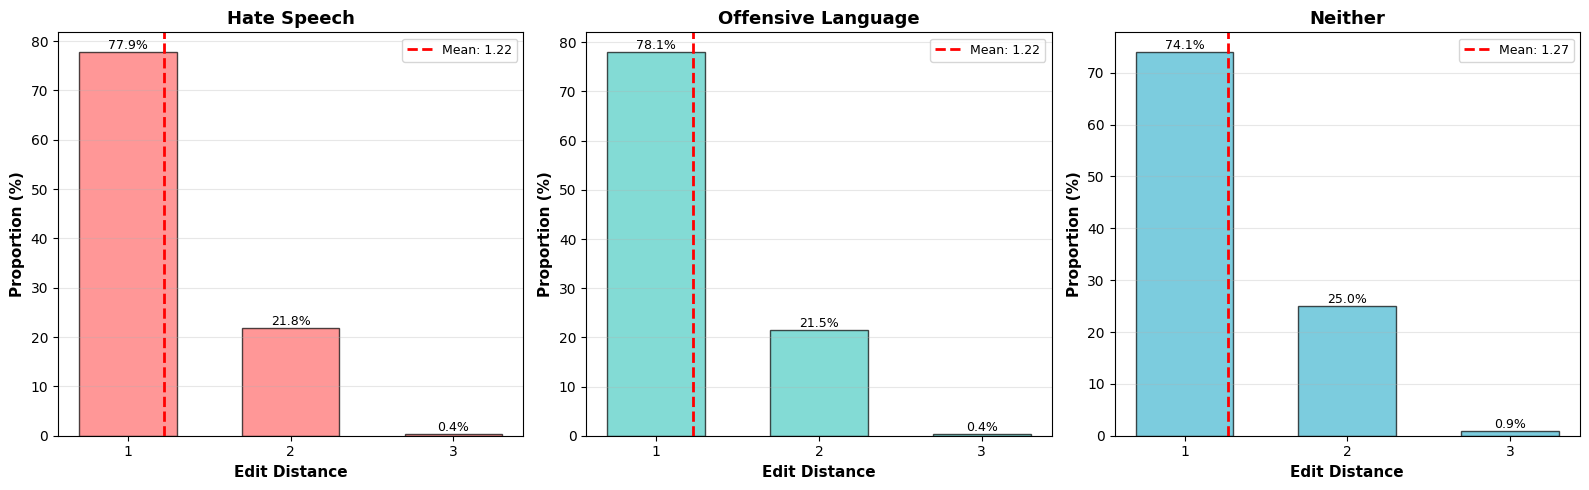

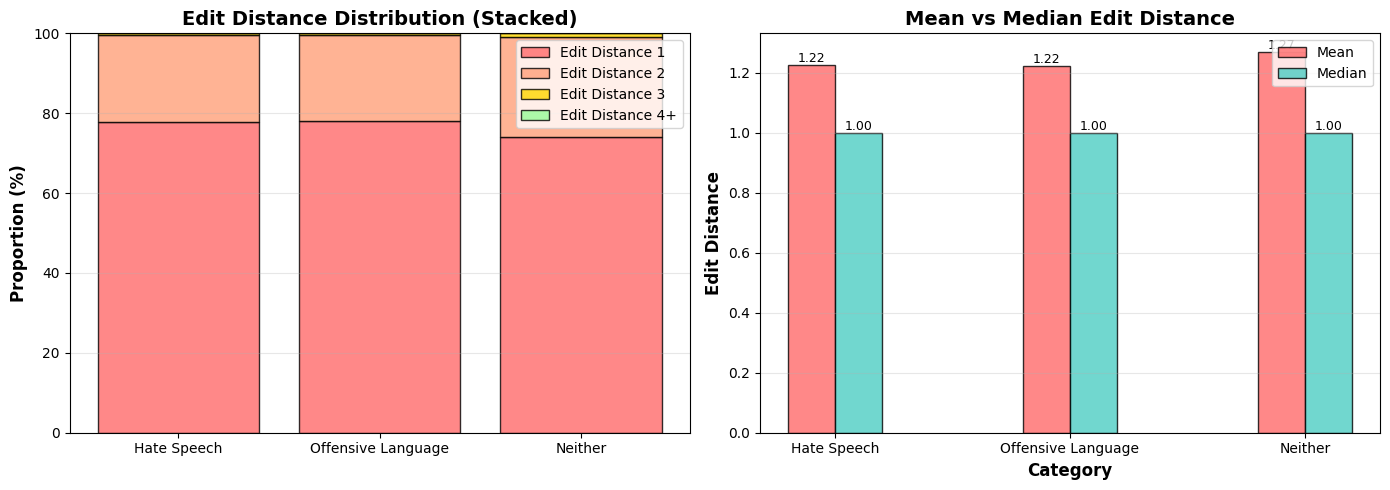

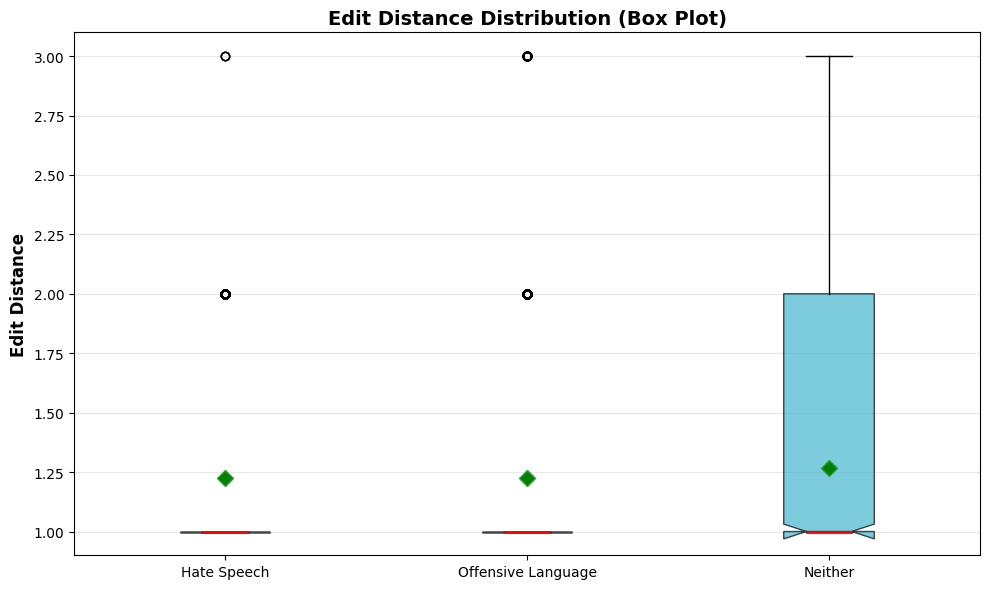

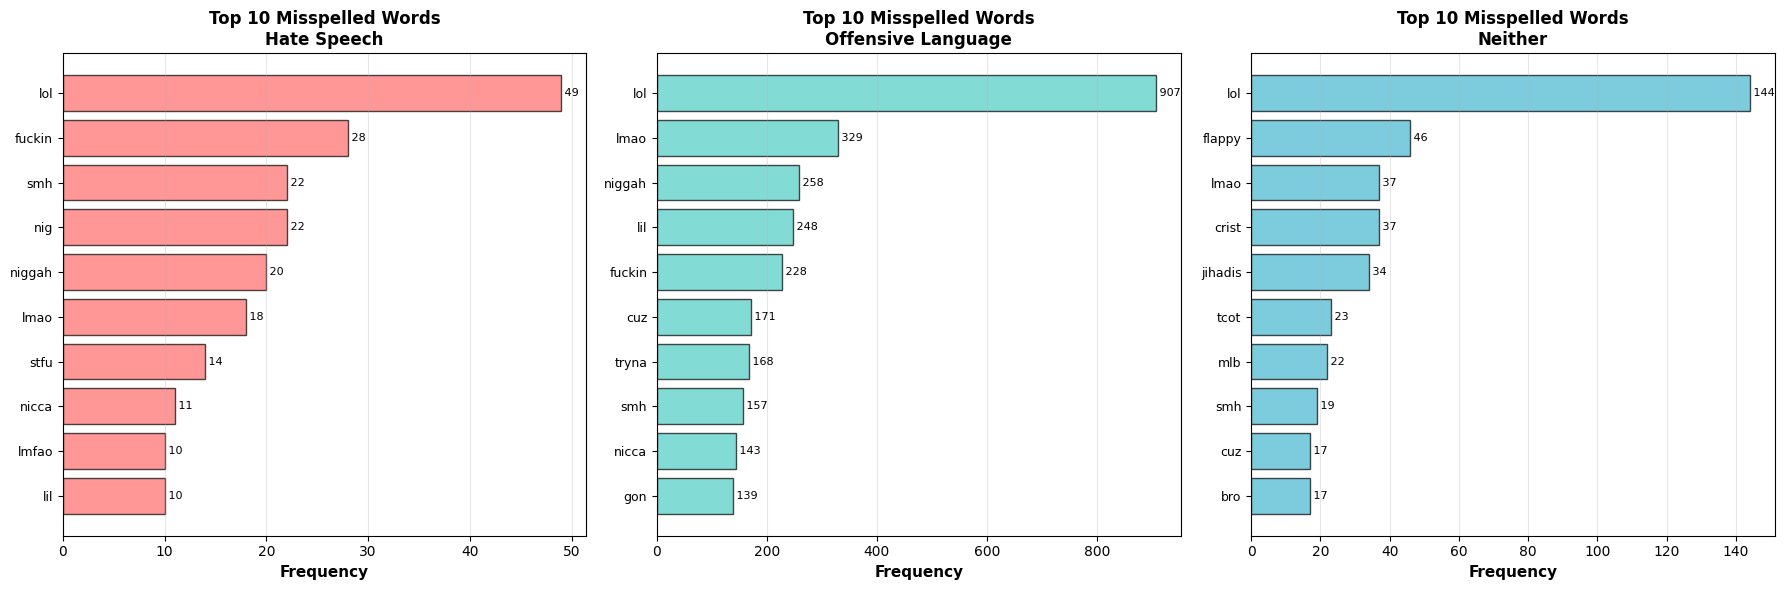


Hate Speech - Sample errors:
  original correction  edit_distance
0   gaywad    wayward              2
1      smh         sh              1
2    lmfao        lao              2
3    ariza       aria              1
4    lmaoo        loo              2
5      nig        big              1
6  jackies     jackie              1
7   evaaaa      vaasa              2
8   fuckin    fucking              1
9      wtf         to              2


In [33]:
spell = SpellChecker()

print(" PySpellChecker initialized")

def levenshtein_distance(s1, s2):
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)
    
    if len(s2) == 0:
        return len(s1)
    
    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    
    return previous_row[-1]

def is_valid_word(word):
    word_lower = word.lower()
    if word.isdigit():
        return True
    if len(wordnet.synsets(word_lower)) > 0:
        return True
    if word_lower in spell:
        return True
    return False


def analyze_spelling_errors(text):
    cleaned = clean_text(text)
    if not cleaned:
        return []
    
    tokens = [t.lower() for t in word_tokenize(cleaned) if t.isalpha()]
    
    errors = []
    for token in tokens:
        if not is_valid_word(token):
            # Get correction from pyspellchecker
            correction = spell.correction(token)
            
            if correction and correction != token:
                # Calculate edit distance
                edit_dist = levenshtein_distance(token, correction)
                
                errors.append({
                    'original': token,
                    'correction': correction,
                    'edit_distance': edit_dist
                })
    
    return errors

def analyze_category_errors(df, category, text_column='cleaned_tweet'):
    """
    Analyze all spelling errors in a category.
    """
    # Use the helper function instead of duplicating the mapping
    category_df = get_category_dataframe(df, category)
    
    print(f"  Analyzing {len(category_df)} posts in {category.replace('_', ' ').title()}...")
    
    # Collect all errors
    all_errors = []
    edit_distance_counts = defaultdict(int)
    
    for idx, row in category_df.iterrows():
        errors = analyze_spelling_errors(row[text_column])
        all_errors.extend(errors)
        
        for error in errors:
            edit_distance_counts[error['edit_distance']] += 1
    
    # Create DataFrame
    errors_df = pd.DataFrame(all_errors)
    
    if len(errors_df) == 0:
        return {
            'category': category,
            'total_errors': 0,
            'edit_distance_distribution': {},
            'edit_distance_proportions': {},
            'mean_edit_distance': 0,
            'median_edit_distance': 0
        }, errors_df
    
    # Calculate proportions
    total_errors = len(errors_df)
    edit_distance_proportions = {
        dist: (count / total_errors * 100) 
        for dist, count in edit_distance_counts.items()
    }
    
    # Statistics
    stats = {
        'category': category,
        'total_errors': total_errors,
        'edit_distance_distribution': dict(edit_distance_counts),
        'edit_distance_proportions': edit_distance_proportions,
        'mean_edit_distance': errors_df['edit_distance'].mean(),
        'median_edit_distance': errors_df['edit_distance'].median(),
        'most_common_errors': Counter([e['original'] for e in all_errors]).most_common(20)
    }
    
    return stats, errors_df

def analyze_all_categories(df, text_column='cleaned_tweet'):
    categories = ['hate_speech', 'offensive_language', 'neither']
    all_stats = {}
    all_errors_df = {}
    
    print("Analyzing spelling correction costs (edit distances)...\n")
    
    for cat in categories:
        stats, errors_df = analyze_category_errors(df, cat, text_column)
        all_stats[cat] = stats
        all_errors_df[cat] = errors_df
    
    summary_data = []
    for cat in categories:
        summary_data.append({
            'Category': cat.replace('_', ' ').title(),
            'Total Errors': all_stats[cat]['total_errors'],
            'Mean Edit Distance': all_stats[cat]['mean_edit_distance'],
            'Median Edit Distance': all_stats[cat]['median_edit_distance'],
            'Edit Dist 1 (%)': all_stats[cat]['edit_distance_proportions'].get(1, 0),
            'Edit Dist 2 (%)': all_stats[cat]['edit_distance_proportions'].get(2, 0),
            'Edit Dist 3 (%)': all_stats[cat]['edit_distance_proportions'].get(3, 0),
            'Edit Dist 4+ (%)': sum([v for k, v in all_stats[cat]['edit_distance_proportions'].items() if k >= 4])
        })
    
    summary_df = pd.DataFrame(summary_data)
    
    print("\n✓ Analysis complete!\n")
    
    return all_stats, all_errors_df, summary_df

def plot_edit_distance_distribution(all_stats):
    categories = ['hate_speech', 'offensive_language', 'neither']
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    for idx, (cat, color) in enumerate(zip(categories, colors)):
        ax = axes[idx]
        
        # Get edit distance distribution
        dist_dict = all_stats[cat]['edit_distance_proportions']
        
        if not dist_dict:
            ax.text(0.5, 0.5, 'No errors found', ha='center', va='center', fontsize=12)
            ax.set_title(cat.replace('_', ' ').title(), fontsize=13, fontweight='bold')
            continue
        
        # Sort by edit distance
        distances = sorted(dist_dict.keys())
        proportions = [dist_dict[d] for d in distances]
        
        bars = ax.bar(distances, proportions, color=color, alpha=0.7, edgecolor='black', width=0.6)
        ax.set_xlabel('Edit Distance', fontsize=11, fontweight='bold')
        ax.set_ylabel('Proportion (%)', fontsize=11, fontweight='bold')
        ax.set_title(cat.replace('_', ' ').title(), fontsize=13, fontweight='bold')
        ax.set_xticks(distances)
        ax.grid(True, alpha=0.3, axis='y')
        
        # Add value labels
        for bar, prop in zip(bars, proportions):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{prop:.1f}%', ha='center', va='bottom', fontsize=9)
        
        # Add mean line
        mean_dist = all_stats[cat]['mean_edit_distance']
        ax.axvline(mean_dist, color='red', linestyle='--', linewidth=2,
                  label=f'Mean: {mean_dist:.2f}')
        ax.legend(fontsize=9)
    
    plt.tight_layout()
    plt.show()

def plot_edit_distance_comparison(summary_df):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    categories = summary_df['Category'].values
    x = np.arange(len(categories))
    width = 0.2
    colors = ['#FF6B6B', '#FFA07A', '#FFD700', '#98FB98']
    
    # Plot 1: Stacked bar chart
    edit_1 = summary_df['Edit Dist 1 (%)'].values
    edit_2 = summary_df['Edit Dist 2 (%)'].values
    edit_3 = summary_df['Edit Dist 3 (%)'].values
    edit_4plus = summary_df['Edit Dist 4+ (%)'].values
    
    ax1.bar(categories, edit_1, label='Edit Distance 1', color=colors[0], alpha=0.8, edgecolor='black')
    ax1.bar(categories, edit_2, bottom=edit_1, label='Edit Distance 2', 
           color=colors[1], alpha=0.8, edgecolor='black')
    ax1.bar(categories, edit_3, bottom=edit_1+edit_2, label='Edit Distance 3',
           color=colors[2], alpha=0.8, edgecolor='black')
    ax1.bar(categories, edit_4plus, bottom=edit_1+edit_2+edit_3, label='Edit Distance 4+',
           color=colors[3], alpha=0.8, edgecolor='black')
    
    ax1.set_ylabel('Proportion (%)', fontsize=12, fontweight='bold')
    ax1.set_title('Edit Distance Distribution (Stacked)', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Plot 2: Grouped bar chart for mean/median
    mean_dist = summary_df['Mean Edit Distance'].values
    median_dist = summary_df['Median Edit Distance'].values
    
    bars1 = ax2.bar(x - width/2, mean_dist, width, label='Mean', 
                    color='#FF6B6B', alpha=0.8, edgecolor='black')
    bars2 = ax2.bar(x + width/2, median_dist, width, label='Median',
                    color='#4ECDC4', alpha=0.8, edgecolor='black')
    
    ax2.set_xlabel('Category', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Edit Distance', fontsize=12, fontweight='bold')
    ax2.set_title('Mean vs Median Edit Distance', fontsize=14, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(categories)
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()

def plot_error_examples(all_stats, n_examples=10):
    """Plot most common spelling errors for each category."""
    categories = ['hate_speech', 'offensive_language', 'neither']
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    for idx, (cat, color) in enumerate(zip(categories, colors)):
        ax = axes[idx]
        
        top_errors = all_stats[cat]['most_common_errors'][:n_examples]
        if not top_errors:
            ax.text(0.5, 0.5, 'No errors found', ha='center', va='center', fontsize=12)
            ax.set_title(cat.replace('_', ' ').title(), fontsize=13, fontweight='bold')
            continue
        
        words = [w for w, _ in top_errors]
        counts = [c for _, c in top_errors]
        
        bars = ax.barh(range(len(words)), counts, color=color, alpha=0.7, edgecolor='black')
        ax.set_yticks(range(len(words)))
        ax.set_yticklabels(words, fontsize=9)
        ax.set_xlabel('Frequency', fontsize=11, fontweight='bold')
        ax.set_title(f"Top {n_examples} Misspelled Words\n{cat.replace('_', ' ').title()}",
                    fontsize=12, fontweight='bold')
        ax.invert_yaxis()
        ax.grid(True, alpha=0.3, axis='x')
        
        for bar, count in zip(bars, counts):
            width = bar.get_width()
            ax.text(width, bar.get_y() + bar.get_height()/2, f' {count}',
                   ha='left', va='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()

def plot_box_comparison(all_errors_df):
    """Box plot comparison of edit distances across categories."""
    categories = ['hate_speech', 'offensive_language', 'neither']
    
    # Prepare data for box plot
    data_for_plot = []
    labels_for_plot = []
    
    for cat in categories:
        if len(all_errors_df[cat]) > 0:
            data_for_plot.append(all_errors_df[cat]['edit_distance'].values)
            labels_for_plot.append(cat.replace('_', ' ').title())
    
    if not data_for_plot:
        print("No errors found for box plot")
        return
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    bp = ax.boxplot(data_for_plot, labels=labels_for_plot, patch_artist=True,
                    notch=True, showmeans=True,
                    boxprops=dict(facecolor='lightblue', alpha=0.7),
                    medianprops=dict(color='red', linewidth=2),
                    meanprops=dict(marker='D', markerfacecolor='green', markersize=8))
    
    ax.set_ylabel('Edit Distance', fontsize=12, fontweight='bold')
    ax.set_title('Edit Distance Distribution (Box Plot)', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Color boxes differently
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    for patch, color in zip(bp['boxes'], colors[:len(bp['boxes'])]):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    plt.tight_layout()
    plt.show()

# DISCRIMINATION ANALYSIS

def analyze_discrimination_power(summary_df, all_stats):
    """
    Analyze discrimination power based on edit distance patterns.
    """
    print("\n" + "="*80)
    print("DISCRIMINATION POWER ANALYSIS")
    print("="*80)
    
    discrimination_data = []
    
    for _, row in summary_df.iterrows():
        cat = row['Category']
        
        # Simple errors (edit distance 1) are easier to correct
        simple_errors = row['Edit Dist 1 (%)']
        
        # Complex errors (edit distance 2+) are harder to correct
        complex_errors = 100 - simple_errors
        
        # Mean edit distance indicates overall error severity
        mean_dist = row['Mean Edit Distance']
        
        discrimination_data.append({
            'Category': cat,
            'Simple Errors (%)': simple_errors,
            'Complex Errors (%)': complex_errors,
            'Mean Edit Distance': mean_dist,
            'Discrimination Score': complex_errors * mean_dist  # Higher = more discriminative
        })
    
    discrim_df = pd.DataFrame(discrimination_data)
    discrim_df = discrim_df.sort_values('Discrimination Score', ascending=False)
    discrim_df['Rank'] = range(1, len(discrim_df) + 1)
    
    return discrim_df

def print_interpretation(summary_df, discrim_df):
    """Print detailed interpretation of results."""
    print("\n" + "="*80)
    print("INTERPRETATION")
    print("="*80)
    
    for _, row in summary_df.iterrows():
        cat = row['Category']
        mean_dist = row['Mean Edit Distance']
        edit1_pct = row['Edit Dist 1 (%)']
        
        print(f"\n{cat}:")
        print(f"  Total spelling errors: {row['Total Errors']:,}")
        print(f"  Mean edit distance: {mean_dist:.2f}")
        print(f"  Median edit distance: {row['Median Edit Distance']:.2f}")
        
        # Error severity assessment
        if mean_dist < 1.5:
            severity = "LOW - mostly simple typos"
        elif mean_dist < 2.0:
            severity = "MODERATE - mix of simple and complex errors"
        elif mean_dist < 2.5:
            severity = "HIGH - many complex errors"
        else:
            severity = "VERY HIGH - severe spelling issues"
        
        print(f"  Error severity: {severity}")
        print(f"  Simple errors (dist=1): {edit1_pct:.1f}%")
        print(f"  Complex errors (dist≥2): {100-edit1_pct:.1f}%")
    
    print("\n" + "="*80)
    print("DISCRIMINATION POWER RANKING")
    print("="*80)
    print(discrim_df[['Rank', 'Category', 'Mean Edit Distance', 
                     'Simple Errors (%)', 'Complex Errors (%)']].to_string(index=False))
    
    print("\n" + "="*80)
    print("CONCLUSION")
    print("="*80)
    
    # Compare categories
    high_quality = summary_df.iloc[summary_df['Mean Edit Distance'].idxmin()]['Category']
    low_quality = summary_df.iloc[summary_df['Mean Edit Distance'].idxmax()]['Category']
    
    print(f"\nBest spelling quality: {high_quality}")
    print(f"Worst spelling quality: {low_quality}")
    
    mean_range = summary_df['Mean Edit Distance'].max() - summary_df['Mean Edit Distance'].min()
    
    if mean_range > 0.5:
        print(f"\n→ SIGNIFICANT difference in spelling error complexity (Δ={mean_range:.2f})")
        print("→ Edit distance patterns can DISCRIMINATE between categories")
    elif mean_range > 0.2:
        print(f"\n→ MODERATE difference in spelling error complexity (Δ={mean_range:.2f})")
        print("→ Edit distance patterns show SOME discrimination power")
    else:
        print(f"\n→ SMALL difference in spelling error complexity (Δ={mean_range:.2f})")
        print("→ Edit distance patterns have LIMITED discrimination power")


# Note: df should already be loaded and preprocessed from earlier cells
# If running this cell standalone, uncomment the following:
# df = load_and_explore_data('reddit_hate_speech.csv')

all_stats, all_errors_df, summary_df = analyze_all_categories(df)

print("="*80)
print("EDIT DISTANCE ANALYSIS SUMMARY")
print("="*80)
print(summary_df.to_string(index=False))

discrim_df = analyze_discrimination_power(summary_df, all_stats)

print_interpretation(summary_df, discrim_df)

plot_edit_distance_distribution(all_stats)
plot_edit_distance_comparison(summary_df)
plot_box_comparison(all_errors_df)
plot_error_examples(all_stats, n_examples=10)

hate_speech_errors = all_errors_df['hate_speech']
print(f"\nHate Speech - Sample errors:")
print(hate_speech_errors.head(10))